In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
np.seterr(divide='ignore', invalid='ignore')
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit import RDConfig
from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
from rdkit.Chem.Fingerprints import FingerprintMols as fp
from rdkit.Chem import AllChem, rdmolops, Lipinski, Descriptors
from rdkit.Chem.Descriptors import ExactMolWt, HeavyAtomMolWt, MolWt    
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2024-10-28 12:07:10.030760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 12:07:10.094066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 12:07:10.112633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 12:07:10.233291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 12:07:11.650457: W tensorflow/compiler/tf2

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [5]:
import dalex as dx

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1730084835.329983   53794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730084835.518460   53794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730084835.518558   53794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [7]:
data_ws = pd.read_csv('./data/ws496_logS.csv')
data_ws['SMILES'] = pd.Series(data_ws['SMILES'], dtype="string")
smiles_ws = data_ws.iloc[:,1]
y_ws = data_ws.iloc[:,2]

data_delaney = pd.read_csv('./data/delaney-processed.csv')
data_delaney['smiles'] = pd.Series(data_delaney['smiles'], dtype="string")
smiles_de = data_delaney.iloc[:,-1]
y_de= data_delaney.iloc[:,1]

data_lovric2020 = pd.read_csv('./data/Lovric2020_logS0.csv')
data_lovric2020['isomeric_smiles'] = pd.Series(data_lovric2020['isomeric_smiles'], dtype="string")
smiles_lo = data_lovric2020.iloc[:,0]
y_lo = data_lovric2020.iloc[:,1]

data_huuskonen = pd.read_csv('./data/huusk.csv')
data_huuskonen['SMILES'] = pd.Series(data_huuskonen['SMILES'], dtype="string")
smiles_hu = data_huuskonen.iloc[:,4]
y_hu = data_huuskonen.iloc[:,-1].astype('float')

y_ws_nponly = y_ws.to_numpy()
y_de_nponly = y_de.to_numpy()
y_lo_nponly = y_lo.to_numpy()
y_hu_nponly = y_hu.to_numpy()

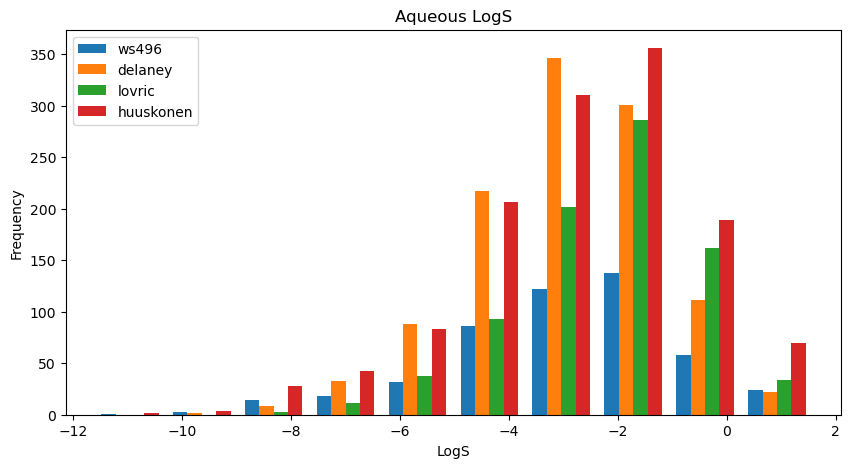

In [8]:
plt.figure(figsize=(10,5))
plt.title('Aqueous LogS')
plt.hist([y_ws, y_de,y_lo,y_hu], label=['ws496','delaney','lovric','huuskonen'])
plt.legend(loc='upper left')
plt.xlabel('LogS')
plt.ylabel('Frequency')
plt.savefig("./LogS_frequency.png", dpi=300)
plt.show()

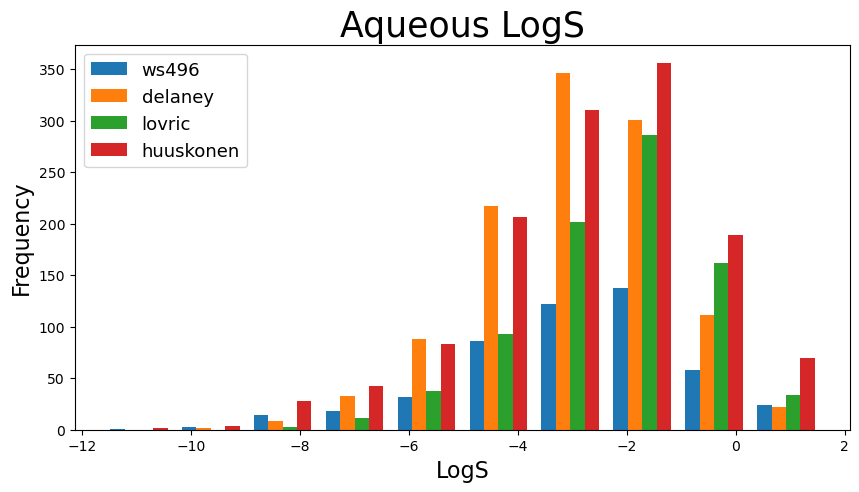

In [9]:
plt.figure(figsize=(10,5))
plt.title('Aqueous LogS',fontsize=25)
plt.hist([y_ws, y_de,y_lo,y_hu], label=['ws496','delaney','lovric','huuskonen'])
plt.legend(loc='upper left',fontsize=13)
plt.xlabel('LogS',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.savefig("./LogS_frequency.png", dpi=300)
plt.show()

In [10]:
def mol3d_conv(mol):
    for i in mol: 
        # input = Chem.AddHs(i)
        Chem.AssignAtomChiralTagsFromStructure(i)
        AllChem.EmbedMolecule(i, useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
        _ = Chem.MolToMolBlock(i,confId=-1)
    return mol

def mol3d_conv2(mol):
    for i in mol:
        AllChem.Compute2DCoords(i)
        input = Chem.AddHs(i)
        ps = AllChem.ETKDGv2()
        ps.randomSeed = 0xf00d
        AllChem.EmbedMolecule(input,ps)
    return mol

def conformer_idf(func, mol):
    arr=[]
    for i in mol:
        if i.GetNumConformers() == 1:
            res = np.asarray(func(i)).astype('float')
            arr.append(res)
        elif i.GetNumConformers() == 0:
            arr.append(0.0)
        else:
            print(f"Every molecule must have at most 1 conformer!")
    return arr

In [11]:
def fp_converter(data):
    LEN_OF_FF = 2048
    mols = [Chem.MolFromSmiles(data) for data in data]
    ECFP = [AllChem.GetMorganFingerprintAsBitVect(data, 2, nBits=LEN_OF_FF) for data in mols]
    MACCS = [Chem.rdMolDescriptors.GetMACCSKeysFingerprint(data) for data in mols]
    AvalonFP = [GetAvalonFP(data) for data in mols]

    ECFP_container = []
    MACCS_container = []
    AvalonFP_container=AvalonFP
    for fps in ECFP:
        arr = np.zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(fps, arr)
        ECFP_container.append(arr)  
    
    for fps2 in MACCS:
        arr2 = np.zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(fps2, arr2)
        MACCS_container.append(arr2)
    
    ECFP_container = np.asarray(ECFP_container)
    MACCS_container = np.asarray(MACCS_container)
    AvalonFP_container = np.asarray(AvalonFP_container)    
    return mols,ECFP_container, MACCS_container, AvalonFP_container

In [12]:
mol_ws, x_ws, MACCS_ws, AvalonFP_ws = fp_converter(smiles_ws)
mol_de, x_de, MACCS_de, AvalonFP_de = fp_converter(smiles_de)
mol_lo, x_lo, MACCS_lo, AvalonFP_lo = fp_converter(smiles_lo)
mol_hu, x_hu, MACCS_hu, AvalonFP_hu = fp_converter(smiles_hu)

group_nws = np.concatenate([x_ws,MACCS_ws,AvalonFP_ws], axis=1)
group_nde = np.concatenate([x_de,MACCS_de,AvalonFP_de], axis=1)
group_nlo = np.concatenate([x_lo,MACCS_lo,AvalonFP_lo], axis=1)
group_nhu = np.concatenate([x_hu,MACCS_hu,AvalonFP_hu], axis=1)

[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerator
[12:07:16] DEPRECATION WARNING: please use MorganGenerat

In [13]:
def search_data_origin(features,fps,mols,name,types='pd', record_confirm=False):
    [Chem.rdchem.Mol.ComputeGasteigerCharges(mols) for mols in mols]
    GasteigerCharg_contribs = []
    for k in mols:
        GasteigerCharg_contribs.append([k.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(k.GetNumAtoms())])
    maxLength = len(max(GasteigerCharg_contribs, key=len))
    phase1  = features[0]  # "MolWeight"
    phase2  = features[1]  # "Mol_MR"
    phase3  = features[2]  # "Mol_TPSA"
    phase4  = features[3]  # "Mol_logP"
    phase5  = features[4]  # "RotatedBonds"
    phase6  = features[5]  # "HeavyAtom"
    phase7  = features[6]  # "numHAcceptor"
    phase8  = features[7]  # "numHDoner"
    phase9  = features[8]  # "numHeteroatom"
    phase10 = features[9]  # "NumValenceElec"
    phase11 = features[10] # "NHOHCount"
    phase12 = features[11] # "NOCount"
    phase13 = features[12] # "Ringcount"
    phase14 = features[13] # "numAromaticR"
    phase15 = features[14] # "numSaturateR"
    phase16 = features[15] # "numAliphaticR"
    phase17 = features[16] # "LabuteASA"
    phase18 = features[17] # "BalabanJs"
    phase19 = features[18] # "BertzCTs"
    phase20 = features[19] # "ipc"
    phase21 = features[20] # "kappa_Series[1-3]"
    phase22 = features[21] # "Chi_Series[13]"
    phase23 = features[22] # "phi"
    phase24 = features[23] # "HallKierAlpha"
    phase25 = features[24] # "NumAmideBonds"
    phase26 = features[25] # "FractionCSP3"
    phase27 = features[26] # "NumSpiroAtoms"
    phase28 = features[27] # "NumBridgeheadAtoms"
    phase29 = features[28] # "PEOE_VSA_Series[1-14]"
    phase30 = features[29] # "SMR_VSA_Series[1-10]"
    phase31 = features[30] # "SlogP_VSA_Series[1-12]"
    phase32 = features[31] # "EState_VSA_Series[1-11]"
    phase33 = features[32] # "VSA_EState_Series[1-10]"
    phase34 = features[33] # "Asphericity"
    phase35 = features[34] # "PBF"
    phase36 = features[35] # "PMI_series[1-3]"
    phase37 = features[36] # "NPR_series[1-2]"
    phase38 = features[37] # "RadiusOfGyration"
    phase39 = features[38] # "InertialShapeFactor"
    phase40 = features[39] # "Eccentricity"
    phase41 = features[40] # "SpherocityIndex"
    phase42 = features[41] # "MQNs"
    phase43 = features[42] # "AUTOCORR2D"
    phase44 = features[43] # "BCUT2D", 
    phase45 = features[44] # "AUTOCORR3D"
    phase46 = features[45] # "RDF"
    phase47 = features[46] # "MORSE"
    phase48 = features[47] # "WHIM"
    phase49 = features[48] # "GETAWAY"
    ##############
    ##############
    if phase1 == 1:
        descriptor = [ExactMolWt(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['MolWt'] = descriptor
        del descriptor 
    if phase2 == 1:
        descriptor = [Chem.Crippen.MolLogP(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['MolLogP'] = descriptor
        del descriptor 
    if phase3 == 1:
        descriptor = [Descriptors.TPSA(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['TPSA'] = descriptor
        del descriptor 
    if phase4 == 1:
        descriptor = [Chem.Crippen.MolMR (mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['MolMR'] = descriptor
        del descriptor 
    if phase5 == 1:
        descriptor = [Chem.Lipinski.NumRotatableBonds(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumRotatableBonds'] = descriptor
        del descriptor
    if phase6 == 1:
        descriptor = [Chem.Lipinski.HeavyAtomCount(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['HeavyAtomCount'] = descriptor
        del descriptor
    if phase7 == 1:
        descriptor =  [Chem.Lipinski.NumHAcceptors(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumHAcceptors'] = descriptor
        del descriptor 
    if phase8 == 1:
        descriptor = [Chem.Lipinski.NumHDonors(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumHDonors'] = descriptor
        del descriptor 
    if phase9 == 1:
        descriptor =  [Chem.Lipinski.NumHeteroatoms(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['Heteroatoms'] = descriptor
        del descriptor 
    if phase10 == 1:
        descriptor = [Chem.Descriptors.NumValenceElectrons(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['ValenceElectrons'] = descriptor
        del descriptor
    if phase11 == 1:
        descriptor = [Chem.Lipinski.NHOHCount(mols)  for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NHOHCount'] = descriptor
        del descriptor
    if phase12 == 1:
        descriptor = [Chem.Lipinski.NOCount(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NOCount'] = descriptor
        del descriptor
    if phase13 == 1:
        descriptor = [Chem.Lipinski.RingCount(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['RingCount'] = descriptor
        del descriptor 
    if phase14 == 1:
        descriptor = [Chem.Lipinski.NumAromaticRings(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumAromaticRings'] = descriptor
        del descriptor 
    if phase15 == 1:
        descriptor = [Chem.Lipinski.NumSaturatedRings(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumSaturatedRings'] = descriptor
        del descriptor
    if phase16 == 1:
        descriptor = [Chem.Lipinski.NumAliphaticRings(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumAliphaticRings'] = descriptor
        del descriptor
    if phase17 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcLabuteASA(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['LabuteASA'] = descriptor
        del descriptor 
    if phase18 == 1:
        descriptor = [Chem.GraphDescriptors.BalabanJ(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['BalabanJ'] = descriptor
        del descriptor 
    if phase19 == 1:
        descriptor = [Chem.GraphDescriptors.BertzCT(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['BertzCT'] = descriptor
        del descriptor
    if phase20 == 1:
        descriptor = [Chem.GraphDescriptors.Ipc(alpha) for alpha in mols]
        descriptor1 = np.asarray(descriptor).astype('float')
        descriptor2 = np.log1p(descriptor1+0.0001)        
        
        if types == 'np1':
            fps = np.concatenate([fps,descriptor2[:,None]], axis=1)
            del descriptor,descriptor1,descriptor2
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor2))
            del descriptor,descriptor1,descriptor2
        else:
            if record_confirm==True:           
                # fps['Ipc'] = descriptor1
                fps['Ipc'] = descriptor2
                del descriptor,descriptor1,descriptor2
            else:
                fps['Ipc'] = descriptor2
                del descriptor,descriptor1,descriptor2
    if phase21 == 1:
        kappa1 = [Chem.GraphDescriptors.Kappa1(mols) for mols in mols]
        kappa2 = [Chem.GraphDescriptors.Kappa2(mols) for mols in mols]
        kappa3 = [Chem.GraphDescriptors.Kappa3(mols) for mols in mols]
        kappa1 = np.asarray(kappa1).astype('float')
        kappa2 = np.asarray(kappa2).astype('float')
        kappa3 = np.asarray(kappa3).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,kappa1[:,None]], axis=1)
            fps = np.concatenate([fps,kappa2[:,None]], axis=1)
            fps = np.concatenate([fps,kappa3[:,None]], axis=1)
            del kappa1,kappa2,kappa3
        elif types == 'np2':
            fps = np.column_stack((fps,kappa1))
            fps = np.column_stack((fps,kappa2))
            fps = np.column_stack((fps,kappa3))
            del kappa1,kappa2,kappa3
        else:
            if record_confirm==True:
                fps['Kappa_series'] = kappa1+kappa2+kappa3
                del kappa1,kappa2,kappa3
            else:
                fps['kappa1'] = kappa1
                fps['kappa2'] = kappa2
                fps['kappa3'] = kappa3
                del kappa1,kappa2,kappa3
    if phase22 == 1:
        def values_chiN(mols):
            list_char=[]
            i=0
            while(1):
                if Chem.GraphDescriptors.ChiNn_(mols,i)==0.0:
                    break
                list_char.append(Chem.GraphDescriptors.ChiNn_(mols,i))
                i+=1
            res = np.array(list_char)
            return res
        def values_chiV(mols):
            list_char=[]
            i=0
            while(1):
                if Chem.GraphDescriptors.ChiNv_(mols,i)==0.0:
                    break
                list_char.append(Chem.GraphDescriptors.ChiNv_(mols,i))
                i+=1
            res = np.array(list_char)
            return res
        Chi0   = [Chem.GraphDescriptors.Chi0(mols)     for mols in mols]
        Chi0n  = [Chem.GraphDescriptors.Chi0n(mols)    for mols in mols]
        Chi0v  = [Chem.GraphDescriptors.Chi0v(mols)    for mols in mols]
        Chi1   = [Chem.GraphDescriptors.Chi1(mols)     for mols in mols]
        Chi1n  = [Chem.GraphDescriptors.Chi1n(mols)    for mols in mols]
        Chi1v  = [Chem.GraphDescriptors.Chi1v(mols)    for mols in mols]
        Chi2n  = [Chem.GraphDescriptors.Chi2n(mols)    for mols in mols]
        Chi2v  = [Chem.GraphDescriptors.Chi2v(mols)    for mols in mols]
        Chi3n  = [Chem.GraphDescriptors.Chi3n(mols)    for mols in mols]
        Chi3v  = [Chem.GraphDescriptors.Chi3v(mols)    for mols in mols]
        Chi4n  = [Chem.GraphDescriptors.Chi4n(mols)    for mols in mols]
        Chi4v  = [Chem.GraphDescriptors.Chi4v(mols)    for mols in mols]
        ChiNn_ = [values_chiN(alpha) for alpha in mols]
        ChiNv_ = [values_chiV(alpha) for alpha in mols]
        pdChiNn_ = pd.DataFrame(ChiNn_).to_numpy()
        pdChiNv_ = pd.DataFrame(ChiNv_).to_numpy()
        ##################################
        Chi0   = np.asarray(Chi0 ).astype('float')
        Chi0n  = np.asarray(Chi0n).astype('float')
        Chi0v  = np.asarray(Chi0v).astype('float')
        Chi1   = np.asarray(Chi1 ).astype('float')
        Chi1n  = np.asarray(Chi1n).astype('float')
        Chi1v  = np.asarray(Chi1v).astype('float')
        Chi2n  = np.asarray(Chi2n).astype('float')
        Chi2v  = np.asarray(Chi2v).astype('float')
        Chi3n  = np.asarray(Chi3n).astype('float')
        Chi3v  = np.asarray(Chi3v).astype('float')
        Chi4n  = np.asarray(Chi4n).astype('float')
        Chi4v  = np.asarray(Chi4v).astype('float')        
        ChiNn_ = np.asarray(pdChiNn_).astype('float')
        ChiNv_ = np.asarray(pdChiNv_).astype('float')
        ChiNn_ = np.nan_to_num(ChiNn_, nan=0)
        ChiNv_ = np.nan_to_num(ChiNv_, nan=0)
        del pdChiNn_,pdChiNv_
        ##################################
        ##################################
        if types == 'np1':
            fps = np.concatenate([fps,Chi0  [:,None]], axis=1)
            fps = np.concatenate([fps,Chi0n [:,None]], axis=1)
            fps = np.concatenate([fps,Chi0v [:,None]], axis=1)
            fps = np.concatenate([fps,Chi1  [:,None]], axis=1)
            fps = np.concatenate([fps,Chi1n [:,None]], axis=1)
            fps = np.concatenate([fps,Chi1v [:,None]], axis=1)
            fps = np.concatenate([fps,Chi2n [:,None]], axis=1)
            fps = np.concatenate([fps,Chi2v [:,None]], axis=1)
            fps = np.concatenate([fps,Chi3n [:,None]], axis=1)
            fps = np.concatenate([fps,Chi3v [:,None]], axis=1)
            fps = np.concatenate([fps,Chi4n [:,None]], axis=1)
            fps = np.concatenate([fps,Chi4v [:,None]], axis=1)
            fps = np.concatenate([fps,ChiNn_], axis=1)
            fps = np.concatenate([fps,ChiNv_], axis=1)
            del Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,ChiNn_,ChiNv_
        elif types == 'np2':
            fps = np.column_stack((fps,Chi0 ))
            fps = np.column_stack((fps,Chi0n))
            fps = np.column_stack((fps,Chi0v))
            fps = np.column_stack((fps,Chi1 ))
            fps = np.column_stack((fps,Chi1n))
            fps = np.column_stack((fps,Chi1v))
            fps = np.column_stack((fps,Chi2n))
            fps = np.column_stack((fps,Chi2v))
            fps = np.column_stack((fps,Chi3n))
            fps = np.column_stack((fps,Chi3v))
            fps = np.column_stack((fps,Chi4n))
            fps = np.column_stack((fps,Chi4v))
            fps = np.column_stack((fps,ChiNn_))
            fps = np.column_stack((fps,ChiNv_))
            del Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,ChiNn_,ChiNv_
        else:
            if record_confirm==True:
                t1 = np.sum(ChiNn_, axis=1)
                t2 = np.sum(ChiNv_, axis=1)
                res = Chi0+Chi0n+Chi0v+Chi1+Chi1n+Chi1v+Chi2n+Chi2v+Chi3n+Chi3v+Chi4n+Chi4v+t1+t2
                fps['Chi_series'] = res
                del t1,t2,res
                del Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,ChiNn_,ChiNv_
            else:
                fps['Chi0  '] = Chi0  
                fps['Chi0n '] = Chi0n 
                fps['Chi0v '] = Chi0v 
                fps['Chi1  '] = Chi1  
                fps['Chi1n '] = Chi1n 
                fps['Chi1v '] = Chi1v 
                fps['Chi2n '] = Chi2n 
                fps['Chi2v '] = Chi2v 
                fps['Chi3n '] = Chi3n 
                fps['Chi3v '] = Chi3v 
                fps['Chi4n '] = Chi4n 
                fps['Chi4v '] = Chi4v
                tmp1 = pd.DataFrame(data=ChiNn_, columns=['ChiNn_{}'.format(i) for i in range(ChiNn_.shape[1])], dtype='float')
                tmp2 = pd.DataFrame(data=ChiNv_, columns=['ChiNv_{}'.format(i) for i in range(ChiNv_.shape[1])], dtype='float')
                dataset = [fps,tmp1,tmp2]
                fps = pd.concat(dataset, axis=1)
                del tmp1, tmp2
                del Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,ChiNn_,ChiNv_
    if phase23 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcPhi(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['Phi'] = descriptor
        del descriptor
    if phase24 == 1:
        descriptor = [Chem.GraphDescriptors.HallKierAlpha(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['HallKierAlpha'] = descriptor
        del descriptor  
    if phase25 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcNumAmideBonds(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumAmideBonds'] = descriptor
        del descriptor  
    if phase26 == 1:
        descriptor = [Chem.Lipinski.FractionCSP3(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['FractionCSP3'] = descriptor
        del descriptor  
    if phase27 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcNumSpiroAtoms(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumSpiroAtoms'] = descriptor
        del descriptor
    if phase28 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcNumBridgeheadAtoms(mols) for mols in mols]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['NumBridgeheadAtoms'] = descriptor
        del descriptor
    ####
    if phase29 == 1:
        PEOE_VSA1  = [Chem.MolSurf.PEOE_VSA1(mols) for mols in mols]
        PEOE_VSA2  = [Chem.MolSurf.PEOE_VSA2(mols) for mols in mols]
        PEOE_VSA3  = [Chem.MolSurf.PEOE_VSA3(mols) for mols in mols]
        PEOE_VSA4  = [Chem.MolSurf.PEOE_VSA4(mols) for mols in mols]
        PEOE_VSA5  = [Chem.MolSurf.PEOE_VSA5(mols) for mols in mols]
        PEOE_VSA6  = [Chem.MolSurf.PEOE_VSA6(mols) for mols in mols]
        PEOE_VSA7  = [Chem.MolSurf.PEOE_VSA7(mols) for mols in mols]
        PEOE_VSA8  = [Chem.MolSurf.PEOE_VSA8(mols) for mols in mols]
        PEOE_VSA9  = [Chem.MolSurf.PEOE_VSA9(mols) for mols in mols]
        PEOE_VSA10 = [Chem.MolSurf.PEOE_VSA10(mols) for mols in mols]
        PEOE_VSA11 = [Chem.MolSurf.PEOE_VSA11(mols) for mols in mols]
        PEOE_VSA12 = [Chem.MolSurf.PEOE_VSA12(mols) for mols in mols]
        PEOE_VSA13 = [Chem.MolSurf.PEOE_VSA13(mols) for mols in mols]
        PEOE_VSA14 = [Chem.MolSurf.PEOE_VSA14(mols) for mols in mols]
        PEOE_VSA1  = np.asarray(PEOE_VSA1).astype('float')
        PEOE_VSA2  = np.asarray(PEOE_VSA2).astype('float')
        PEOE_VSA3  = np.asarray(PEOE_VSA3).astype('float')
        PEOE_VSA4  = np.asarray(PEOE_VSA4).astype('float')
        PEOE_VSA5  = np.asarray(PEOE_VSA5).astype('float')
        PEOE_VSA6  = np.asarray(PEOE_VSA6).astype('float')
        PEOE_VSA7  = np.asarray(PEOE_VSA7).astype('float')
        PEOE_VSA8  = np.asarray(PEOE_VSA8).astype('float')
        PEOE_VSA9  = np.asarray(PEOE_VSA9).astype('float')
        PEOE_VSA10 = np.asarray(PEOE_VSA10).astype('float')
        PEOE_VSA11 = np.asarray(PEOE_VSA11).astype('float')
        PEOE_VSA12 = np.asarray(PEOE_VSA12).astype('float')
        PEOE_VSA13 = np.asarray(PEOE_VSA13).astype('float')
        PEOE_VSA14 = np.asarray(PEOE_VSA14).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,PEOE_VSA1[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA2[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA3[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA4[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA5[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA6[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA7[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA8[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA9[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA10[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA11[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA12[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA13[:,None]], axis=1)
            fps = np.concatenate([fps,PEOE_VSA14[:,None]], axis=1)
            del PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
        elif types == 'np2':
            fps = np.column_stack((fps,PEOE_VSA1))
            fps = np.column_stack((fps,PEOE_VSA2))
            fps = np.column_stack((fps,PEOE_VSA3))
            fps = np.column_stack((fps,PEOE_VSA4))
            fps = np.column_stack((fps,PEOE_VSA5))
            fps = np.column_stack((fps,PEOE_VSA6))
            fps = np.column_stack((fps,PEOE_VSA7))
            fps = np.column_stack((fps,PEOE_VSA8))
            fps = np.column_stack((fps,PEOE_VSA9))
            fps = np.column_stack((fps,PEOE_VSA10))
            fps = np.column_stack((fps,PEOE_VSA11))
            fps = np.column_stack((fps,PEOE_VSA12))
            fps = np.column_stack((fps,PEOE_VSA13))
            fps = np.column_stack((fps,PEOE_VSA14))
            del PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
        else:
            if record_confirm==True:
                res = PEOE_VSA1 +PEOE_VSA2 +PEOE_VSA3 +PEOE_VSA4 +PEOE_VSA5 +PEOE_VSA6 +PEOE_VSA7 +PEOE_VSA8 +PEOE_VSA9 +PEOE_VSA10+PEOE_VSA11+PEOE_VSA12+PEOE_VSA13+PEOE_VSA14
                fps['PEOE_VSA_series'] = res
                del res
                del PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
            else:
                fps['PEOE_VSA1']=PEOE_VSA1 
                fps['PEOE_VSA2']=PEOE_VSA2 
                fps['PEOE_VSA3']=PEOE_VSA3 
                fps['PEOE_VSA4']=PEOE_VSA4 
                fps['PEOE_VSA5']=PEOE_VSA5 
                fps['PEOE_VSA6']=PEOE_VSA6 
                fps['PEOE_VSA7']=PEOE_VSA7 
                fps['PEOE_VSA8']=PEOE_VSA8 
                fps['PEOE_VSA9']=PEOE_VSA9 
                fps['PEOE_VSA10']=PEOE_VSA10
                fps['PEOE_VSA11']=PEOE_VSA11
                fps['PEOE_VSA12']=PEOE_VSA12
                fps['PEOE_VSA13']=PEOE_VSA13
                fps['PEOE_VSA14']=PEOE_VSA14
                del PEOE_VSA1,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
    ########
    if phase30 == 1:
        SMR_VSA1  = [Chem.MolSurf.SMR_VSA1(mols) for mols in mols]
        SMR_VSA2  = [Chem.MolSurf.SMR_VSA2(mols) for mols in mols]
        SMR_VSA3  = [Chem.MolSurf.SMR_VSA3(mols) for mols in mols]
        SMR_VSA4  = [Chem.MolSurf.SMR_VSA4(mols) for mols in mols]
        SMR_VSA5  = [Chem.MolSurf.SMR_VSA5(mols) for mols in mols]
        SMR_VSA6  = [Chem.MolSurf.SMR_VSA6(mols) for mols in mols]
        SMR_VSA7  = [Chem.MolSurf.SMR_VSA7(mols) for mols in mols]
        SMR_VSA8  = [Chem.MolSurf.SMR_VSA8(mols) for mols in mols]
        SMR_VSA9  = [Chem.MolSurf.SMR_VSA9(mols) for mols in mols]
        SMR_VSA10 = [Chem.MolSurf.SMR_VSA10(mols) for mols in mols]
        SMR_VSA1  = np.asarray(SMR_VSA1 ).astype('float')
        SMR_VSA2  = np.asarray(SMR_VSA2 ).astype('float')
        SMR_VSA3  = np.asarray(SMR_VSA3 ).astype('float')
        SMR_VSA4  = np.asarray(SMR_VSA4 ).astype('float')
        SMR_VSA5  = np.asarray(SMR_VSA5 ).astype('float')
        SMR_VSA6  = np.asarray(SMR_VSA6 ).astype('float')
        SMR_VSA7  = np.asarray(SMR_VSA7 ).astype('float')
        SMR_VSA8  = np.asarray(SMR_VSA8 ).astype('float')
        SMR_VSA9  = np.asarray(SMR_VSA9 ).astype('float')
        SMR_VSA10 = np.asarray(SMR_VSA10).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,SMR_VSA1[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA2[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA3[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA4[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA5[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA6[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA7[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA8[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA9[:,None]], axis=1)
            fps = np.concatenate([fps,SMR_VSA10[:,None]], axis=1)
            del SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SMR_VSA10
        elif types == 'np2':
            fps = np.column_stack((fps,SMR_VSA1))
            fps = np.column_stack((fps,SMR_VSA2))
            fps = np.column_stack((fps,SMR_VSA3))
            fps = np.column_stack((fps,SMR_VSA4))
            fps = np.column_stack((fps,SMR_VSA5))
            fps = np.column_stack((fps,SMR_VSA6))
            fps = np.column_stack((fps,SMR_VSA7))
            fps = np.column_stack((fps,SMR_VSA8))
            fps = np.column_stack((fps,SMR_VSA9))
            fps = np.column_stack((fps,SMR_VSA10))
            del SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SMR_VSA10
        else:
            if record_confirm==True:
                res = SMR_VSA1 +SMR_VSA2 +SMR_VSA3 +SMR_VSA4 +SMR_VSA5 +SMR_VSA6 +SMR_VSA7 +SMR_VSA8 +SMR_VSA9 +SMR_VSA10
                fps['SMR_VSA_series'] = res
                del res
                del SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SMR_VSA10
            else:
                fps['SMR_VSA1']=SMR_VSA1 
                fps['SMR_VSA2']=SMR_VSA2 
                fps['SMR_VSA3']=SMR_VSA3 
                fps['SMR_VSA4']=SMR_VSA4 
                fps['SMR_VSA5']=SMR_VSA5 
                fps['SMR_VSA6']=SMR_VSA6 
                fps['SMR_VSA7']=SMR_VSA7 
                fps['SMR_VSA8']=SMR_VSA8 
                fps['SMR_VSA9']=SMR_VSA9 
                fps['SMR_VSA10']=SMR_VSA10
                del SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SMR_VSA10
    ########
    if phase31 == 1:
        SlogP_VSA1  = [Chem.MolSurf.SlogP_VSA1(mols) for mols in mols]
        SlogP_VSA2  = [Chem.MolSurf.SlogP_VSA2(mols) for mols in mols]
        SlogP_VSA3  = [Chem.MolSurf.SlogP_VSA3(mols) for mols in mols]
        SlogP_VSA4  = [Chem.MolSurf.SlogP_VSA4(mols) for mols in mols]
        SlogP_VSA5  = [Chem.MolSurf.SlogP_VSA5(mols) for mols in mols]
        SlogP_VSA6  = [Chem.MolSurf.SlogP_VSA6(mols) for mols in mols]
        SlogP_VSA7  = [Chem.MolSurf.SlogP_VSA7(mols) for mols in mols]
        SlogP_VSA8  = [Chem.MolSurf.SlogP_VSA8(mols) for mols in mols]
        SlogP_VSA9  = [Chem.MolSurf.SlogP_VSA9(mols) for mols in mols]
        SlogP_VSA10 = [Chem.MolSurf.SlogP_VSA10(mols) for mols in mols]
        SlogP_VSA11 = [Chem.MolSurf.SlogP_VSA11(mols) for mols in mols]
        SlogP_VSA12 = [Chem.MolSurf.SlogP_VSA12(mols) for mols in mols]
        SlogP_VSA1 = np.asarray(SlogP_VSA1).astype('float')
        SlogP_VSA2 = np.asarray(SlogP_VSA2).astype('float')
        SlogP_VSA3 = np.asarray(SlogP_VSA3).astype('float')
        SlogP_VSA4 = np.asarray(SlogP_VSA4).astype('float')
        SlogP_VSA5 = np.asarray(SlogP_VSA5).astype('float')
        SlogP_VSA6 = np.asarray(SlogP_VSA6).astype('float')
        SlogP_VSA7 = np.asarray(SlogP_VSA7).astype('float')
        SlogP_VSA8 = np.asarray(SlogP_VSA8).astype('float')
        SlogP_VSA9 = np.asarray(SlogP_VSA9).astype('float')
        SlogP_VSA10 = np.asarray(SlogP_VSA10).astype('float')
        SlogP_VSA11 = np.asarray(SlogP_VSA11).astype('float')
        SlogP_VSA12 = np.asarray(SlogP_VSA12).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,SlogP_VSA1[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA2[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA3[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA4[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA5[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA6[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA7[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA8[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA9[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA10[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA11[:,None]], axis=1)
            fps = np.concatenate([fps,SlogP_VSA12[:,None]], axis=1)
            del SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12
        elif types == 'np2':
            fps = np.column_stack((fps,SlogP_VSA1))
            fps = np.column_stack((fps,SlogP_VSA2))
            fps = np.column_stack((fps,SlogP_VSA3))
            fps = np.column_stack((fps,SlogP_VSA4))
            fps = np.column_stack((fps,SlogP_VSA5))
            fps = np.column_stack((fps,SlogP_VSA6))
            fps = np.column_stack((fps,SlogP_VSA7))
            fps = np.column_stack((fps,SlogP_VSA8))
            fps = np.column_stack((fps,SlogP_VSA9))
            fps = np.column_stack((fps,SlogP_VSA10))
            fps = np.column_stack((fps,SlogP_VSA11))
            fps = np.column_stack((fps,SlogP_VSA12))
            del SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12
        else:
            if record_confirm==True:
                res = SlogP_VSA1 +SlogP_VSA2 +SlogP_VSA3 +SlogP_VSA4 +SlogP_VSA5 +SlogP_VSA6 +SlogP_VSA7 +SlogP_VSA8 +SlogP_VSA9 +SlogP_VSA10+SlogP_VSA11+SlogP_VSA12
                fps['SlogP_VSA_series'] = res
                del res
                del SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12
            else:
                fps['SlogP_VSA1']=SlogP_VSA1 
                fps['SlogP_VSA2']=SlogP_VSA2 
                fps['SlogP_VSA3']=SlogP_VSA3 
                fps['SlogP_VSA4']=SlogP_VSA4 
                fps['SlogP_VSA5']=SlogP_VSA5 
                fps['SlogP_VSA6']=SlogP_VSA6 
                fps['SlogP_VSA7']=SlogP_VSA7 
                fps['SlogP_VSA8']=SlogP_VSA8 
                fps['SlogP_VSA9']=SlogP_VSA9 
                fps['SlogP_VSA10']=SlogP_VSA10
                fps['SlogP_VSA11']=SlogP_VSA11
                fps['SlogP_VSA12']=SlogP_VSA12
                del SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12
    ########
    if phase32 == 1:
        EState_VSA1  = [Chem.EState.EState_VSA.EState_VSA1(mols) for mols in mols]
        EState_VSA2  = [Chem.EState.EState_VSA.EState_VSA2(mols) for mols in mols]
        EState_VSA3  = [Chem.EState.EState_VSA.EState_VSA3(mols) for mols in mols]
        EState_VSA4  = [Chem.EState.EState_VSA.EState_VSA4(mols) for mols in mols]
        EState_VSA5  = [Chem.EState.EState_VSA.EState_VSA5(mols) for mols in mols]
        EState_VSA6  = [Chem.EState.EState_VSA.EState_VSA6(mols) for mols in mols]
        EState_VSA7  = [Chem.EState.EState_VSA.EState_VSA7(mols) for mols in mols]
        EState_VSA8  = [Chem.EState.EState_VSA.EState_VSA8(mols) for mols in mols]
        EState_VSA9  = [Chem.EState.EState_VSA.EState_VSA9(mols) for mols in mols]
        EState_VSA10 = [Chem.EState.EState_VSA.EState_VSA10(mols) for mols in mols]
        EState_VSA11 = [Chem.EState.EState_VSA.EState_VSA11(mols) for mols in mols]
        EState_VSA1 = np.asarray(EState_VSA1).astype('float')
        EState_VSA2 = np.asarray(EState_VSA2).astype('float')
        EState_VSA3 = np.asarray(EState_VSA3).astype('float')
        EState_VSA4 = np.asarray(EState_VSA4).astype('float')
        EState_VSA5 = np.asarray(EState_VSA5).astype('float')
        EState_VSA6 = np.asarray(EState_VSA6).astype('float')
        EState_VSA7 = np.asarray(EState_VSA7).astype('float')
        EState_VSA8 = np.asarray(EState_VSA8).astype('float')
        EState_VSA9 = np.asarray(EState_VSA9).astype('float')
        EState_VSA10 = np.asarray(EState_VSA10).astype('float')
        EState_VSA11 = np.asarray(EState_VSA11).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,EState_VSA1[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA2[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA3[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA4[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA5[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA6[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA7[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA8[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA9[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA10[:,None]], axis=1)
            fps = np.concatenate([fps,EState_VSA11[:,None]], axis=1)
            del EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,EState_VSA11
        elif types == 'np2':
            fps = np.column_stack((fps,EState_VSA1))
            fps = np.column_stack((fps,EState_VSA2))
            fps = np.column_stack((fps,EState_VSA3))
            fps = np.column_stack((fps,EState_VSA4))
            fps = np.column_stack((fps,EState_VSA5))
            fps = np.column_stack((fps,EState_VSA6))
            fps = np.column_stack((fps,EState_VSA7))
            fps = np.column_stack((fps,EState_VSA8))
            fps = np.column_stack((fps,EState_VSA9))
            fps = np.column_stack((fps,EState_VSA10))
            fps = np.column_stack((fps,EState_VSA11))
            del EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,EState_VSA11
        else:
            if record_confirm==True:
                res = EState_VSA1+EState_VSA2+EState_VSA3+EState_VSA4+EState_VSA5+EState_VSA6+EState_VSA7+EState_VSA8+EState_VSA9+EState_VSA10+EState_VSA11
                fps['EState_VSA_series'] = res
                del res
                del EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,EState_VSA11
            else:
                fps['EState_VSA1']=EState_VSA1
                fps['EState_VSA2']=EState_VSA2
                fps['EState_VSA3']=EState_VSA3
                fps['EState_VSA4']=EState_VSA4
                fps['EState_VSA5']=EState_VSA5
                fps['EState_VSA6']=EState_VSA6
                fps['EState_VSA7']=EState_VSA7
                fps['EState_VSA8']=EState_VSA8
                fps['EState_VSA9']=EState_VSA9
                fps['EState_VSA10']=EState_VSA10
                fps['EState_VSA11']=EState_VSA11
                del EState_VSA1,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,EState_VSA10,EState_VSA11
    ########
    if phase33 == 1:
        VSA_EState1  = [Chem.EState.EState_VSA.VSA_EState1(mols) for mols in mols]
        VSA_EState2  = [Chem.EState.EState_VSA.VSA_EState2(mols) for mols in mols]
        VSA_EState3  = [Chem.EState.EState_VSA.VSA_EState3(mols) for mols in mols]
        VSA_EState4  = [Chem.EState.EState_VSA.VSA_EState4(mols) for mols in mols]
        VSA_EState5  = [Chem.EState.EState_VSA.VSA_EState5(mols) for mols in mols]
        VSA_EState6  = [Chem.EState.EState_VSA.VSA_EState6(mols) for mols in mols]
        VSA_EState7  = [Chem.EState.EState_VSA.VSA_EState7(mols) for mols in mols]
        VSA_EState8  = [Chem.EState.EState_VSA.VSA_EState8(mols) for mols in mols]
        VSA_EState9  = [Chem.EState.EState_VSA.VSA_EState9(mols) for mols in mols]
        VSA_EState10 = [Chem.EState.EState_VSA.VSA_EState10(mols) for mols in mols]
        VSA_EState1 = np.asarray(VSA_EState1).astype('float')
        VSA_EState2 = np.asarray(VSA_EState2).astype('float')
        VSA_EState3 = np.asarray(VSA_EState3).astype('float')
        VSA_EState4 = np.asarray(VSA_EState4).astype('float')
        VSA_EState5 = np.asarray(VSA_EState5).astype('float')
        VSA_EState6 = np.asarray(VSA_EState6).astype('float')
        VSA_EState7 = np.asarray(VSA_EState7).astype('float')
        VSA_EState8 = np.asarray(VSA_EState8).astype('float')
        VSA_EState9 = np.asarray(VSA_EState9).astype('float')
        VSA_EState10 = np.asarray(VSA_EState10).astype('float')
        
        if types == 'np1':
            fps = np.concatenate([fps,VSA_EState1[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState2[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState3[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState4[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState5[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState6[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState7[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState8[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState9[:,None]], axis=1)
            fps = np.concatenate([fps,VSA_EState10[:,None]], axis=1)
            del VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10
        elif types == 'np2':
            fps = np.column_stack((fps,VSA_EState1))
            fps = np.column_stack((fps,VSA_EState2))
            fps = np.column_stack((fps,VSA_EState3))
            fps = np.column_stack((fps,VSA_EState4))
            fps = np.column_stack((fps,VSA_EState5))
            fps = np.column_stack((fps,VSA_EState6))
            fps = np.column_stack((fps,VSA_EState7))
            fps = np.column_stack((fps,VSA_EState8))
            fps = np.column_stack((fps,VSA_EState9))
            fps = np.column_stack((fps,VSA_EState10))
            del VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10
        else:
            if record_confirm==True:
                res = VSA_EState1 +VSA_EState2 +VSA_EState3 +VSA_EState4 +VSA_EState5 +VSA_EState6 +VSA_EState7 +VSA_EState8 +VSA_EState9 +VSA_EState10
                fps['VSA_EState_series'] = res
                del res
                del VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10
            else:
                fps['VSA_EState1']=VSA_EState1 
                fps['VSA_EState2']=VSA_EState2 
                fps['VSA_EState3']=VSA_EState3 
                fps['VSA_EState4']=VSA_EState4 
                fps['VSA_EState5']=VSA_EState5 
                fps['VSA_EState6']=VSA_EState6 
                fps['VSA_EState7']=VSA_EState7 
                fps['VSA_EState8']=VSA_EState8 
                fps['VSA_EState9']=VSA_EState9 
                fps['VSA_EState10']=VSA_EState10
                del VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10
    #######################################################
    #######################################################
    #           3D Descriptors
    #
    mol3d=mol3d_conv2(mols)
    #######################################################
    #######################################################
    if phase34 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcAsphericity(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['Asphericity'] = descriptor
        del descriptor
    if phase35 == 1:
        mol3d=mol3d_conv(mols)
        descriptor = conformer_idf(Chem.rdMolDescriptors.CalcPBF,mol3d)
        descriptor = np.asarray(descriptor).astype('float')
        descriptor = np.nan_to_num(descriptor, nan=0.0)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['PBF'] = descriptor
        del descriptor
        mol3d=mol3d_conv2(mols)
    if phase36 == 1:
        pmi1 = [Chem.rdMolDescriptors.CalcPMI1(mol3d) for mol3d in mol3d]
        pmi2 = [Chem.rdMolDescriptors.CalcPMI2(mol3d) for mol3d in mol3d]
        pmi3 = [Chem.rdMolDescriptors.CalcPMI3(mol3d) for mol3d in mol3d]
        pmi11 = np.asarray(pmi1).astype('float')
        pmi21 = np.asarray(pmi2).astype('float')
        pmi31 = np.asarray(pmi3).astype('float')
        pmi12 = np.log1p(pmi11)
        pmi22 = np.log1p(pmi21)
        pmi32 = np.log1p(pmi31)
        if types == 'np1':
            fps = np.concatenate([fps,pmi12[:,None]], axis=1)
            fps = np.concatenate([fps,pmi22[:,None]], axis=1)
            fps = np.concatenate([fps,pmi32[:,None]], axis=1)
            del pmi12,pmi22,pmi32,pmi11,pmi21,pmi31
        elif types == 'np2':
            fps = np.column_stack((fps,pmi12))
            fps = np.column_stack((fps,pmi22))
            fps = np.column_stack((fps,pmi32))
            del pmi12,pmi22,pmi32,pmi11,pmi21,pmi31
        else:
            if record_confirm==True:
                # fps['PMI_series'] = pmi11+pmi21+pmi31
                fps['PMI_series'] = pmi12+pmi22+pmi32
                del pmi12,pmi22,pmi32,pmi11,pmi21,pmi31
            else:
                fps['PMI1'] = pmi12
                fps['PMI2'] = pmi22
                fps['PMI3'] = pmi32
                del pmi12,pmi22,pmi32,pmi11,pmi21,pmi31
    if phase37 == 1:
        npr1 = [Chem.rdMolDescriptors.CalcNPR1(mol3d) for mol3d in mol3d]
        npr2 = [Chem.rdMolDescriptors.CalcNPR2(mol3d) for mol3d in mol3d]
        npr1 = np.asarray(npr1).astype('float')
        npr2 = np.asarray(npr2).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,npr1[:,None]], axis=1)
            fps = np.concatenate([fps,npr2[:,None]], axis=1)
            del npr1,npr2 
        elif types == 'np2':
            fps = np.column_stack((fps,npr1))
            fps = np.column_stack((fps,npr2))
            del npr1,npr2 
        else:
            if record_confirm==True:
                fps['NPR_series'] = npr1+npr2
                del npr1,npr2 
            else:
                fps['NPR1'] = npr1
                fps['NPR2'] = npr2
                del npr1,npr2 
    if phase38 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcRadiusOfGyration(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['RadiusOfGyration'] = descriptor
        del descriptor
    if phase39 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcInertialShapeFactor(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['InertialShapeFactor'] = descriptor
        del descriptor
    if phase40 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcEccentricity(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['Eccentricity'] = descriptor
        del descriptor
    if phase41 == 1:
        mol3d=mol3d_conv(mols)
        descriptor = conformer_idf(Chem.rdMolDescriptors.CalcSpherocityIndex,mol3d)
        descriptor = np.asarray(descriptor).astype('float')
        descriptor = np.nan_to_num(descriptor, nan=0.0)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor[:,None]], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            fps['SpherocityIndex'] = descriptor
        del descriptor
        mol3d=mol3d_conv2(mols)
    if phase42 == 1:
        descriptor = [Chem.rdMolDescriptors.MQNs_(mols) for mols in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            if record_confirm==True:
                fps['MQNs_'] = np.sum(descriptor, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor, columns=['MQNs{0}'.format(x) for x in range(42)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor
    if phase43 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcAUTOCORR2D(mols) for mols in mol3d]
        descriptor1 = np.asarray(descriptor).astype('float')
        descriptor2 = np.log1p(descriptor1+0.0001)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor2], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor2))
        else:
            if record_confirm==True:
                # fps['AUTOCORR2D'] = np.sum(descriptor1, axis=1)
                fps['AUTOCORR2D'] = np.sum(descriptor2, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor2, columns=['AUTOCORR2D{0}'.format(x) for x in range(192)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor,descriptor2
    if phase44 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcAUTOCORR3D(mols) for mols in mol3d]
        descriptor1 = np.asarray(descriptor).astype('float')
        descriptor2 = np.log1p(descriptor1+0.0001)
        descriptor1 = np.nan_to_num(descriptor1, nan=0)
        descriptor2 = np.nan_to_num(descriptor2, nan=0)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor2], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor2))
        else:
            if record_confirm==True:
                # fps['AUTOCORR3D'] = np.sum(descriptor1, axis=1)
                fps['AUTOCORR3D'] = np.sum(descriptor2, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor2, columns=['AUTOCORR3D{0}'.format(x) for x in range(80)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor,descriptor1,descriptor2
    if phase45 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcRDF(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            if record_confirm==True:
                fps['RDF'] = np.sum(descriptor, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor, columns=['RDF{0}'.format(x) for x in range(210)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor
    if phase46 == 1:
        try:
            descriptor = [Chem.rdMolDescriptors.BCUT2D(mols) for mols in mol3d]
        except ValueError as e:
            print(f"BCUT2D is not working with {e}")
            descriptor=[]
            for i in mol3d:
                try:
                    descriptor.append(Chem.rdMolDescriptors.BCUT2D(i))
                except:
                    print(f"Error with : {Chem.MolToSmiles(i)}")
                    descriptor.append([0,0,0,0,0,0,0,0])
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            if record_confirm==True:
                fps['BCUT2D'] = np.sum(descriptor, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor, columns=['BCUT2D{0}'.format(x) for x in range(8)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor
    if phase47 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcMORSE(mol3d) for mol3d in mol3d]
        descriptor1 = np.asarray(descriptor).astype('float')
        descriptor2 = np.log1p(descriptor1+0.0001)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor2], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor2))
        else:
            if record_confirm==True:
                # fps['MORSE'] = np.sum(descriptor1, axis=1)
                fps['MORSE'] = np.sum(descriptor2, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor2, columns=['MORSE{0}'.format(x) for x in range(224)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor,descriptor1,descriptor2
    if phase48 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcWHIM(mol3d) for mol3d in mol3d]
        descriptor = np.asarray(descriptor).astype('float')
        if types == 'np1':
            fps = np.concatenate([fps,descriptor], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor))
        else:
            if record_confirm==True:
                fps['WHIM'] = np.sum(descriptor, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor, columns=['WHIM{0}'.format(x) for x in range(114)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor
    if phase49 == 1:
        descriptor = [Chem.rdMolDescriptors.CalcGETAWAY(mols) for mols in mol3d]
        descriptor1 = np.asarray(descriptor).astype('float')
        descriptor2 = np.log1p(descriptor1+0.0001)
        if types == 'np1':
            fps = np.concatenate([fps,descriptor2], axis=1)
        elif types == 'np2':
            fps = np.column_stack((fps,descriptor2))
        else:
            if record_confirm==True:
                # fps['GETAWAY'] = np.sum(descriptor1, axis=1)
                fps['GETAWAY'] = np.sum(descriptor2, axis=1)
            else:
                tmp = pd.DataFrame(data=descriptor2, columns=['GETAWAY{0}'.format(x) for x in range(273)], dtype='float')
                dataset = [fps, tmp]
                fps = pd.concat(dataset, axis=1)
                del tmp
        del descriptor,descriptor1,descriptor2
    if types == 'pd':
        fps = fps.fillna(0.0)
    else:
        fps = np.nan_to_num(fps, nan=0)
    return fps

In [14]:
ws_input_fea=[
    1, #phase1  "MolWeight"                 
    1, #phase2  "Mol_MR"                    
    1, #phase3  "Mol_TPSA"                  
    1, #phase4  "Mol_logP"                  
    0, #phase5  "RotatedBonds"              
    0, #phase6  "HeavyAtom"                 
    1, #phase7  "numHAcceptor"              
    1, #phase8  "numHDoner"                 
    1, #phase9  "numHeteroatom"             
    1, #phase10 "NumValenceElec"            
    1, #phase11 "NHOHCount"                 
    0, #phase12 "NOCount"                   
    1, #phase13 "Ringcount"                 
    1, #phase14 "numAromaticR"              
    1, #phase15 "numSaturateR"              
    0, #phase16 "numAliphaticR"             
    0, #phase17 "LabuteASA"                 
    1, #phase18 "BalabanJs"                 
    0, #phase19 "BertzCTs"                  
    0, #phase20 "ipc",                      
    0, #phase21 "kappa_Series[1-3]"         
    0, #phase22 "Chi_Series[13]"            
    1, #phase23 "phi"                       
    0, #phase24 "HallKierAlpha"             
    1, #phase25 "NumAmideBonds"             
    1, #phase26 "FractionCSP3"              
    1, #phase27 "NumSpiroAtoms"             
    0, #phase28 "NumBridgeheadAtoms"        
    1, #phase29 "PEOE_VSA_Series[1-14]"     
    0, #phase30 "SMR_VSA_Series[1-10]"      
    0, #phase31 "SlogP_VSA_Series[1-12]"    
    0, #phase32 "EState_VSA_Series[1-11]"   
    0, #phase33 "VSA_EState_Series[1-10]"   
    1, #phase34 "Asphericity"               
    0, #phase35 "PBF"                       
    1, #phase36 "PMI_series[1-3]"           
    1, #phase37 "NPR_series[1-2]"           
    0, #phase38 "RadiusOfGyration"          
    1, #phase39 "InertialShapeFactor"       
    0, #phase40 "Eccentricity"              
    0, #phase41 "SpherocityIndex"           
    1, #phase42 "MQNs"                      
    0, #phase43 "AUTOCORR2D"                
    1, #phase44 "BCUT2D",                   
    0, #phase45 "AUTOCORR3D"                
    1, #phase46 "RDF"                       
    0, #phase47 "MORSE"                     
    1, #phase48 "WHIM"                      
    1, #phase49 "GETAWAY"                   
]

In [15]:
de_input_fea=[
    1, #phase1  "MolWeight"
    1, #phase2  "Mol_MR"
    1, #phase3  "Mol_TPSA"
    1, #phase4  "Mol_logP"
    0, #phase5  "RotatedBonds"
    0, #phase6  "HeavyAtom"
    0, #phase7  "numHAcceptor"
    0, #phase8  "numHDoner"
    0, #phase9  "numHeteroatom"
    1, #phase10 "NumValenceElec"
    0, #phase11 "NHOHCount"
    0, #phase12 "NOCount"
    0, #phase13 "Ringcount"
    0, #phase14 "numAromaticR"
    1, #phase15 "numSaturateR"
    1, #phase16 "numAliphaticR"
    0, #phase17 "LabuteASA"
    1, #phase18 "BalabanJs"
    0, #phase19 "BertzCTs"
    0, #phase20 "ipc"
    0, #phase21 "kappa_Series[1-3]"
    0, #phase22 "Chi_Series[13]"
    1, #phase23 "phi"
    0, #phase24 "HallKierAlpha"
    0, #phase25 "NumAmideBonds"
    1, #phase26 "FractionCSP3"
    1, #phase27 "NumSpiroAtoms"
    1, #phase28 "NumBridgeheadAtoms"
    0, #phase29 "PEOE_VSA_Series[1-14]"
    1, #phase30 "SMR_VSA_Series[1-10]"
    0, #phase31 "SlogP_VSA_Series[1-12]"
    0, #phase32 "EState_VSA_Series[1-11]"
    0, #phase33 "VSA_EState_Series[1-10]"
    0, #phase34 "Asphericity"
    1, #phase35 "PBF"
    0, #phase36 "PMI_series[1-3]"
    1, #phase37 "NPR_series[1-2]"
    1, #phase38 "RadiusOfGyration"
    1, #phase39 "InertialShapeFactor"
    0, #phase40 "Eccentricity"
    0, #phase41 "SpherocityIndex"
    1, #phase42 "MQNs"
    1, #phase43 "AUTOCORR2D"
    0, #phase44 "BCUT2D"
    0, #phase45 "AUTOCORR3D"
    0, #phase46 "RDF"
    1, #phase47 "MORSE"
    0, #phase48 "WHIM"
    1, #phase49 "GETAWAY"
]

In [16]:
lo_input_fea=[
    1, #phase1  "MolWeight"
    1, #phase2  "Mol_MR"
    1, #phase3  "Mol_TPSA"
    1, #phase4  "Mol_logP"
    0, #phase5  "RotatedBonds"
    1, #phase6  "HeavyAtom"
    1, #phase7  "numHAcceptor"
    0, #phase8  "numHDoner"
    0, #phase9  "numHeteroatom"
    1, #phase10 "NumValenceElec"
    0, #phase11 "NHOHCount"
    1, #phase12 "NOCount"
    0, #phase13 "Ringcount"
    0, #phase14 "numAromaticR"
    0, #phase15 "numSaturateR"
    0, #phase16 "numAliphaticR"
    1, #phase17 "LabuteASA"
    1, #phase18 "BalabanJs"
    0, #phase19 "BertzCTs"
    1, #phase20 "ipc"
    0, #phase21 "kappa_Series[1-3]"
    0, #phase22 "Chi_Series[13]"
    0, #phase23 "phi"
    1, #phase24 "HallKierAlpha"
    1, #phase25 "NumAmideBonds"
    0, #phase26 "FractionCSP3"
    1, #phase27 "NumSpiroAtoms"
    1, #phase28 "NumBridgeheadAtoms"
    0, #phase29 "PEOE_VSA_Series[1-14]"
    0, #phase30 "SMR_VSA_Series[1-10]"
    1, #phase31 "SlogP_VSA_Series[1-12]"
    0, #phase32 "EState_VSA_Series[1-11]"
    0, #phase33 "VSA_EState_Series[1-10]"
    0, #phase34 "Asphericity"
    0, #phase35 "PBF"
    1, #phase36 "PMI_series[1-3]"
    1, #phase37 "NPR_series[1-2]"
    0, #phase38 "RadiusOfGyration"
    1, #phase39 "InertialShapeFactor"
    0, #phase40 "Eccentricity"
    1, #phase41 "SpherocityIndex"
    1, #phase42 "MQNs"
    1, #phase43 "AUTOCORR2D"
    0, #phase44 "BCUT2D"
    0, #phase45 "AUTOCORR3D"
    0, #phase46 "RDF"
    1, #phase47 "MORSE"
    0, #phase48 "WHIM"
    1, #phase49 "GETAWAY"
]

In [17]:
hu_input_fea=[
    1, #phase1  "MolWeight"
    1, #phase2  "Mol_MR"
    1, #phase3  "Mol_TPSA"
    1, #phase4  "Mol_logP"
    1, #phase5  "RotatedBonds"
    0, #phase6  "HeavyAtom"
    0, #phase7  "numHAcceptor"
    0, #phase8  "numHDoner"
    0, #phase9  "numHeteroatom"
    0, #phase10 "NumValenceElec"
    0, #phase11 "NHOHCount"
    0, #phase12 "NOCount"
    1, #phase13 "Ringcount"
    0, #phase14 "numAromaticR"
    1, #phase15 "numSaturateR"
    0, #phase16 "numAliphaticR"
    0, #phase17 "LabuteASA"
    0, #phase18 "BalabanJs"
    0, #phase19 "BertzCTs"
    0, #phase20 "ipc"
    0, #phase21 "kappa_Series[1-3]"
    1, #phase22 "Chi_Series[13]"
    0, #phase23 "phi"
    1, #phase24 "HallKierAlpha"
    1, #phase25 "NumAmideBonds"
    0, #phase26 "FractionCSP3"
    0, #phase27 "NumSpiroAtoms"
    0, #phase28 "NumBridgeheadAtoms"
    0, #phase29 "PEOE_VSA_Series[1-14]"
    0, #phase30 "SMR_VSA_Series[1-10]"
    0, #phase31 "SlogP_VSA_Series[1-12]"
    1, #phase32 "EState_VSA_Series[1-11]"
    1, #phase33 "VSA_EState_Series[1-10]"
    0, #phase34 "Asphericity"
    0, #phase35 "PBF"
    0, #phase36 "PMI_series[1-3]"
    1, #phase37 "NPR_series[1-2]"
    1, #phase38 "RadiusOfGyration"
    0, #phase39 "InertialShapeFactor"
    1, #phase40 "Eccentricity"
    1, #phase41 "SpherocityIndex"
    1, #phase42 "MQNs"
    1, #phase43 "AUTOCORR2D"
    1, #phase44 "BCUT2D"
    0, #phase45 "AUTOCORR3D"
    0, #phase46 "RDF"
    0, #phase47 "MORSE"
    0, #phase48 "WHIM"
    1, #phase49 "GETAWAY"
]

In [18]:
group_nws2 = pd.DataFrame(group_nws, dtype='float')
group_nde2 = pd.DataFrame(group_nde, dtype='float')
group_nlo2 = pd.DataFrame(group_nlo, dtype='float')
group_nhu2 = pd.DataFrame(group_nhu, dtype='float')

In [19]:
# new_ws = search_data_origin(ws_input_fea, group_nws, mol_ws, 'ws', 'np1')
new_ws = search_data_origin(ws_input_fea, group_nws2, mol_ws, 'ws', 'pd')
new_de = search_data_origin(de_input_fea, group_nde2, mol_de, 'de', 'pd')
# new_lo = search_data_origin(lo_input_fea, group_nlo, mol_lo, 'lo', 'np2')
new_lo = search_data_origin(lo_input_fea, group_nlo2, mol_lo, 'lo', 'pd')
new_hu = search_data_origin(hu_input_fea, group_nhu2, mol_hu, 'hu', 'pd')

[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling AddHs()
[12:08:04] Molecule does not have explicit Hs. Consider calling 

In [20]:
info_ws_record = search_data_origin(ws_input_fea, group_nws2, mol_ws, 'ws', 'pd', record_confirm=True)
info_de_record = search_data_origin(de_input_fea, group_nde2, mol_de, 'de', 'pd', record_confirm=True)
info_lo_record = search_data_origin(lo_input_fea, group_nlo2, mol_lo, 'lo', 'pd', record_confirm=True)
info_hu_record = search_data_origin(hu_input_fea, group_nhu2, mol_hu, 'hu', 'pd', record_confirm=True)

[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling AddHs()
[12:11:09] Molecule does not have explicit Hs. Consider calling 

In [21]:
new_ws2 = info_ws_record.iloc[:,2727:]
new_de2 = info_de_record.iloc[:,2727:]
new_lo2 = info_lo_record.iloc[:,2727:]
new_hu2 = info_hu_record.iloc[:,2727:]

tmp_ws = pd.DataFrame({'LogS':y_ws,'SMILES':smiles_ws})
tmp_de = pd.DataFrame({'LogS':y_de,'SMILES':smiles_de})
tmp_lo = pd.DataFrame({'LogS':y_lo,'SMILES':smiles_lo})
tmp_hu = pd.DataFrame({'LogS':y_hu,'SMILES':smiles_hu})

In [47]:
print(new_ws2.columns)
print(new_de2.columns)
print(new_lo2.columns)
print(new_hu2.columns)

Index(['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'NumHAcceptors', 'NumHDonors',
       'Heteroatoms', 'ValenceElectrons', 'NHOHCount', 'RingCount',
       'NumAromaticRings', 'NumSaturatedRings', 'BalabanJ', 'Phi',
       'NumAmideBonds', 'FractionCSP3', 'NumSpiroAtoms', 'PEOE_VSA1',
       'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6',
       'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10', 'PEOE_VSA11',
       'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'Asphericity', 'PMI1', 'PMI2',
       'PMI3', 'NPR1', 'NPR2', 'InertialShapeFactor', 'PEOE_VSA_series',
       'PMI_series', 'NPR_series', 'MQNs_', 'AUTOCORR3D', 'BCUT2D', 'WHIM',
       'GETAWAY'],
      dtype='object')
Index(['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'ValenceElectrons',
       'NumSaturatedRings', 'NumAliphaticRings', 'BalabanJ', 'Phi',
       'FractionCSP3', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 'SMR_VSA1',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
       'SMR_VSA8', 

In [48]:
new_ws3 = new_ws2[['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'NumHAcceptors', 'NumHDonors',
       'Heteroatoms', 'ValenceElectrons', 'NHOHCount', 'RingCount',
       'NumAromaticRings', 'NumSaturatedRings', 'BalabanJ', 'Phi',
       'NumAmideBonds', 'FractionCSP3', 'NumSpiroAtoms', 'Asphericity', 'InertialShapeFactor', 'PEOE_VSA_series',
       'PMI_series','NPR_series', 'MQNs_', 'AUTOCORR3D','BCUT2D', 'WHIM', 'GETAWAY']]

new_de3 = new_de2[['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'ValenceElectrons',
       'NumSaturatedRings', 'NumAliphaticRings', 'BalabanJ', 'Phi',
       'FractionCSP3', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 'PBF', 
       'RadiusOfGyration', 'InertialShapeFactor', 'SMR_VSA_series',
       'NPR_series', 'MQNs_', 'AUTOCORR2D', 'MORSE','GETAWAY']]

new_lo3 = new_lo2[['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors',
       'ValenceElectrons', 'NOCount', 'LabuteASA', 'BalabanJ', 'Ipc',
       'HallKierAlpha', 'NumAmideBonds', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 
       'InertialShapeFactor', 'SpherocityIndex',
       'SlogP_VSA_series', 'PMI_series', 'NPR_series',
       'MQNs_', 'AUTOCORR2D', 'MORSE', 'GETAWAY']]

new_hu3 = new_hu2[['MolWt', 'MolLogP', 'TPSA', 'MolMR', 'NumRotatableBonds', 'RingCount',
       'NumSaturatedRings', 'Chi_series', 'HallKierAlpha', 'NumAmideBonds', 'EState_VSA_series',
       'VSA_EState_series', 'NPR_series', 'RadiusOfGyration', 'Eccentricity',
       'SpherocityIndex', 'MQNs_', 'AUTOCORR2D',
       'AUTOCORR3D', 'GETAWAY']]

In [49]:
fin_report_ws = pd.concat([tmp_ws,new_ws3],axis=1)
fin_report_de = pd.concat([tmp_de,new_de3],axis=1)
fin_report_lo = pd.concat([tmp_lo,new_lo3],axis=1)
fin_report_hu = pd.concat([tmp_hu,new_hu3],axis=1)

In [50]:
# y_fws = y_ws_nponly
y_fws = y_ws
y_fde = y_de
# y_flo = y_lo_nponly
y_flo = y_lo
y_fhu = y_hu

In [51]:
ws_url = "./save_model/ws_model_final.h5"
de_url = "./save_model/de_model_final.h5"
lo_url = "./save_model/lo_model_final.h5"
hu_url = "./save_model/hu_model_final.h5"

In [52]:
lr_ws = 0.001
lr_de = 0.0001
lr_lo = 0.0001
lr_hu = 0.001


model_fws = tf.keras.models.load_model(ws_url, compile=False)
model_fde = tf.keras.models.load_model(de_url, compile=False)
model_flo = tf.keras.models.load_model(lo_url, compile=False)
model_fhu = tf.keras.models.load_model(hu_url, compile=False)


model_fws.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_ws),
    loss='mse',
    metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()]
)

model_fde.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_de),
    loss='mse',
    metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()]
)

model_flo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_lo),
    loss='mse',
    metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()]
)

model_fhu.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_hu),
    loss='mse',
    metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError()]
)

In [53]:
from sklearn.model_selection import train_test_split 
xtr_fws, xte_fws, ytr_fws, yte_fws = train_test_split(new_ws, y_fws, test_size = 0.1, random_state = 42)
xtr_fde, xte_fde, ytr_fde, yte_fde = train_test_split(new_de, y_fde, test_size = 0.1, random_state = 42)
xtr_flo, xte_flo, ytr_flo, yte_flo = train_test_split(new_lo, y_flo, test_size = 0.1, random_state = 42)
xtr_fhu, xte_fhu, ytr_fhu, yte_fhu = train_test_split(new_hu, y_fhu, test_size = 0.1, random_state = 42)

In [54]:
from sklearn.model_selection import train_test_split 
_, xte_fws2, _, yte_fws2 = train_test_split(fin_report_ws, y_fws, test_size = 0.1, random_state = 42)
_, xte_fde2, _, yte_fde2 = train_test_split(fin_report_de, y_fde, test_size = 0.1, random_state = 42)
_, xte_flo2, _, yte_flo2 = train_test_split(fin_report_lo, y_flo, test_size = 0.1, random_state = 42)
_, xte_fhu2, _, yte_fhu2 = train_test_split(fin_report_hu, y_fhu, test_size = 0.1, random_state = 42)

In [55]:
xai_ws = dx.Explainer(model_fws, xte_fws, yte_fws, label='ws496')

Preparation of a new explainer is initiated

  -> data              : 50 rows 3282 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 50 values
  -> model_class       : keras.src.models.sequential.Sequential (default)
  -> label             : ws496
  -> predict function  : <function yhat_tf_regression at 0x7f89eee05a80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -6.94, mean = -2.94, max = 0.204
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.17, mean = 0.05, max = 1.14
  -> model_info        : package keras

A new explainer has been created!


In [56]:
xai_de = dx.Explainer(model_fde, xte_fde, yte_fde,label='delaney')

Preparation of a new explainer is initiated

  -> data              : 113 rows 3485 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 113 values
  -> model_class       : keras.src.models.sequential.Sequential (default)
  -> label             : delaney
  -> predict function  : <function yhat_tf_regression at 0x7f89eee05a80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -9.36, mean = -3.13, max = 0.716
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.426, mean = 0.00632, max = 0.96
  -> model_info        : package keras

A new explainer has been created!


In [57]:
xai_lo = dx.Explainer(model_flo, xte_flo, yte_flo, label='lovrics')

Preparation of a new explainer is initiated

  -> data              : 83 rows 3492 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 83 values
  -> model_class       : keras.src.models.sequential.Sequential (default)
  -> label             : lovrics
  -> predict function  : <function yhat_tf_regression at 0x7f89eee05a80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -5.94, mean = -2.28, max = 0.323
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.01, mean = -0.018, max = 1.77
  -> model_info        : package keras

A new explainer has been created!


In [58]:
xai_hu = dx.Explainer(model_fhu, xte_fhu, yte_fhu, label='Huuskonen')

Preparation of a new explainer is initiated

  -> data              : 130 rows 3433 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 130 values


  -> model_class       : keras.src.models.sequential.Sequential (default)
  -> label             : Huuskonen
  -> predict function  : <function yhat_tf_regression at 0x7f89eee05a80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -9.06, mean = -2.47, max = 1.07
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.7, mean = -0.0351, max = 1.1
  -> model_info        : package keras

A new explainer has been created!


In [59]:
xai_ws.model_performance()

In [60]:
xai_de.model_performance()

In [61]:
xai_lo.model_performance()

In [62]:
xai_hu.model_performance()

In [63]:
result_ws = xai_ws.model_diagnostics(label='model_ws').result
result_ws.to_excel("result_ws_logs_predicted.xlsx")

In [64]:
result_de = xai_de.model_diagnostics(label='model_de').result
result_de.to_excel("result_de_logs_predicted.xlsx")

In [65]:
result_lo = xai_lo.model_diagnostics(label='model_lo').result
result_lo.to_excel("result_lo_logs_predicted.xlsx")

In [66]:
result_hu = xai_hu.model_diagnostics(label='model_hu').result
result_hu.to_excel("result_hu_logs_predicted.xlsx")

In [45]:
xai_ws.model_parts().plot()

KeyboardInterrupt: 

In [62]:
xai_de.model_parts().plot()

In [63]:
xai_lo.model_parts().plot()

In [64]:
xai_hu.model_parts().plot()

In [ ]:
xai_ws.model_parts(type='shap_wrapper').plot()

In [ ]:
xai_de.model_parts(type='shap_wrapper').plot()

In [ ]:
xai_lo.model_parts(type='shap_wrapper').plot()

In [ ]:
xai_hu.model_parts(type='shap_wrapper').plot()

In [67]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [68]:
# def moldrawing(idx, smiles):
#     save_smiles=[]
#     draw=[]
#     for i, input in enumerate(smiles):
#         for j in idx:
#             if i==j:
#                 save_smiles.append(input)
#                 mols_tmp = Chem.MolFromSmiles(input)
#                 #draw.append(mol_with_atom_index(mols_tmp))
#                 draw.append(mols_tmp)
#     return save_smiles, draw

In [69]:
def moldrawing(smiles):
    draw=[]
    for i, input in enumerate(smiles):
        mols_tmp = Chem.MolFromSmiles(input)
        # draw.append(mol_with_atom_index(mols_tmp))
        draw.append(mols_tmp)
    return draw

In [70]:
result_ws = pd.read_excel('result_ws_logs_predicted.xlsx')
result_de = pd.read_excel('result_de_logs_predicted.xlsx')
result_lo = pd.read_excel('result_lo_logs_predicted.xlsx')
result_hu = pd.read_excel('result_hu_logs_predicted.xlsx')

In [71]:
result_ws_part1 = result_ws.iloc[:,-6:-2]
result_de_part1 = result_de.iloc[:,-6:-2]
result_lo_part1 = result_lo.iloc[:,-6:-2]
result_hu_part1 = result_hu.iloc[:,-6:-2]
result_ws_part1 = result_ws_part1.rename(columns={'y_hat':'y_pred'})
result_de_part1 = result_de_part1.rename(columns={'y_hat':'y_pred'})
result_lo_part1 = result_lo_part1.rename(columns={'y_hat':'y_pred'})
result_hu_part1 = result_hu_part1.rename(columns={'y_hat':'y_pred'})

tmparr_ws = xte_fws2.reset_index(drop=True)
tmparr_de = xte_fde2.reset_index(drop=True)
tmparr_lo = xte_flo2.reset_index(drop=True)
tmparr_hu = xte_fhu2.reset_index(drop=True)

tmparr_ws['SMILES'] = tmparr_ws['SMILES'].astype('str')
tmparr_de['SMILES'] = tmparr_de['SMILES'].astype('str')
tmparr_lo['SMILES'] = tmparr_lo['SMILES'].astype('str')
tmparr_hu['SMILES'] = tmparr_hu['SMILES'].astype('str')

fin_ws_report2 = pd.concat([result_ws_part1,tmparr_ws],axis=1)
fin_de_report2 = pd.concat([result_de_part1,tmparr_de],axis=1)
fin_lo_report2 = pd.concat([result_lo_part1,tmparr_lo],axis=1)
fin_hu_report2 = pd.concat([result_hu_part1,tmparr_hu],axis=1)

In [72]:
from sklearn.model_selection import train_test_split 
_, xte_fws3, _, yte_fws2 = train_test_split(smiles_ws, y_fws, test_size = 0.1, random_state = 42)
_, xte_fde3, _, yte_fde2 = train_test_split(smiles_de, y_fde, test_size = 0.1, random_state = 42)
_, xte_flo3, _, yte_flo2 = train_test_split(smiles_lo, y_flo, test_size = 0.1, random_state = 42)
_, xte_fhu3, _, yte_fhu2 = train_test_split(smiles_hu, y_fhu, test_size = 0.1, random_state = 42)

In [73]:
fin_ws_report2 = pd.concat([result_ws_part1,tmparr_ws],axis=1)
fin_de_report2 = pd.concat([result_de_part1,tmparr_de],axis=1)
fin_lo_report2 = pd.concat([result_lo_part1,tmparr_lo],axis=1)
fin_hu_report2 = pd.concat([result_hu_part1,tmparr_hu],axis=1)
fin_ws_report2['image'] = moldrawing(xte_fws3)
fin_de_report2['image'] = moldrawing(xte_fde3)
fin_lo_report2['image'] = moldrawing(xte_flo3)
fin_hu_report2['image'] = moldrawing(xte_fhu3)

In [74]:
from rdkit.Chem import PandasTools
PandasTools.SaveXlsxFromFrame(fin_ws_report2, "./fin_report_drawing_ws.xlsx", molCol='image', size=(200,200))
PandasTools.SaveXlsxFromFrame(fin_de_report2, "./fin_report_drawing_de.xlsx", molCol='image', size=(200,200))
PandasTools.SaveXlsxFromFrame(fin_lo_report2, "./fin_report_drawing_lo.xlsx", molCol='image', size=(200,200))
PandasTools.SaveXlsxFromFrame(fin_hu_report2, "./fin_report_drawing_hu.xlsx", molCol='image', size=(200,200))

# Extra Reactors

In [75]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [76]:
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
def moldrawing2(smiles):
    draw2=[]
    combine=[]
    base = Chem.MolFromSmiles('O')
    for input in smiles:
        mols_tmp = Chem.MolFromSmiles(input)
        mols_tmp = Chem.AddHs(mols_tmp)
        fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(base, mols_tmp, SimilarityMaps.GetMorganFingerprint)
        combine.append(maxweight)
        draw2.append(fig)
        plt.close(fig)  
    return draw2,combine

In [77]:
alpha_ws, beta_ws = moldrawing2(xte_fws3)
alpha_de, beta_de = moldrawing2(xte_fde3)
alpha_lo, beta_lo = moldrawing2(xte_flo3)
alpha_hu, beta_hu = moldrawing2(xte_fhu3)

[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerator
[12:17:23] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
for i, (image,values) in enumerate(zip(alpha_ws,beta_ws)):
    image.savefig("./predict_react_water/ws496/iamge_{0}_{1}_maxWeight[{2}].png".format((i+1),'ws496',values),bbox_inches='tight')

In [ ]:
for i, (image,values) in enumerate(zip(alpha_de,beta_de)):
    image.savefig("./predict_react_water/delaney/iamge_{0}_{1}_maxWeight[{2}].png".format((i+1),'delaney',values),bbox_inches='tight')

In [ ]:
for i, (image,values) in enumerate(zip(alpha_lo,beta_lo)):
    image.savefig("./predict_react_water/lovric/iamge_{0}_{1}_maxWeight[{2}].png".format((i+1),'lovric',values),bbox_inches='tight')

In [ ]:
for i, (image,values) in enumerate(zip(alpha_hu,beta_hu)):
    image.savefig("./predict_react_water/huuskonen/iamge_{0}_{1}_maxWeight[{2}].png".format((i+1),'huuskonen',values),bbox_inches='tight')

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
from rdkit.Chem import rdPartialCharges
def moldrawing3(smiles):
    base = Chem.MolFromSmiles('O')
    draw3=[]
    for input in smiles:
        mols_tmp = Chem.MolFromSmiles(input)
        AllChem.ComputeGasteigerCharges(mols_tmp)
        contribs = [mols_tmp.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mols_tmp.GetNumAtoms())]
        fig = SimilarityMaps.GetSimilarityMapFromWeights(mols_tmp, contribs, colorMap='rainbow', contourLines=30)
        draw3.append(fig)
        plt.close(fig)        
    return draw3

In [ ]:
alpha_ws2 = moldrawing3(xte_fws3)
alpha_de2 = moldrawing3(xte_fde3)
alpha_lo2 = moldrawing3(xte_flo3)
alpha_hu2 = moldrawing3(xte_fhu3)

In [ ]:
for i, image in enumerate(alpha_ws2):
    image.savefig("./predict_charge/ws496/iamge_{0}_{1}.png".format((i+1),'ws496'),bbox_inches='tight')

In [ ]:
for i, image in enumerate(alpha_de2):
    image.savefig("./predict_charge/delaney/iamge_{0}_{1}.png".format((i+1),'delaney'),bbox_inches='tight')

In [ ]:
for i, image in enumerate(alpha_lo2):
    image.savefig("./predict_charge/lovric/iamge_{0}_{1}.png".format((i+1),'lovric'),bbox_inches='tight')

In [ ]:
for i, image in enumerate(alpha_hu2):
    image.savefig("./predict_charge/huuskonen/iamge_{0}_{1}.png".format((i+1),'huuskonen'),bbox_inches='tight')

In [ ]:
# customized_ws2 = pd.read_excel(final_name_ws)
# customized_ws2 = customized_ws2.iloc[:,1:]
# smiles_ws2 = customized_ws2['smiles'].astype(str)

# plt.rcParams.update({'figure.max_open_warning': 0})

# import matplotlib.pyplot as plt
# from rdkit.Chem.Draw import SimilarityMaps
# from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
# def moldrawing2(idx, smiles, chk=False):
#     draw2=[]
#     combine=[]
#     base = Chem.MolFromSmiles('O')
#     for input in smiles:
#         mols_tmp = Chem.MolFromSmiles(input)
#         fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(base, mols_tmp, SimilarityMaps.GetMorganFingerprint)
#         combine.append(maxweight)
#         draw2.append(fig)
#         plt.close(fig)  
#     return draw2,combine

# part3_images_ws2, Solu_O_ws = moldrawing2(part1_names_ws, smiles_ws2)
# for i, image in enumerate(part3_images_ws2):
#     image.savefig("./result/predict_react_water/ws/iamge_{0}_{1}_maxWeight[{2}].png".format((i+2),'ws496',Solu_O_ws[i]),bbox_inches='tight')

# from rdkit.Chem.Draw import SimilarityMaps
# from rdkit.Chem.Fingerprints import ClusterMols, DbFpSupplier, MolSimilarity, SimilarityScreener
# from rdkit.Chem import rdPartialCharges
# def moldrawing3(smiles, chk=False):
#     base = Chem.MolFromSmiles('O')
#     save_smiles3=[]
#     draw3=[]
#     for input in smiles:
#         save_smiles3.append(input)
#         mols_tmp = Chem.MolFromSmiles(input)
#         AllChem.ComputeGasteigerCharges(mols_tmp)
#         contribs = [mols_tmp.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mols_tmp.GetNumAtoms())]
#         fig = SimilarityMaps.GetSimilarityMapFromWeights(mols_tmp, contribs, colorMap='rainbow', contourLines=10)
#         draw3.append(fig)
#         plt.close(fig)        
#     return save_smiles3, draw3

# part2_smiles_ws3, part3_images_ws3= moldrawing3(smiles_ws2)
# for i, image in enumerate(part3_images_ws3):
#     image.savefig("./result/predict_charge/ws/iamge_{0}_{1}.png".format((i+2),'ws'),bbox_inches='tight')

In [78]:
import seaborn as sns

In [79]:
# import seaborn as sns
# def corr_figures(data, name):
#     C_mat = data.corr()
#     plt.figure(figsize = (30,25))
#     sns.set(font_scale=2.5)
#     heatmaps = sns.heatmap(C_mat, vmin = -1, vmax = +1, annot = True, fmt='.2f', square = True, linewidths=.5, annot_kws={
#                 'fontsize': 18,
#                 'fontweight': 'bold'})
#     heatmaps.set_title('{0} Correlation Heatmap.'.format(name), fontsize=60, pad=20)
#     #plt.axis('off')
#     #plt.ioff()
#     plt.savefig("./corr_{0}.png".format(name), dpi=300)

In [80]:
def corr_figures(data, title, figsize=(40, 35)):
    plt.figure(figsize=figsize)
    sns.set(font_scale=2.5)
    
    corr_matrix = data.corr()
    
    sns.heatmap(
        corr_matrix,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=0.5,
        annot_kws={'fontsize': 18, 'fontweight': 'bold'},
        cmap='coolwarm'
    ).set_title(f'{title} Correlation Heatmap', fontsize=60, pad=20)
    
    plt.savefig(f"corr_{title}.png", dpi=300, bbox_inches='tight')
    plt.close()

In [81]:
corr_ws = new_ws3
corr_de = new_de3
corr_lo = new_lo3
corr_hu = new_hu3

In [82]:
corr_ws['logS'] = y_ws
clist = list(corr_ws.columns)
rearrange_feature_ws = clist[-1:]+clist[:-1]
corr_feature_ws = corr_ws[rearrange_feature_ws]
corr_figures(corr_feature_ws, 'ws496')

corr_de['logS'] = y_de
clist = list(corr_de.columns)
rearrange_feature_de = clist[-1:]+clist[:-1]
corr_feature_de = corr_de[rearrange_feature_de]
corr_figures(corr_feature_de, 'Delaney')

corr_lo['logS'] = y_lo
clist = list(corr_lo.columns)
rearrange_feature_lo = clist[-1:]+clist[:-1]
corr_feature_lo = corr_lo[rearrange_feature_lo]
corr_figures(corr_feature_lo, 'Lovrics')

corr_hu['logS'] = y_hu
clist = list(corr_hu.columns)
rearrange_feature_hu = clist[-1:]+clist[:-1]
corr_feature_hu = corr_hu[rearrange_feature_hu]
corr_figures(corr_feature_hu, 'Huuskonen')

In [83]:
xtr_wst, xte_wst, ytr_wst, yte_wst = train_test_split(x_ws, y_ws, test_size=0.1,random_state=42)
xtr_det, xte_det, ytr_det, yte_det = train_test_split(x_de, y_de, test_size=0.1,random_state=42)
xtr_lot, xte_lot, ytr_lot, yte_lot = train_test_split(x_lo, y_lo, test_size=0.1,random_state=42)
xtr_hut, xte_hut, ytr_hut, yte_hut = train_test_split(x_hu, y_hu, test_size=0.1,random_state=42)

In [84]:
def new_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=1024,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            units=496,
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(1e-4),
            activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1, dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanSquaredError(), 
                           tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])
    return model

def multi_models(xtr, ytr, input):
    ridge = Ridge().fit(xtr, ytr)
    mlp = MLPRegressor(random_state=42, max_iter=350).fit(xtr, ytr)
    rfr = RandomForestRegressor(random_state=42, n_estimators=100).fit(xtr, ytr)
    svr = SVR().fit(xtr, ytr)
    tmp = new_model()    
    train_dataset = tf.data.Dataset.from_tensor_slices((xtr, ytr))
    train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)    
    tmp.fit(train_dataset, epochs=100, verbose=0)
    group = [ridge, mlp, rfr, svr, tmp, input]
    return group

In [85]:
ws_models = multi_models(xtr_wst, ytr_wst, model_fws)
de_models = multi_models(xtr_det, ytr_det, model_fde)
lo_models = multi_models(xtr_lot, ytr_lot, model_flo)
hu_models = multi_models(xtr_hut, ytr_hut, model_fhu)

In [86]:
def print_metrics(dataset, model_name, ypre,yte):
    r2 = r2_score(yte,ypre)
    mae  = mean_absolute_error(yte,ypre)
    mse  = mean_squared_error(yte,ypre)
    rmse = root_mean_squared_error(yte,ypre)
    print(f"[data : {dataset} ][model : {model_name} ] = r2 : {r2:.5f}, mae : {mae:.5f}, mse : {mse:.5f}, rmse : {rmse:.5f}")

In [87]:
def save_res(pred, truth):
    flat = pred[4].flatten()
    flat2 = pred[5].flatten()
    res = pd.DataFrame({'ytruth':truth,
                        'RR ':pred[0],
                        'MLP':pred[1],
                        'RFR':pred[2],
                        'SVR':pred[3],
                        'DNN':flat,
                        'ANO':flat2
                        }) #,   
    return res

In [88]:
print_metrics('ws','RID', ws_models[0].predict(xte_wst), yte_wst)
print_metrics('ws','MLP', ws_models[1].predict(xte_wst), yte_wst)
print_metrics('ws','RFR', ws_models[2].predict(xte_wst), yte_wst)
print_metrics('ws','SVR', ws_models[3].predict(xte_wst), yte_wst)
print_metrics('ws','DNN', ws_models[4].predict(xte_wst, verbose=0), yte_wst)
print_metrics('ws','ANO', ws_models[5].predict(xte_fws, verbose=0), yte_fws)
res_rid = ws_models[0].predict(xte_wst)
res_mlp = ws_models[1].predict(xte_wst)
res_rfr = ws_models[2].predict(xte_wst)
res_svr = ws_models[3].predict(xte_wst)
res_dnn = ws_models[4].predict(xte_wst, verbose=0)
res_ano = ws_models[5].predict(xte_fws, verbose=0)
ws_res_all = save_res([res_rid,res_mlp,res_rfr,res_svr,res_dnn,res_ano], yte_wst)

[data : ws ][model : RID ] = r2 : 0.59863, mae : 0.81968, mse : 1.26943, rmse : 1.12669
[data : ws ][model : MLP ] = r2 : 0.51022, mae : 0.91011, mse : 1.54905, rmse : 1.24461
[data : ws ][model : RFR ] = r2 : 0.56701, mae : 0.89370, mse : 1.36945, rmse : 1.17023
[data : ws ][model : SVR ] = r2 : 0.52773, mae : 0.91746, mse : 1.49366, rmse : 1.22216


2024-10-28 12:19:08.795573: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 132 bytes spill stores, 132 bytes spill loads

2024-10-28 12:19:09.787450: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 12:19:09.868048: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 200 bytes spill stores, 200 bytes spill loads



[data : ws ][model : DNN ] = r2 : 0.62669, mae : 0.81427, mse : 1.18069, rmse : 1.08660
[data : ws ][model : ANO ] = r2 : 0.92925, mae : 0.37321, mse : 0.22378, rmse : 0.47305


In [89]:
print_metrics('de','RID', de_models[0].predict(xte_det), yte_det)
print_metrics('de','MLP', de_models[1].predict(xte_det), yte_det)
print_metrics('de','RFR', de_models[2].predict(xte_det), yte_det)
print_metrics('de','SVR', de_models[3].predict(xte_det), yte_det)
print_metrics('de','DNN', de_models[4].predict(xte_det, verbose=0), yte_det)
print_metrics('de','ANO', de_models[5].predict(xte_fde, verbose=0), yte_fde)
res_rid = de_models[0].predict(xte_det)
res_mlp = de_models[1].predict(xte_det)
res_rfr = de_models[2].predict(xte_det)
res_svr = de_models[3].predict(xte_det)
res_dnn = de_models[4].predict(xte_det, verbose=0)
res_ano = de_models[5].predict(xte_fde, verbose=0)
de_res_all = save_res([res_rid,res_mlp,res_rfr,res_svr,res_dnn,res_ano], yte_det)

[data : de ][model : RID ] = r2 : 0.73885, mae : 0.62313, mse : 0.95441, rmse : 0.97694
[data : de ][model : MLP ] = r2 : 0.71551, mae : 0.68132, mse : 1.03970, rmse : 1.01966
[data : de ][model : RFR ] = r2 : 0.74318, mae : 0.67679, mse : 0.93856, rmse : 0.96880
[data : de ][model : SVR ] = r2 : 0.69058, mae : 0.67650, mse : 1.13082, rmse : 1.06340


2024-10-28 12:19:11.283576: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 12:19:11.399816: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 200 bytes spill stores, 200 bytes spill loads



[data : de ][model : DNN ] = r2 : 0.74907, mae : 0.72563, mse : 0.91704, rmse : 0.95762
[data : de ][model : ANO ] = r2 : 0.99098, mae : 0.13060, mse : 0.03295, rmse : 0.18151


In [90]:
print_metrics('lo','RID', lo_models[0].predict(xte_lot), yte_lot)
print_metrics('lo','MLP', lo_models[1].predict(xte_lot), yte_lot)
print_metrics('lo','RFR', lo_models[2].predict(xte_lot), yte_lot)
print_metrics('lo','SVR', lo_models[3].predict(xte_lot), yte_lot)
print_metrics('lo','DNN', lo_models[4].predict(xte_lot, verbose=0), yte_lot)
print_metrics('lo','ANO', lo_models[5].predict(xte_flo, verbose=0), yte_flo)
res_rid = lo_models[0].predict(xte_lot)
res_mlp = lo_models[1].predict(xte_lot)
res_rfr = lo_models[2].predict(xte_lot)
res_svr = lo_models[3].predict(xte_lot)
res_dnn = lo_models[4].predict(xte_lot, verbose=0)
res_ano = lo_models[5].predict(xte_flo, verbose=0)
lo_res_all = save_res([res_rid,res_mlp,res_rfr,res_svr,res_dnn,res_ano], yte_lot)

[data : lo ][model : RID ] = r2 : 0.60082, mae : 0.77013, mse : 1.17463, rmse : 1.08380
[data : lo ][model : MLP ] = r2 : 0.61038, mae : 0.76363, mse : 1.14649, rmse : 1.07074
[data : lo ][model : RFR ] = r2 : 0.51711, mae : 0.84968, mse : 1.42097, rmse : 1.19205
[data : lo ][model : SVR ] = r2 : 0.57297, mae : 0.77932, mse : 1.25658, rmse : 1.12097


2024-10-28 12:19:13.105781: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 12:19:13.154471: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 200 bytes spill stores, 200 bytes spill loads



[data : lo ][model : DNN ] = r2 : 0.65009, mae : 0.72667, mse : 1.02966, rmse : 1.01472
[data : lo ][model : ANO ] = r2 : 0.83716, mae : 0.47397, mse : 0.47917, rmse : 0.69222


In [91]:
print_metrics('hu','RID', hu_models[0].predict(xte_hut), yte_hut)
print_metrics('hu','MLP', hu_models[1].predict(xte_hut), yte_hut)
print_metrics('hu','RFR', hu_models[2].predict(xte_hut), yte_hut)
print_metrics('hu','SVR', hu_models[3].predict(xte_hut), yte_hut)
print_metrics('hu','DNN', hu_models[4].predict(xte_hut, verbose=0), yte_hut)
print_metrics('hu','ANO', hu_models[5].predict(xte_fhu, verbose=0), yte_fhu)
res_rid = hu_models[0].predict(xte_hut)
res_mlp = hu_models[1].predict(xte_hut)
res_rfr = hu_models[2].predict(xte_hut)
res_svr = hu_models[3].predict(xte_hut)
res_dnn = hu_models[4].predict(xte_hut, verbose=0)
res_ano = hu_models[5].predict(xte_fhu, verbose=0)
hu_res_all = save_res([res_rid,res_mlp,res_rfr,res_svr,res_dnn,res_ano], yte_hut)

[data : hu ][model : RID ] = r2 : 0.55141, mae : 1.05248, mse : 1.89458, rmse : 1.37644
[data : hu ][model : MLP ] = r2 : 0.58347, mae : 0.99510, mse : 1.75918, rmse : 1.32634
[data : hu ][model : RFR ] = r2 : 0.60637, mae : 0.93629, mse : 1.66243, rmse : 1.28935
[data : hu ][model : SVR ] = r2 : 0.66045, mae : 0.88180, mse : 1.43403, rmse : 1.19751
[data : hu ][model : DNN ] = r2 : 0.67254, mae : 0.91785, mse : 1.38297, rmse : 1.17600
[data : hu ][model : ANO ] = r2 : 0.93258, mae : 0.40363, mse : 0.28475, rmse : 0.53362


In [92]:
groupA = ['ws496', ws_res_all]
groupB = ['Delaney', de_res_all]
groupC = ['Lovrics', lo_res_all]
groupD = ['Huuskonen', hu_res_all]
res_datasets = [groupA, groupB, groupC, groupD]

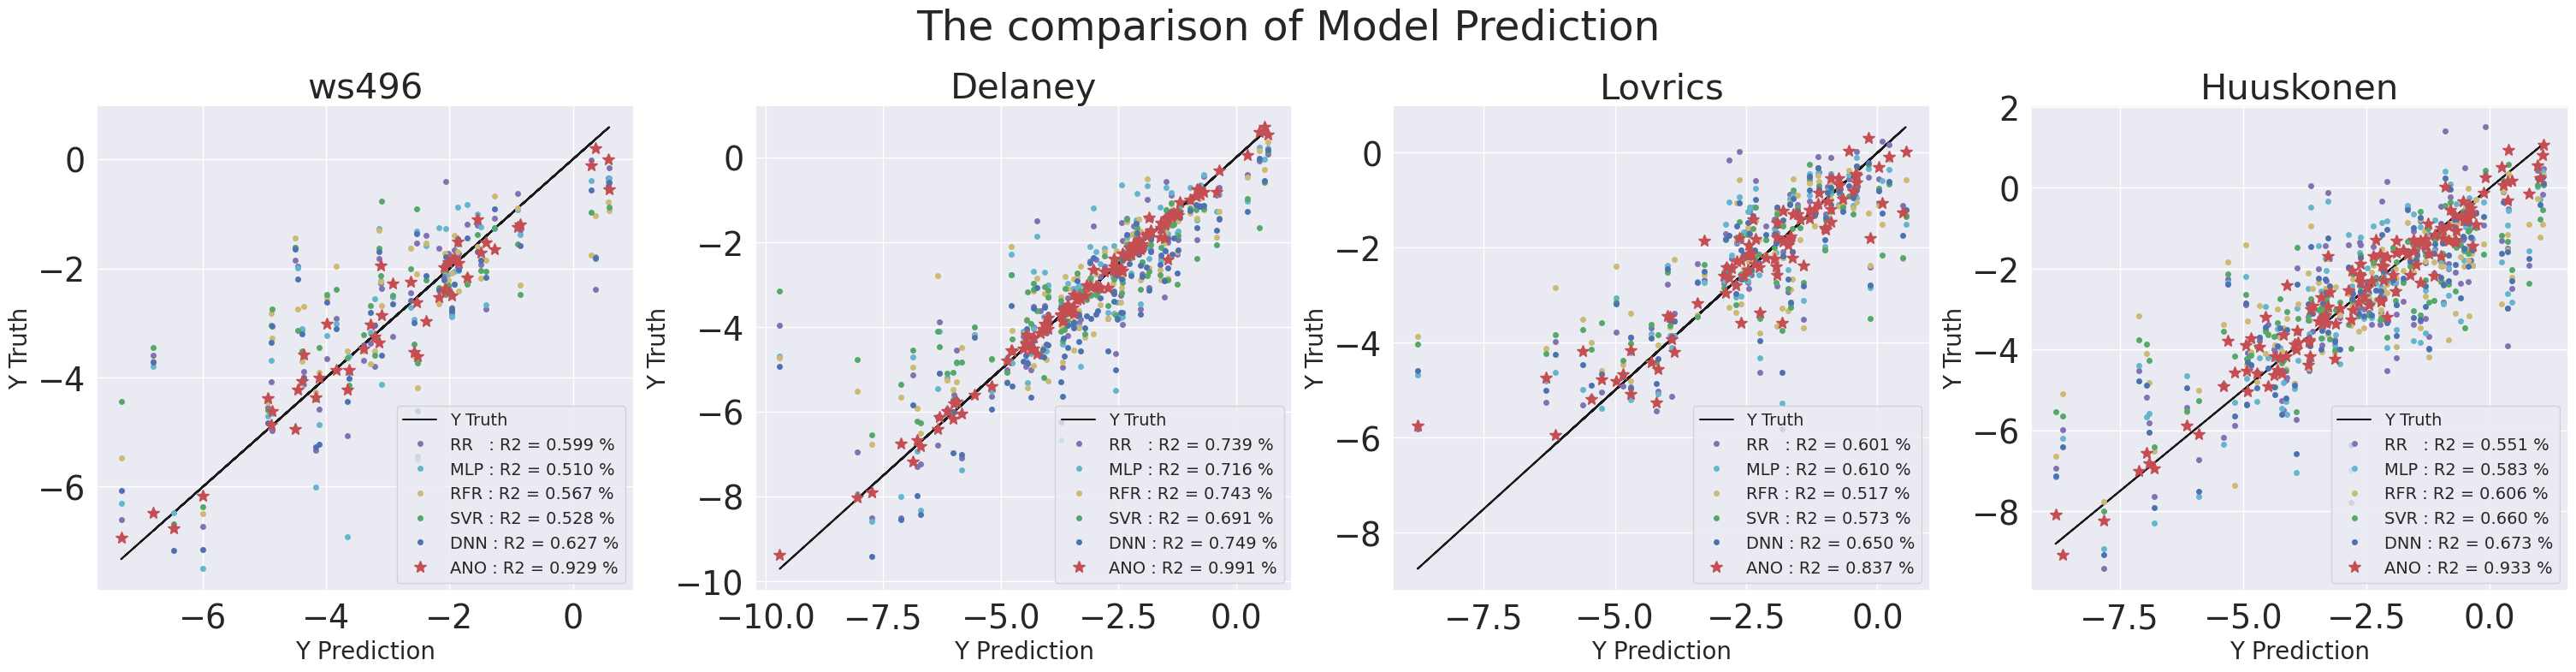

In [93]:
def vis_res(res_datasets):
    fig = plt.figure(constrained_layout=True, figsize=(30, 7))
    fig.suptitle("The comparison of Model Prediction", fontsize=35, y=1.1)
    
    for i,k in enumerate(res_datasets):
        input = f'14{i+1}'
        ax = fig.add_subplot(int(input))
        ax.set_title(k[0],fontsize=30)
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,0],'k-', label='Y Truth')
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,1],'m.',markersize=8,label=f'{k[1].columns.values[1]}  : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,1])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,2],'c.',markersize=8,label=f'{k[1].columns.values[2]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,2])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,3],'y.',markersize=8,label=f'{k[1].columns.values[3]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,3])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,4],'g.',markersize=8,label=f'{k[1].columns.values[4]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,4])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,5],'b.',markersize=8,label=f'{k[1].columns.values[5]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,5])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,6],'r*',markersize=10,label=f'{k[1].columns.values[6]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,6])))
        ax.legend(loc=4, fontsize=14)
        ax.set_ylabel('Y Truth', fontsize=20)
        ax.set_xlabel('Y Prediction', fontsize=20)
    
    plt.savefig("model_prediction_compare1.png",dpi=300, bbox_inches='tight')
    plt.show()
vis_res(res_datasets)

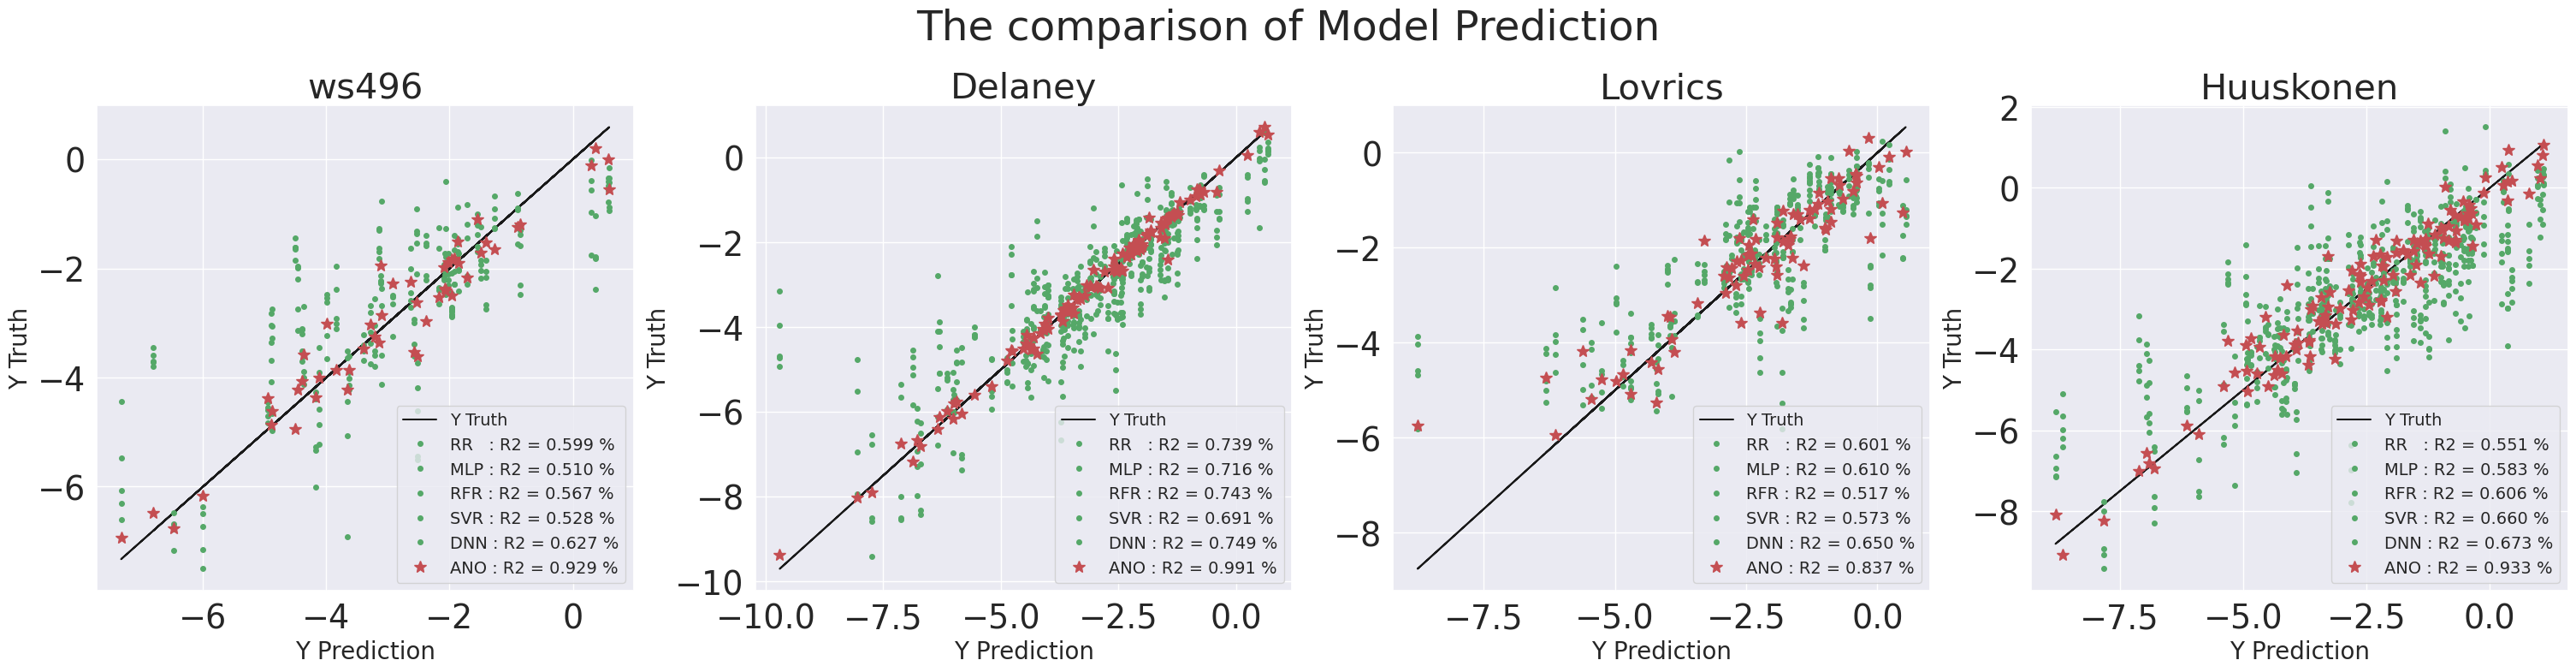

In [94]:
def vis_res(res_datasets):
    fig = plt.figure(constrained_layout=True, figsize=(30, 7))
    fig.suptitle("The comparison of Model Prediction", fontsize=35, y=1.1)
    
    for i,k in enumerate(res_datasets):
        input = f'14{i+1}'
        ax = fig.add_subplot(int(input))
        ax.set_title(k[0],fontsize=30)
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,0],'k-', label='Y Truth')
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,1],'g.',markersize=8,label=f'{k[1].columns.values[1]}  : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,1])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,2],'g.',markersize=8,label=f'{k[1].columns.values[2]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,2])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,3],'g.',markersize=8,label=f'{k[1].columns.values[3]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,3])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,4],'g.',markersize=8,label=f'{k[1].columns.values[4]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,4])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,5],'g.',markersize=8,label=f'{k[1].columns.values[5]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,5])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,6],'r*',markersize=10,label=f'{k[1].columns.values[6]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,6])))
        ax.legend(loc=4, fontsize=14)
        ax.set_ylabel('Y Truth', fontsize=20)
        ax.set_xlabel('Y Prediction', fontsize=20)
    
    plt.savefig("model_prediction_compare1.png",dpi=300, bbox_inches='tight')
    plt.show()
vis_res(res_datasets)

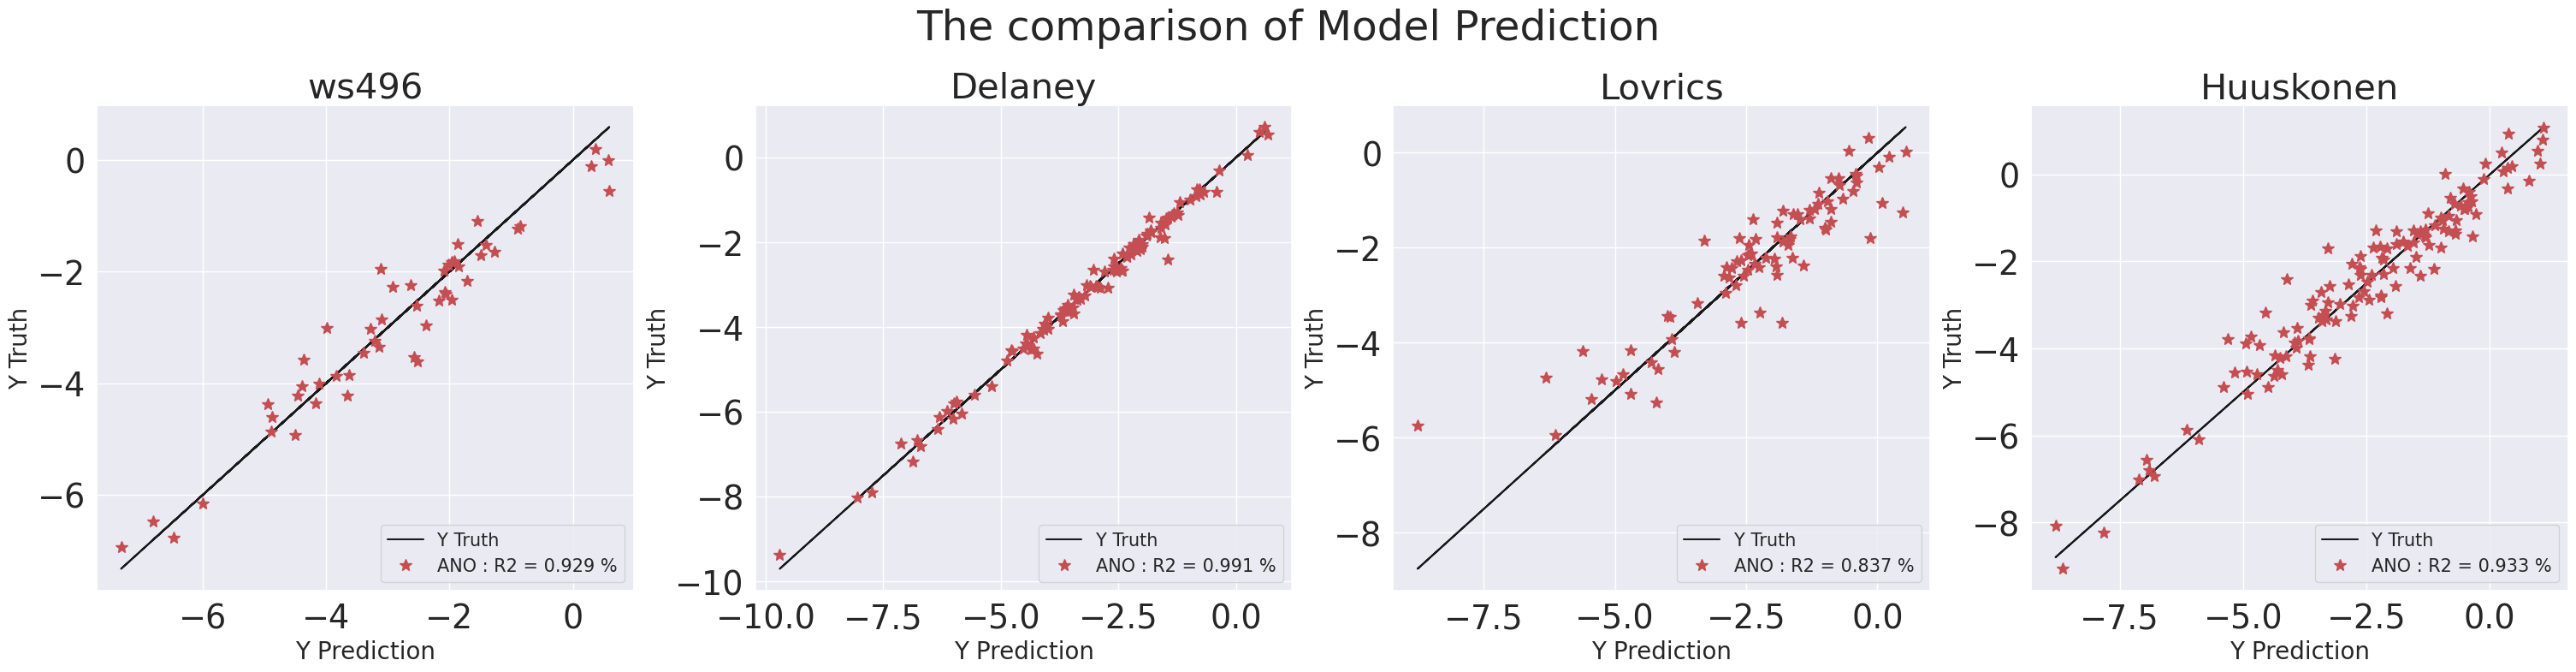

In [95]:
def vis_res(res_datasets):
    fig = plt.figure(constrained_layout=True, figsize=(30, 7))
    fig.suptitle("The comparison of Model Prediction", fontsize=35, y=1.1)
    
    for i,k in enumerate(res_datasets):
        input = f'14{i+1}'
        ax = fig.add_subplot(int(input))
        ax.set_title(k[0],fontsize=30)
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,0],'k-', label='Y Truth')
        # ax.plot(k[1].iloc[:,0],k[1].iloc[:,1],'m.',markersize=8,label=f'{k[1].columns.values[1]}  : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,1])))
        # ax.plot(k[1].iloc[:,0],k[1].iloc[:,2],'c.',markersize=8,label=f'{k[1].columns.values[2]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,2])))
        # ax.plot(k[1].iloc[:,0],k[1].iloc[:,3],'y.',markersize=8,label=f'{k[1].columns.values[3]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,3])))
        # ax.plot(k[1].iloc[:,0],k[1].iloc[:,4],'g.',markersize=8,label=f'{k[1].columns.values[4]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,4])))
        # ax.plot(k[1].iloc[:,0],k[1].iloc[:,5],'b.',markersize=8,label=f'{k[1].columns.values[5]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,5])))
        ax.plot(k[1].iloc[:,0],k[1].iloc[:,6],'r*',markersize=10,label=f'{k[1].columns.values[6]} : R2 = %.3f %%' % (r2_score(k[1].iloc[:,0],k[1].iloc[:,6])))
        ax.legend(loc=4, fontsize=15)
        ax.set_ylabel('Y Truth', fontsize=20)
        ax.set_xlabel('Y Prediction', fontsize=20)
    
    plt.savefig("model_prediction_compare1.png",dpi=300, bbox_inches='tight')
    plt.show()
vis_res(res_datasets)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


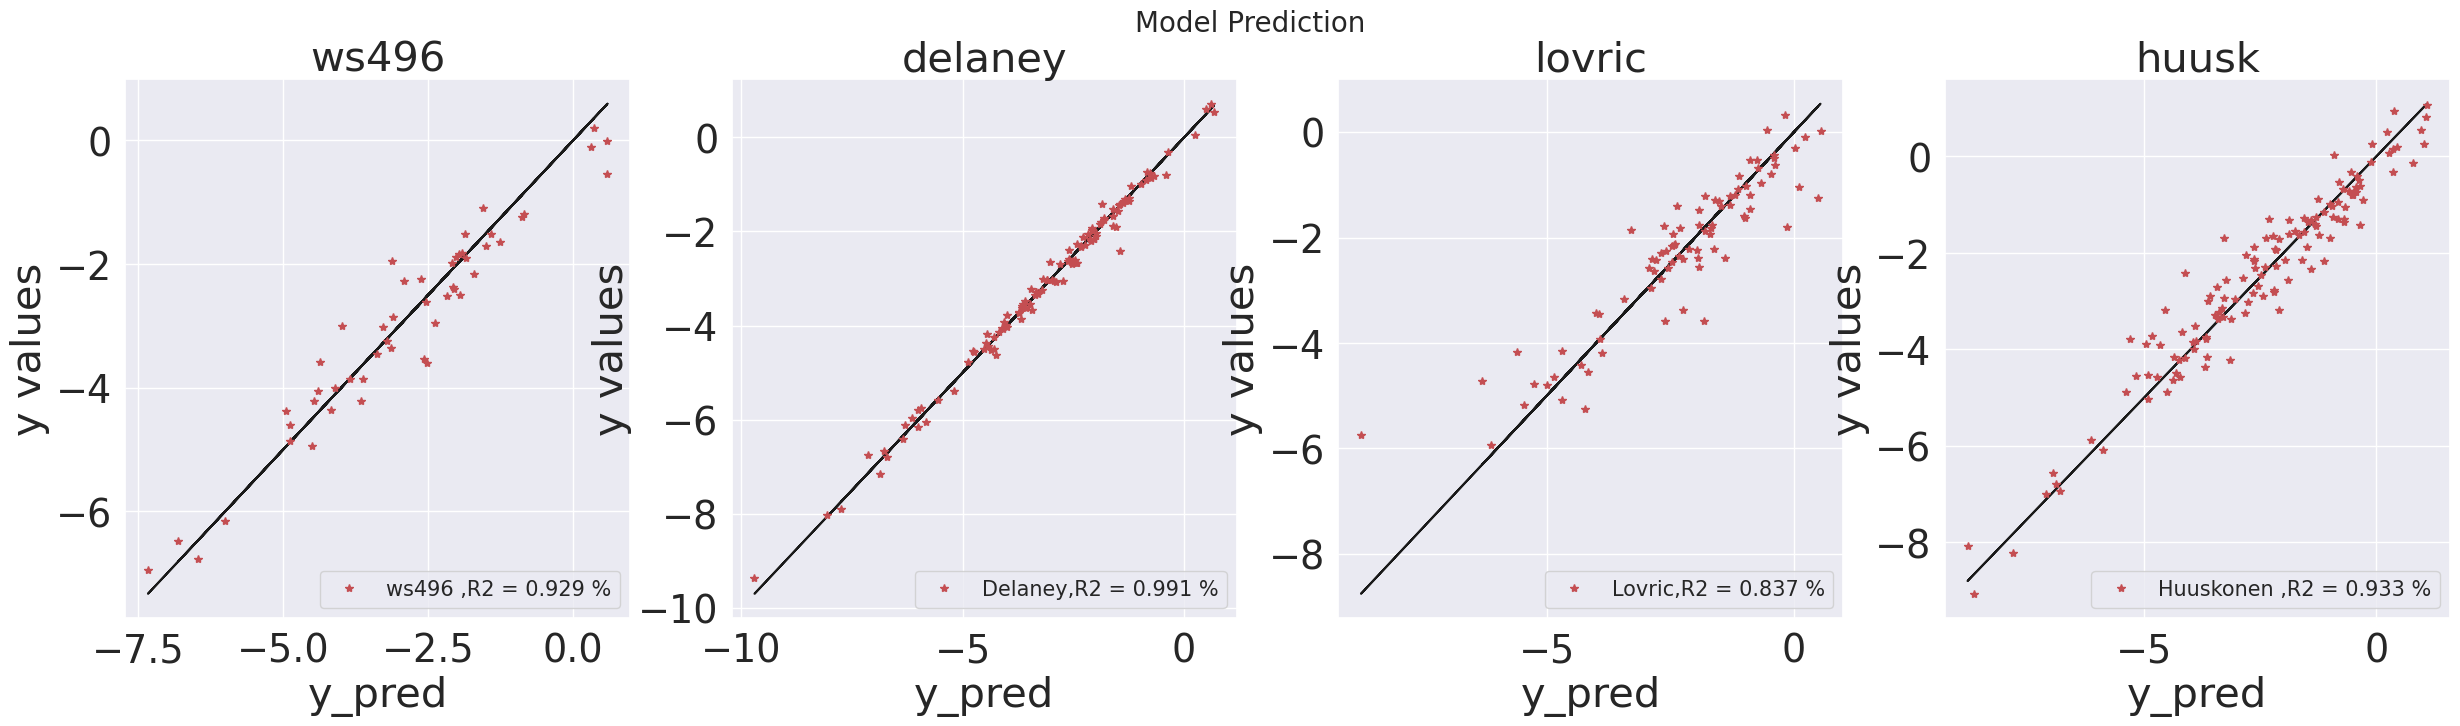

In [96]:
plt.figure(figsize=(30,7))
plt.suptitle('Model Prediction', fontsize=20)
plt.subplot(1,4,1)
plt.title('ws496')
plt.plot(yte_fws,yte_fws,'k-')
plt.plot(yte_fws,model_fws.predict(xte_fws),'r*',label='%s,R2 = %.3f %%' % ('ws496 ',r2_score(yte_fws,model_fws.predict(xte_fws))))
plt.legend(loc=4,fontsize=15)
plt.ylabel('y values')
plt.xlabel('y_pred')

plt.subplot(1,4,2)
plt.title('delaney')
plt.plot(yte_fde,yte_fde,'k-')
plt.plot(yte_fde,model_fde.predict(xte_fde),'r*',label='%s,R2 = %.3f %%' % ('Delaney',r2_score(yte_fde,model_fde.predict(xte_fde))))
plt.legend(loc=4,fontsize=15)
plt.ylabel('y values')
plt.xlabel('y_pred')

plt.subplot(1,4,3)
plt.title('lovric')
plt.plot(yte_flo,yte_flo,'k-')
plt.plot(yte_flo,model_flo.predict(xte_flo),'r*',label='%s,R2 = %.3f %%' % ('Lovric',r2_score(yte_flo,model_flo.predict(xte_flo))))
plt.legend(loc=4,fontsize=15)
plt.ylabel('y values')
plt.xlabel('y_pred')

plt.subplot(1,4,4)
plt.title('huusk')
plt.plot(yte_fhu,yte_fhu,'k-')
plt.plot(yte_fhu,model_fhu.predict(xte_fhu),'r*',label='%s,R2 = %.3f %%' % ('Huuskonen ',r2_score(yte_fhu,model_fhu.predict(xte_fhu))))
plt.legend(loc=4,fontsize=15)
plt.ylabel('y values')
plt.xlabel('y_pred')

plt.show()

In [103]:
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")
def implement_corr(fea, name):
    inputs_fea = fea.drop(columns=["SMILES"])
    columns_legnth = len(inputs_fea.columns)-1
    input_columns = list(inputs_fea.columns)
    sns.set(rc = {'figure.figsize':(20,20)})
    plt.subplots_adjust(top=1.5)
    os.makedirs(f"./result_corr/{name}", exist_ok=True)
    for i in range(columns_legnth):
        ##############
        g = sns.jointplot(data=inputs_fea, x=inputs_fea[f"{input_columns[0]}"], y=inputs_fea[f"{input_columns[i+1]}"], color='b')
        g.fig.suptitle(f'The Correlation between {input_columns[i+1]} and {input_columns[0]} (only dots)')
        g.fig.subplots_adjust(top=0.95)
        plt.savefig(f'./result_corr/{name}/corr[{name}]_logS_with_{input_columns[i+1]}_only_dots.png', dpi=300)
        ############################
        ############################
        g = sns.jointplot(data=inputs_fea, x=inputs_fea[f"{input_columns[0]}"], y=inputs_fea[f"{input_columns[i+1]}"], color='b')
        g.plot_joint(sns.kdeplot, color="g", zorder=0, levels=6)
        g.plot_marginals(sns.rugplot, color="g", height=-.15, clip_on=False)
        g.fig.suptitle(f'The Correlation between {input_columns[i+1]} and {input_columns[0]}')
        g.fig.subplots_adjust(top=0.95)
        plt.savefig(f'./result_corr/{name}/corr[{name}]_logS_with_{input_columns[i+1]}.png', dpi=300)
        ##############
        plt.close()
    plt.close()

<Figure size 2000x2000 with 0 Axes>

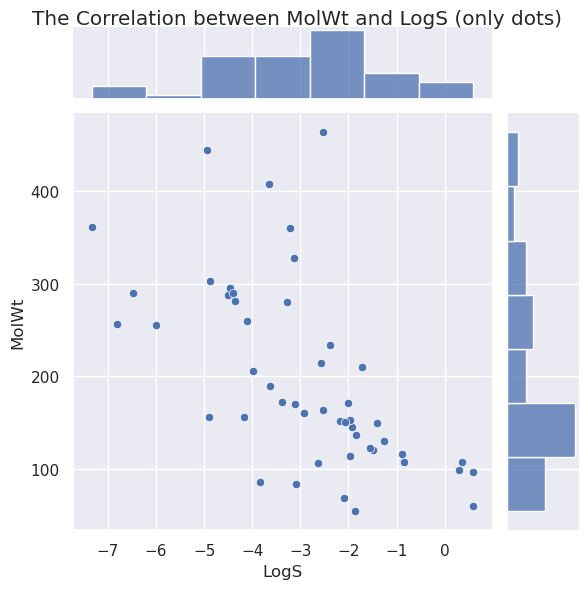

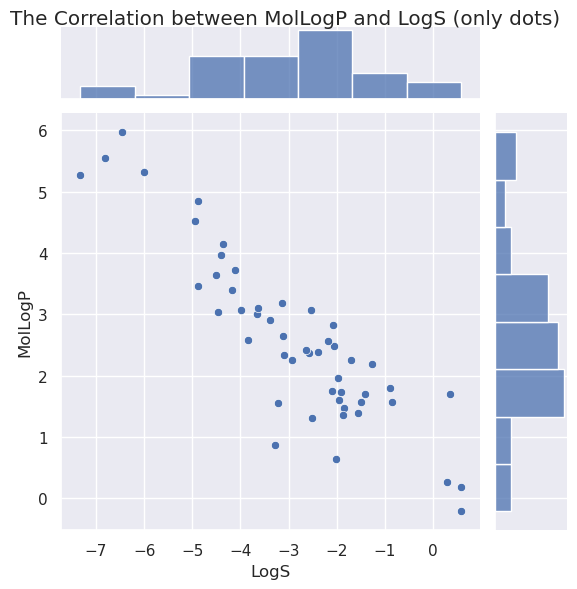

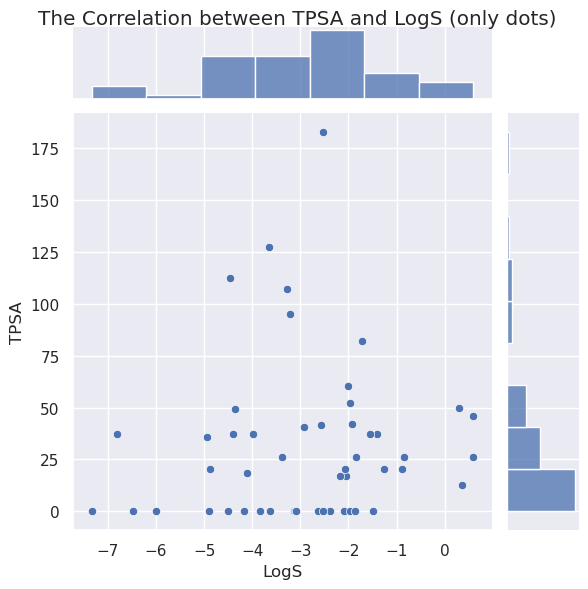

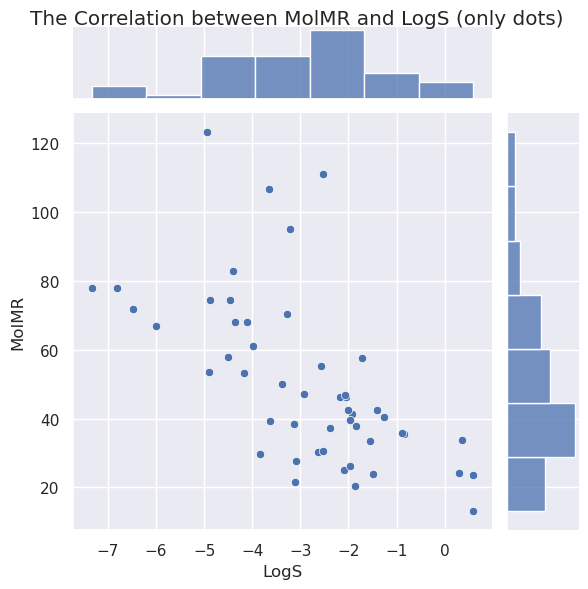

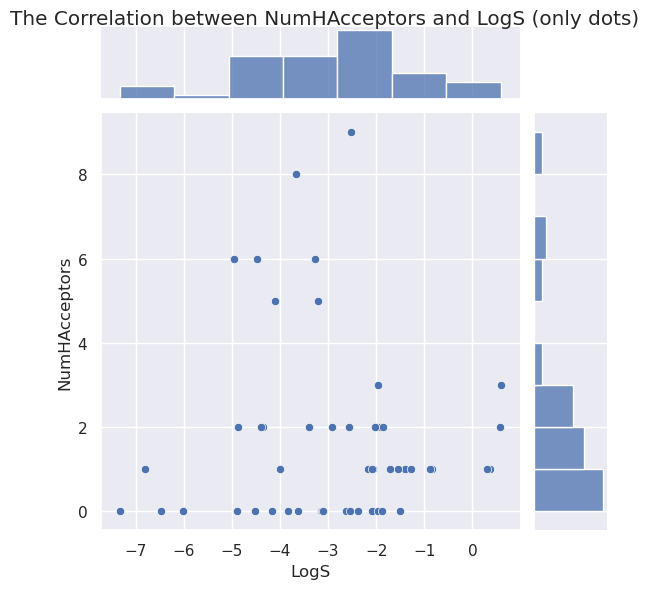

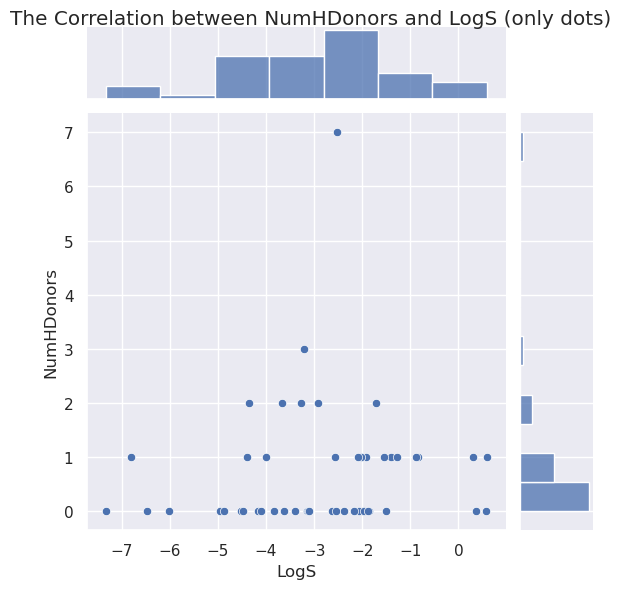

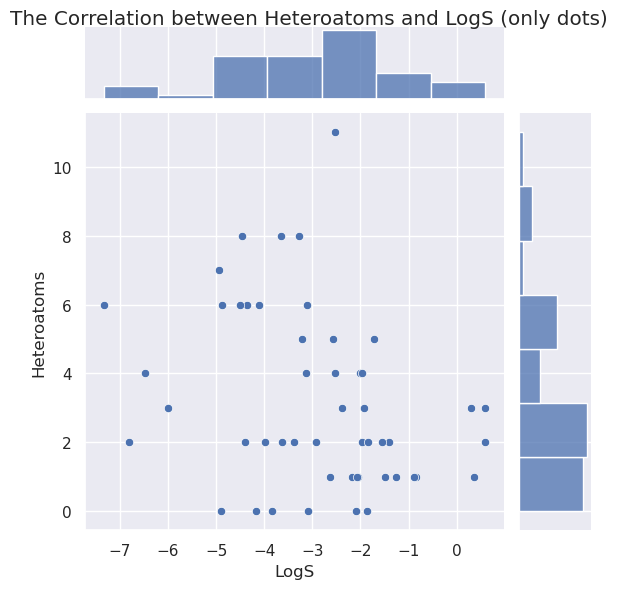

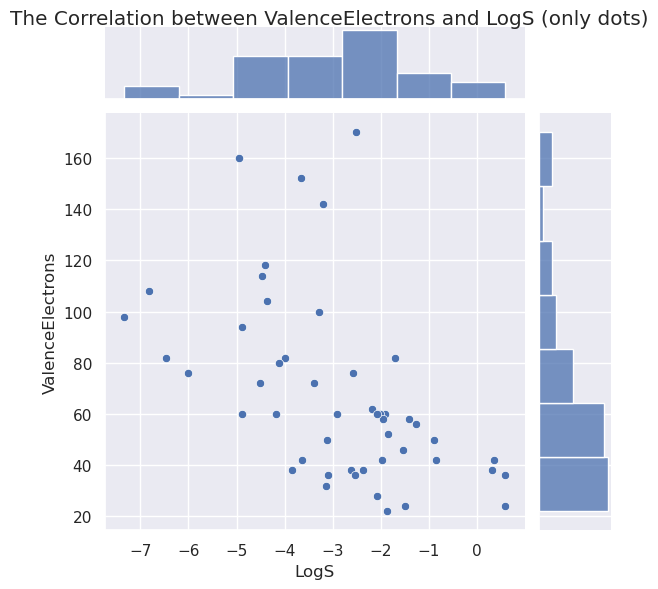

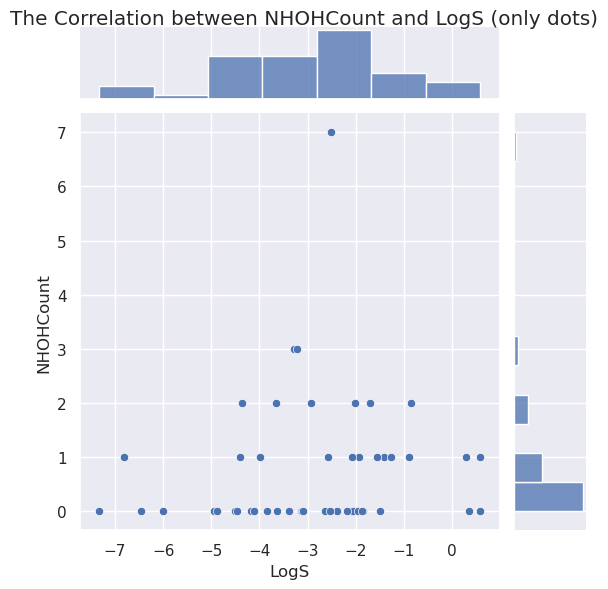

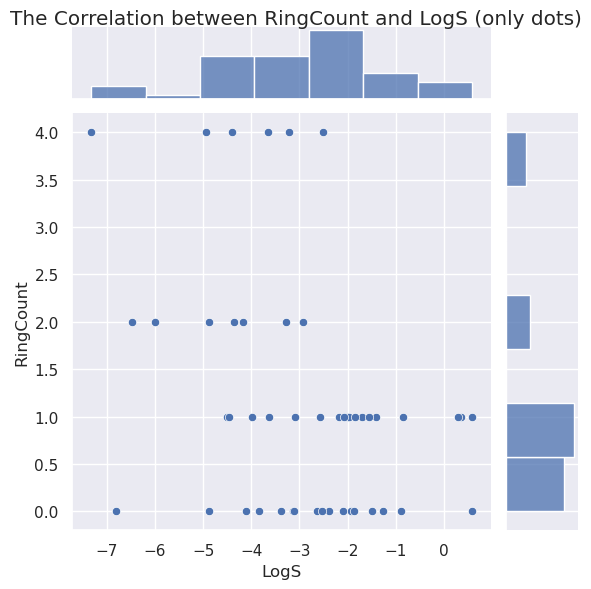

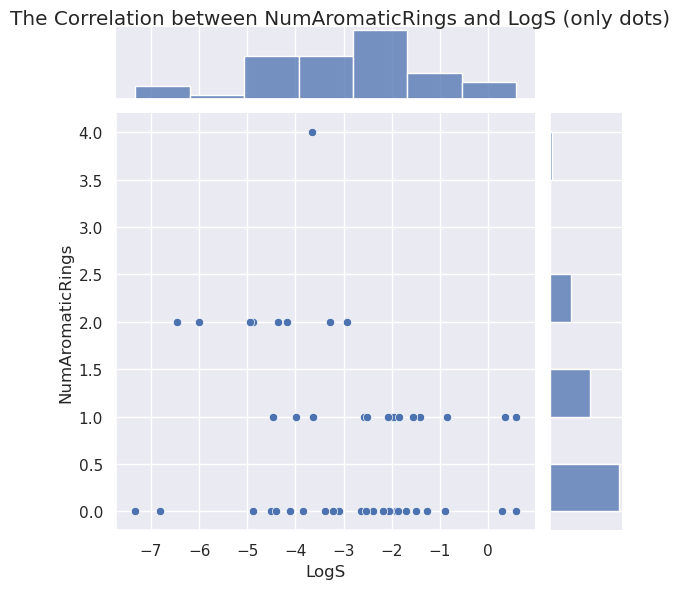

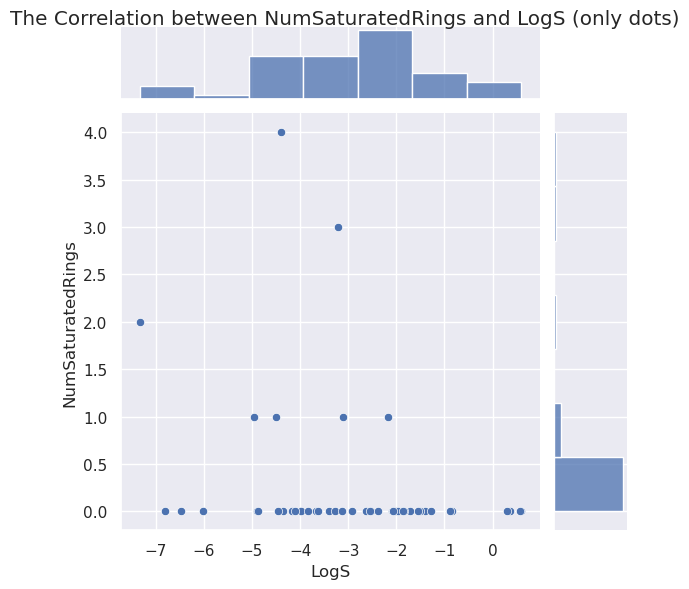

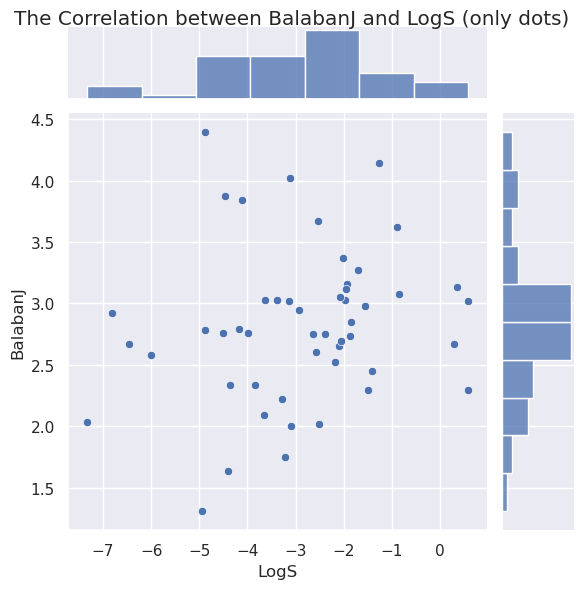

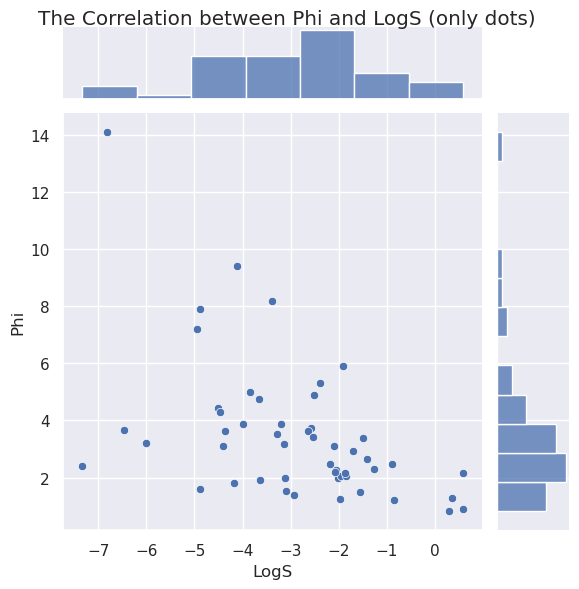

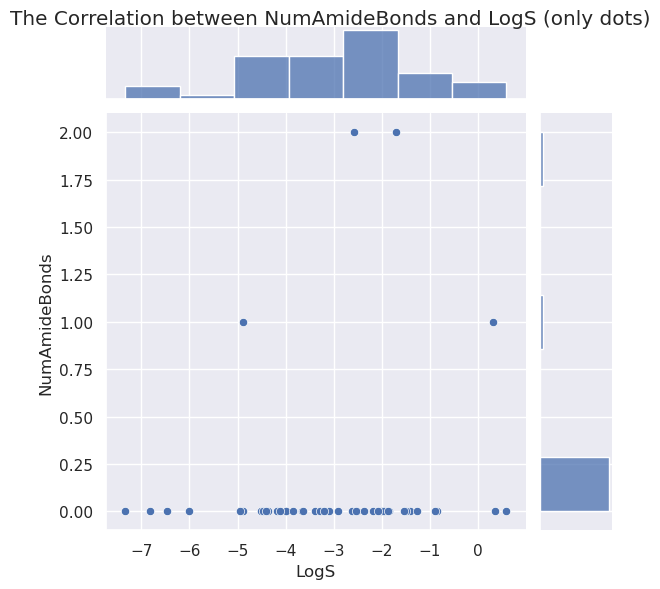

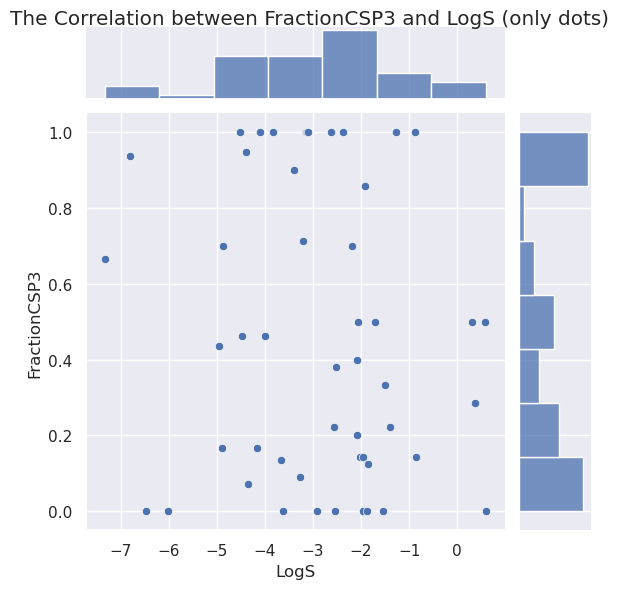

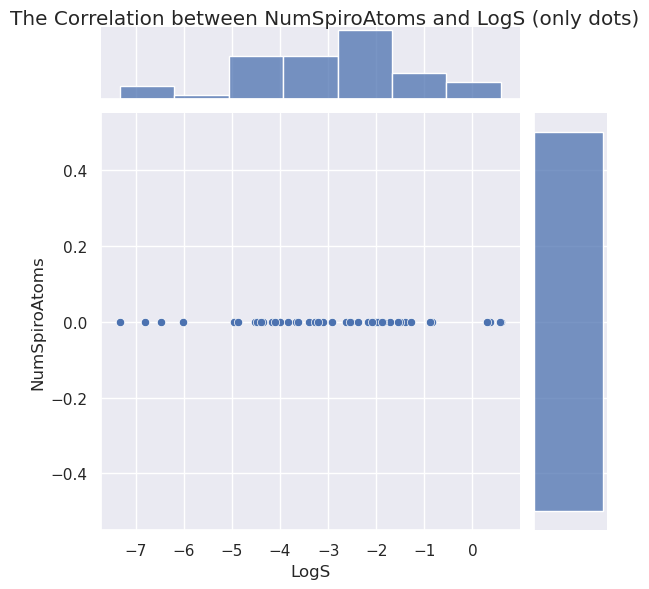

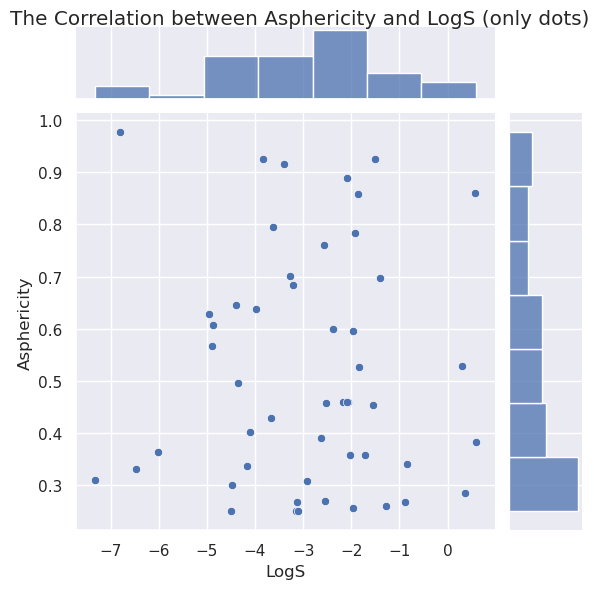

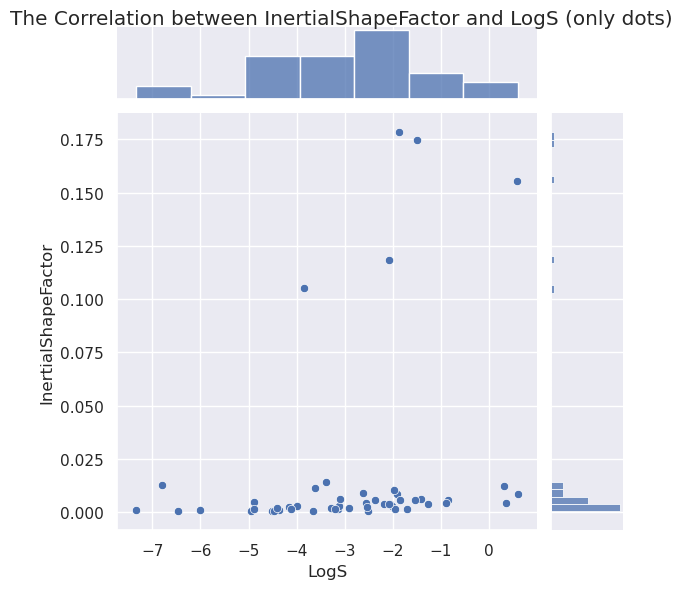

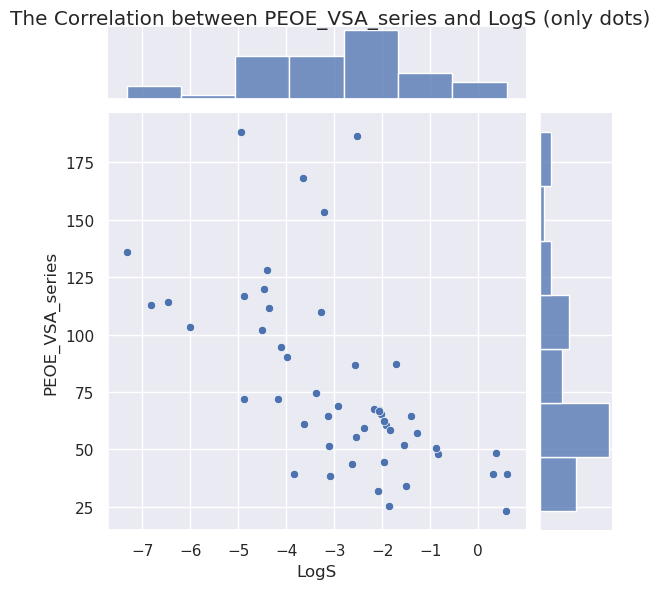

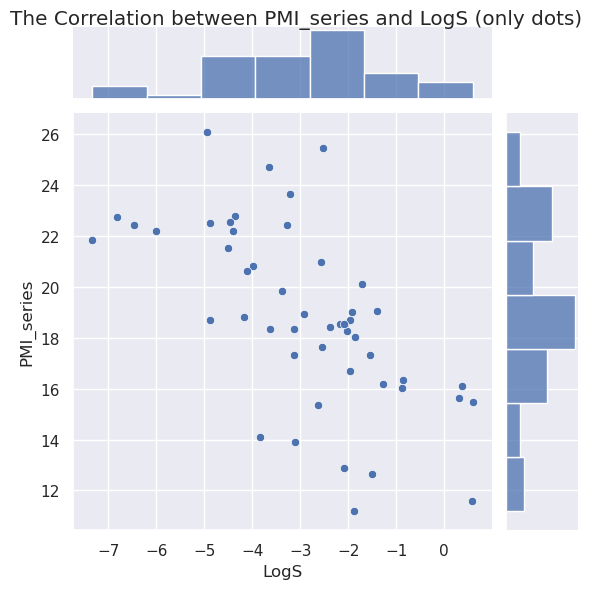

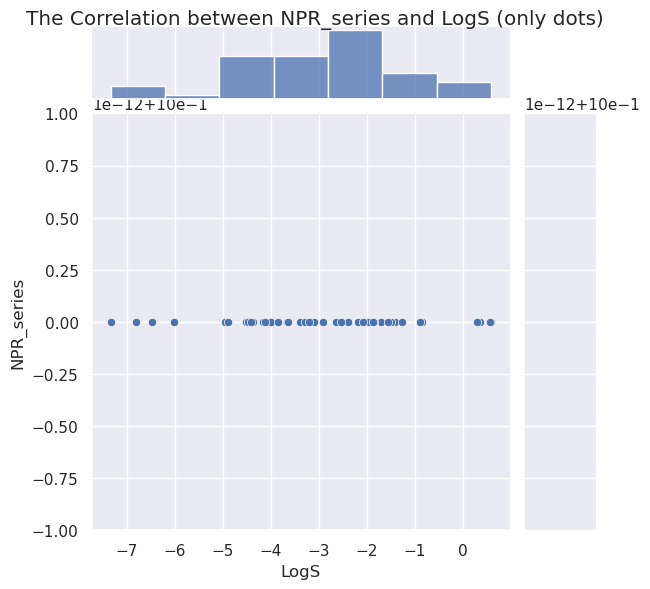

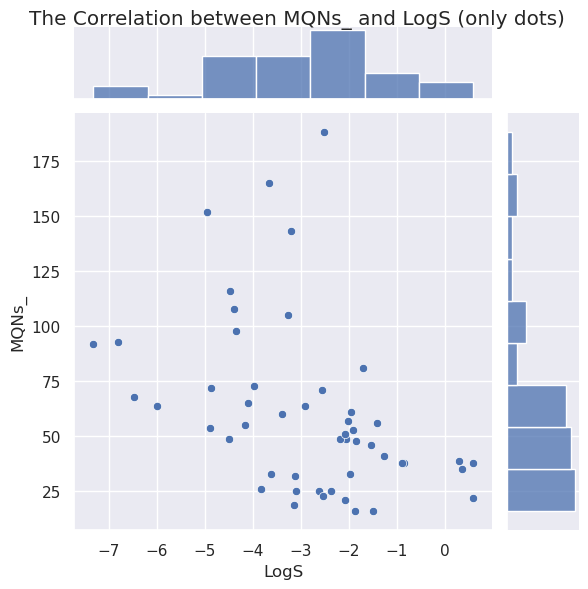

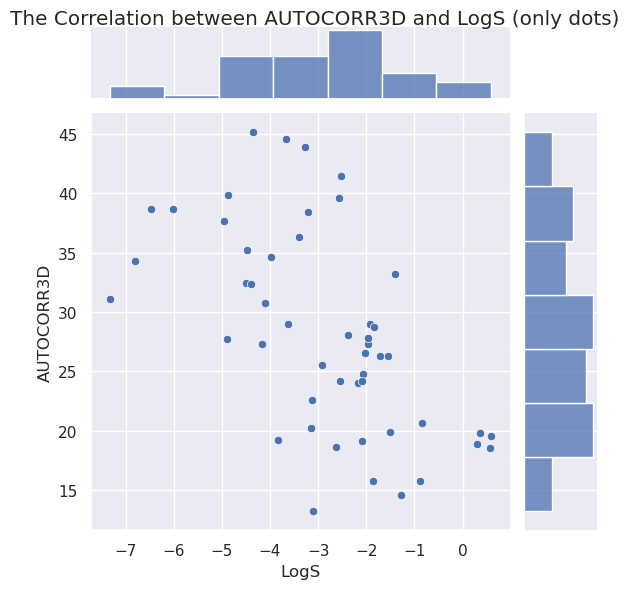

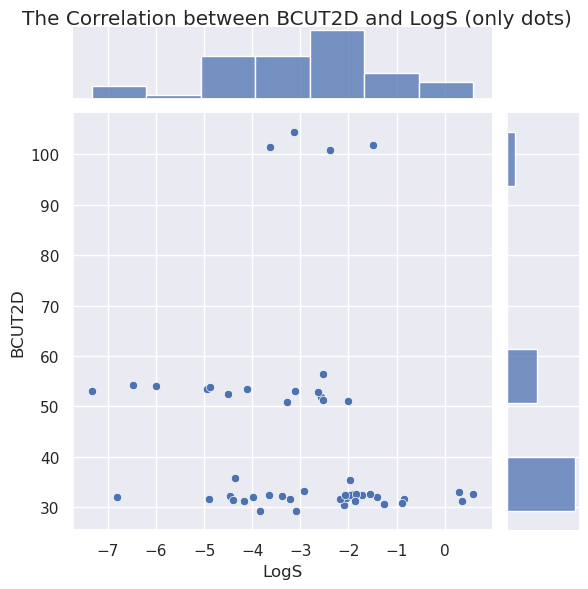

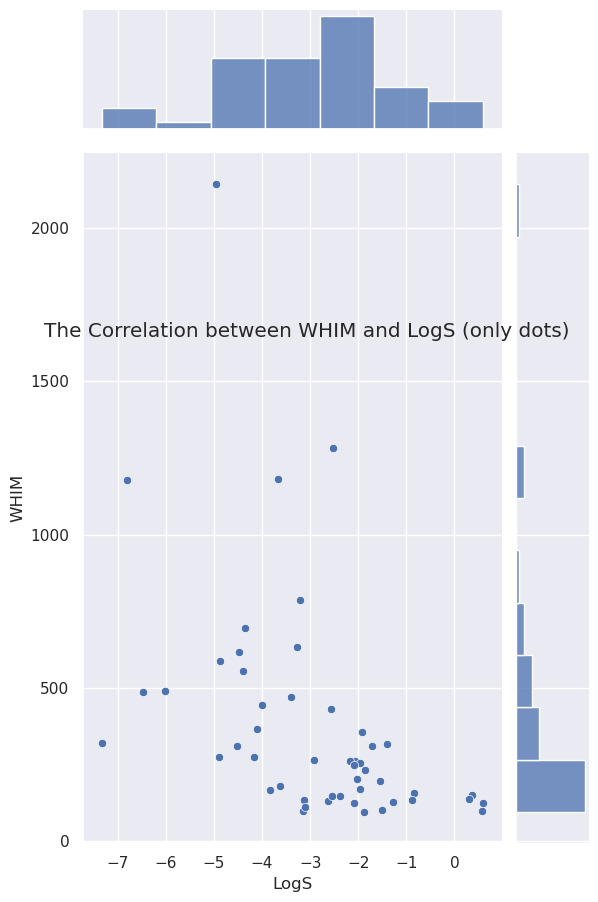

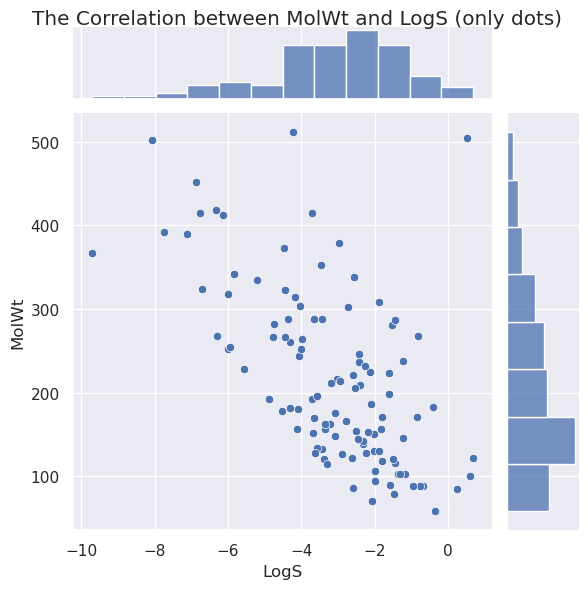

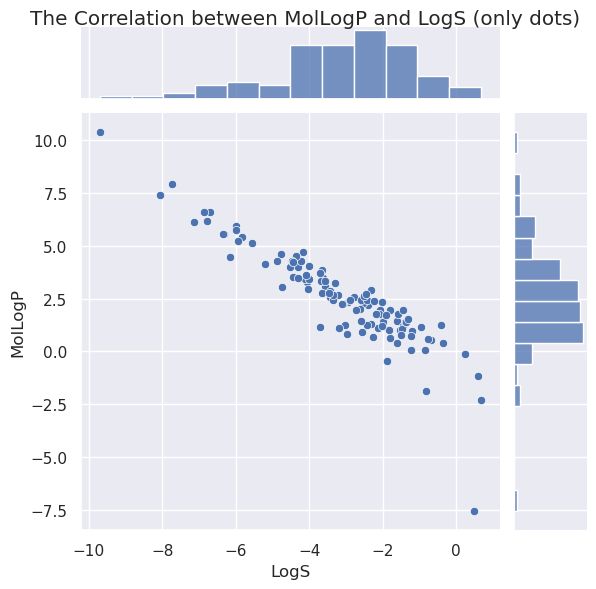

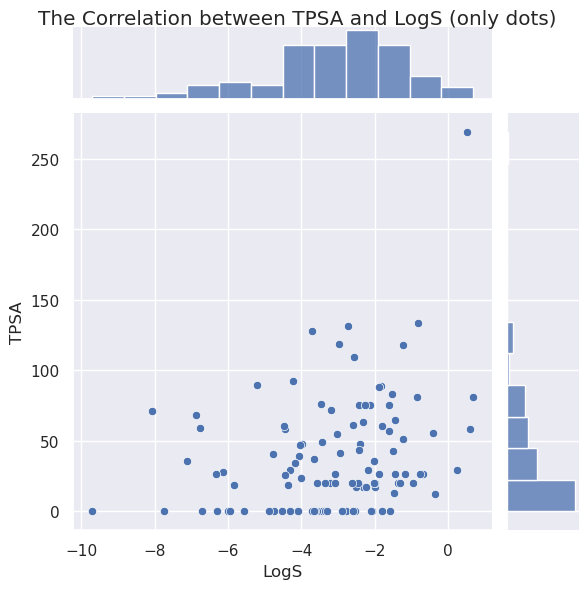

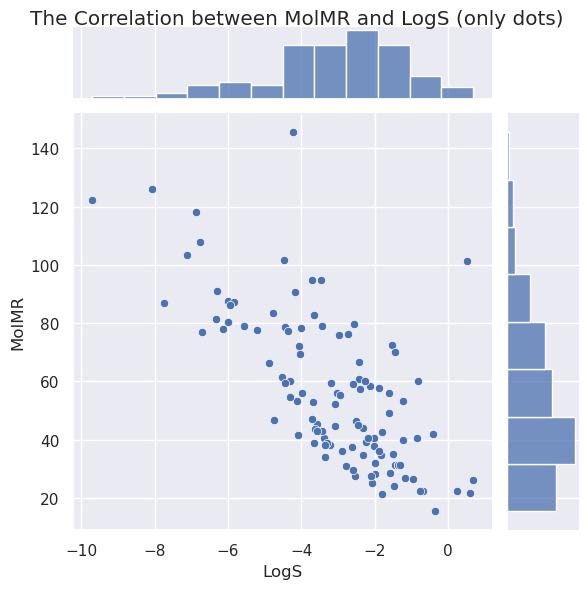

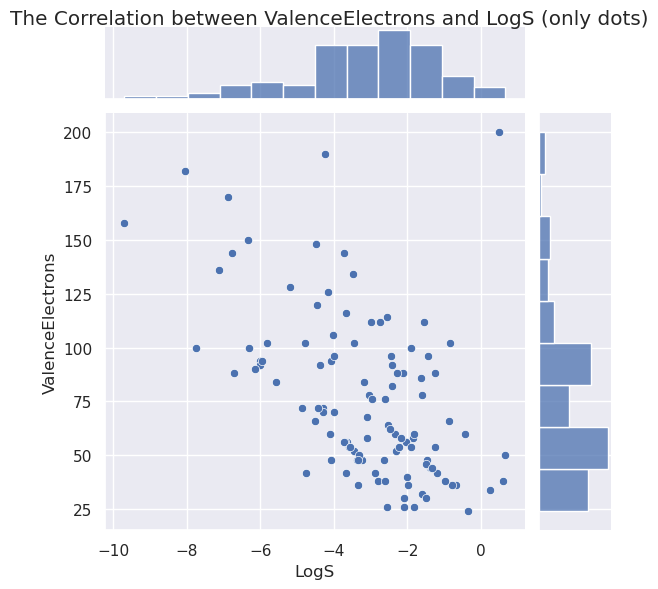

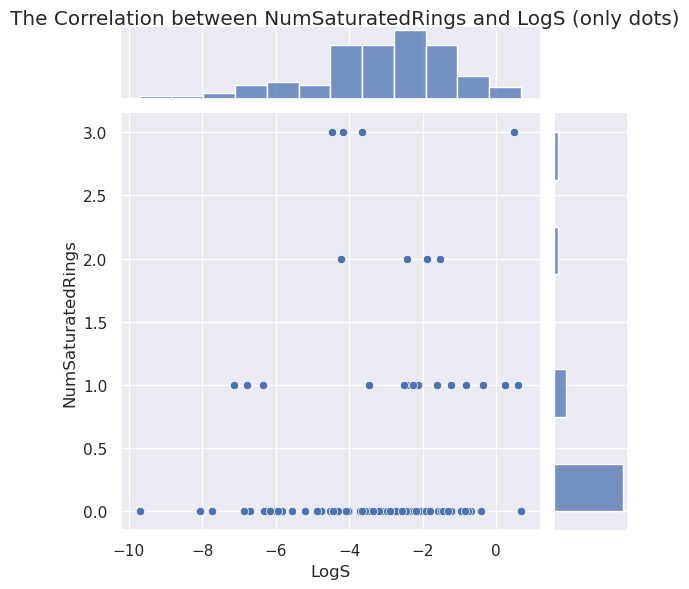

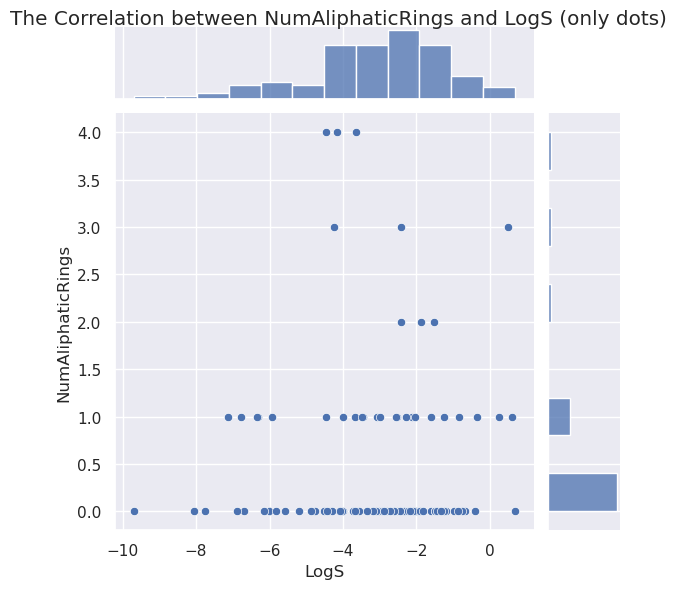

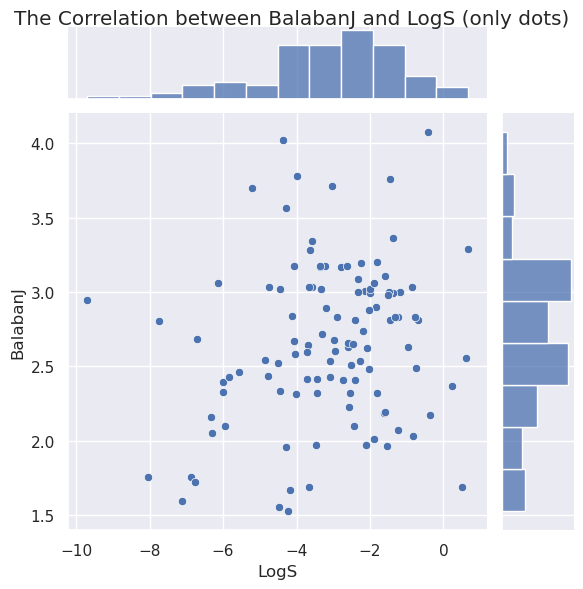

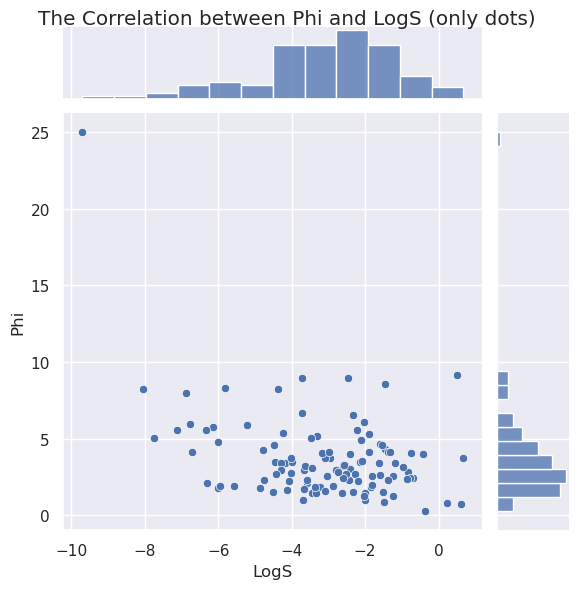

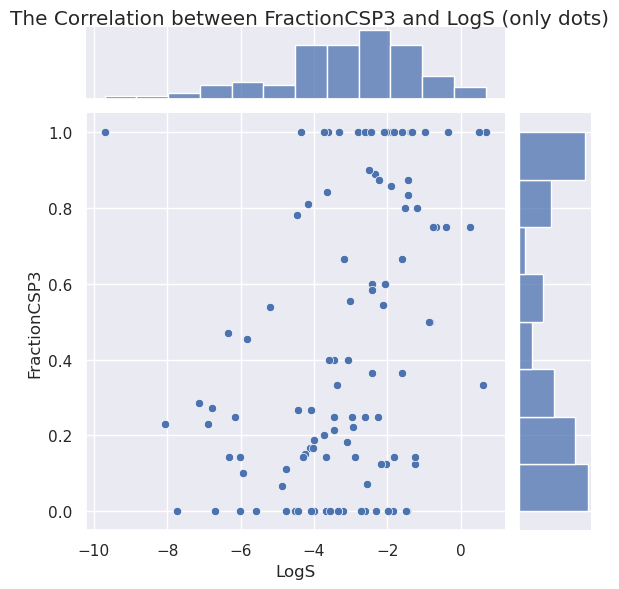

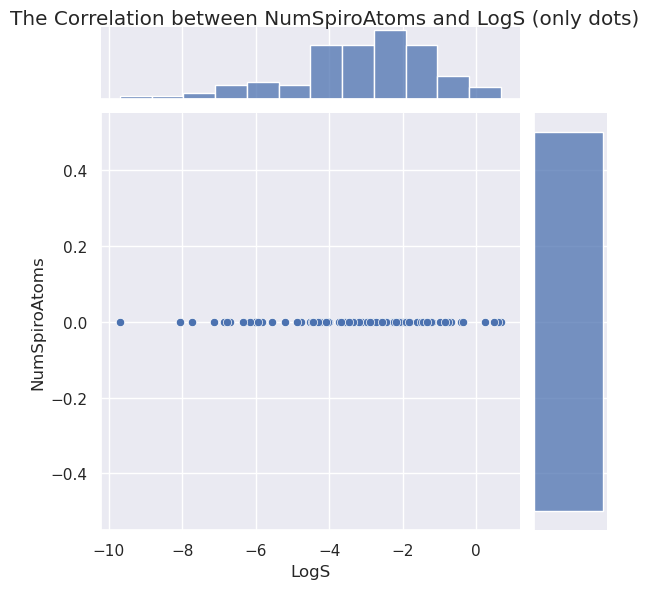

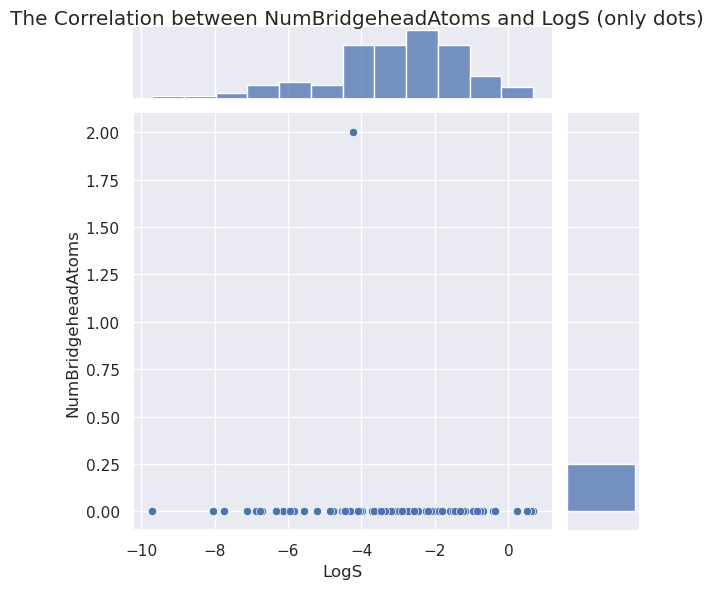

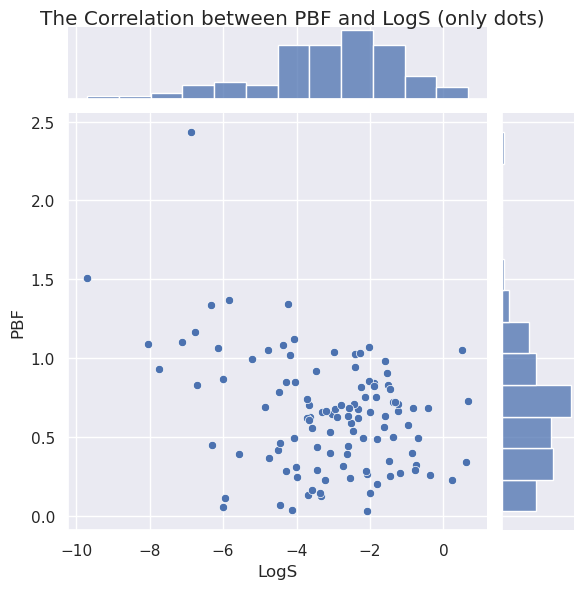

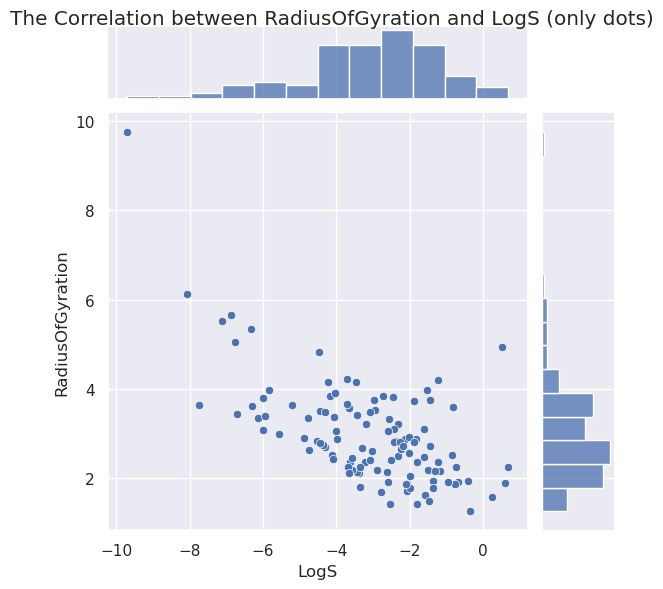

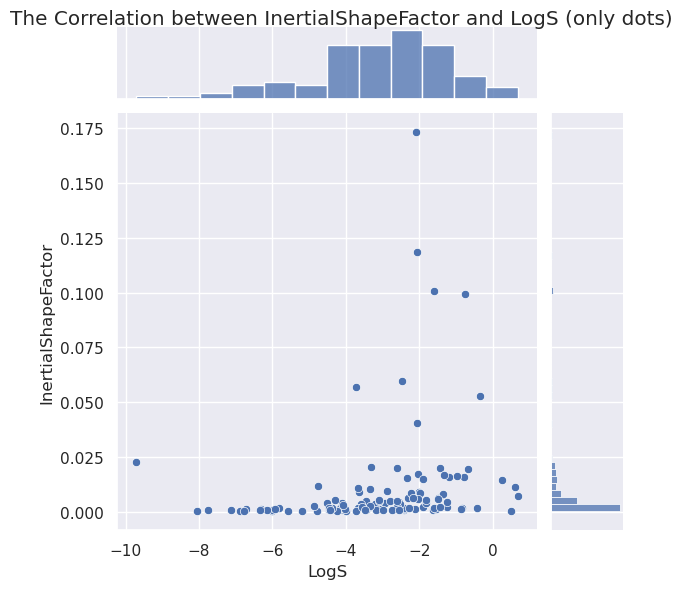

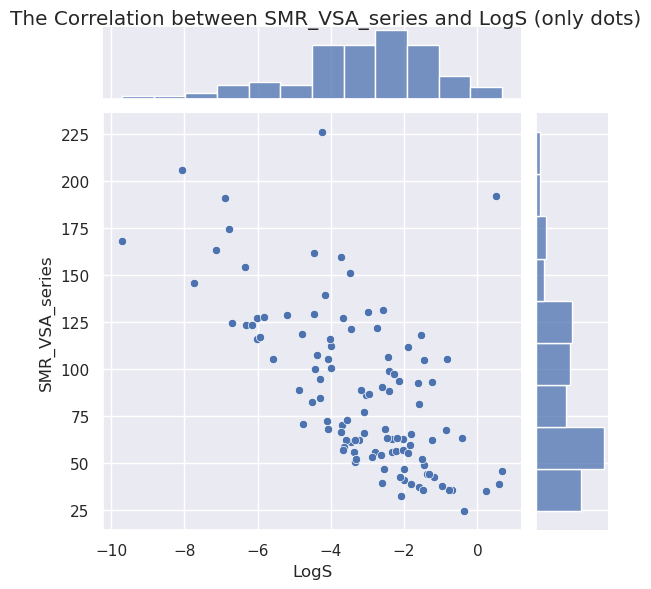

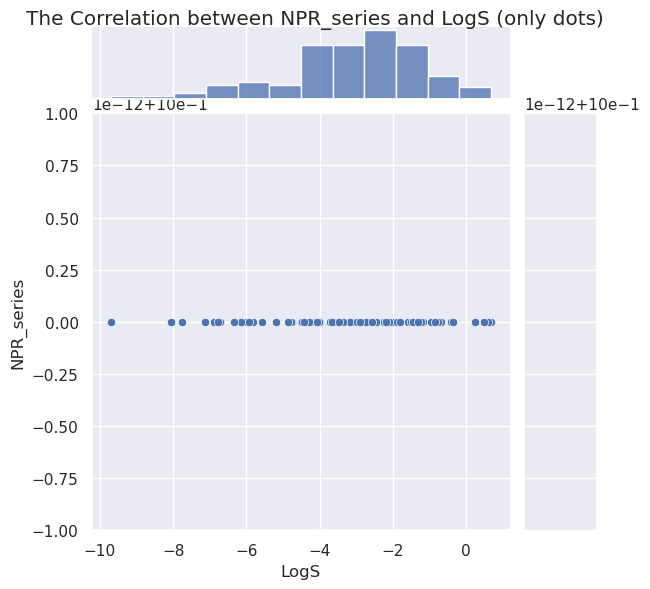

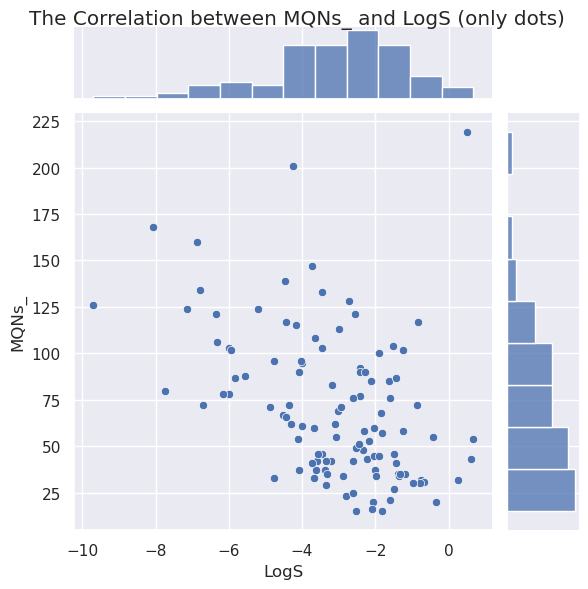

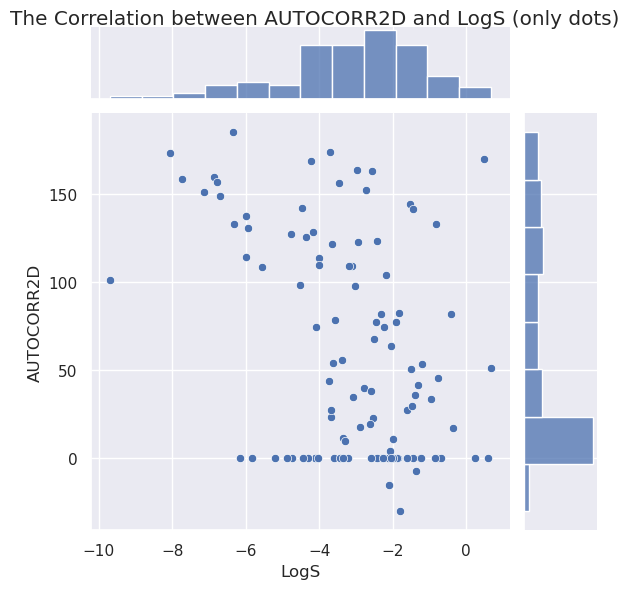

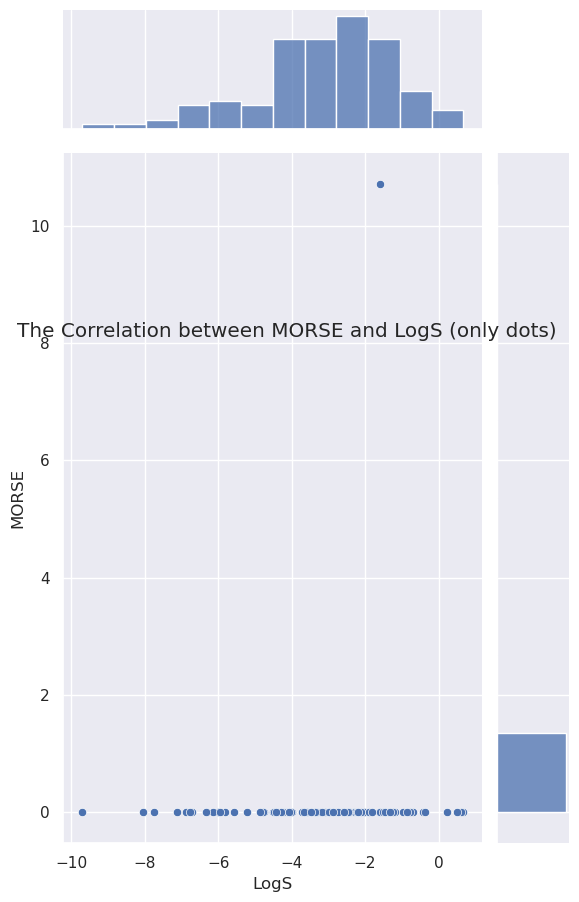

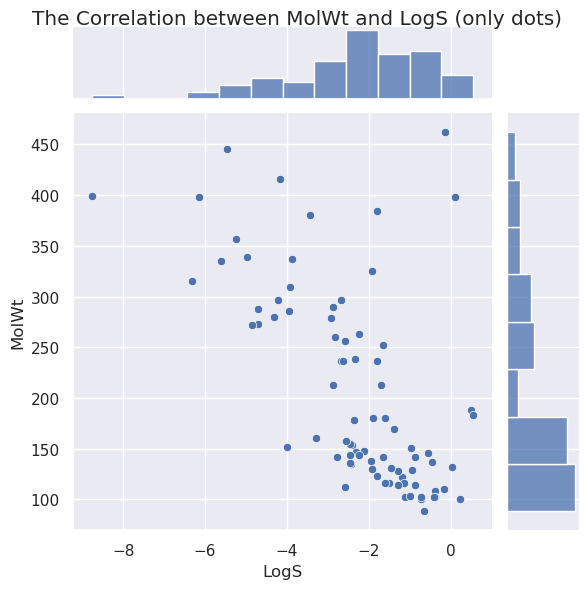

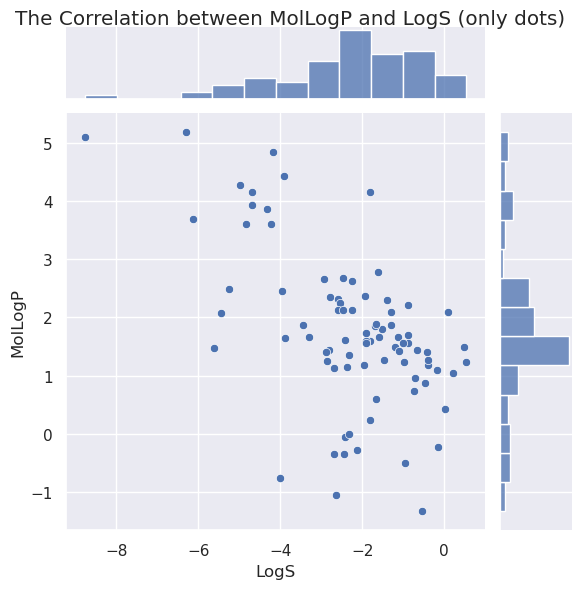

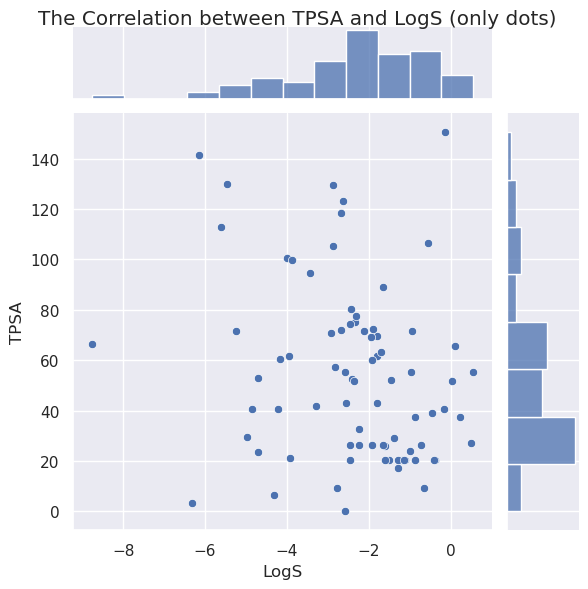

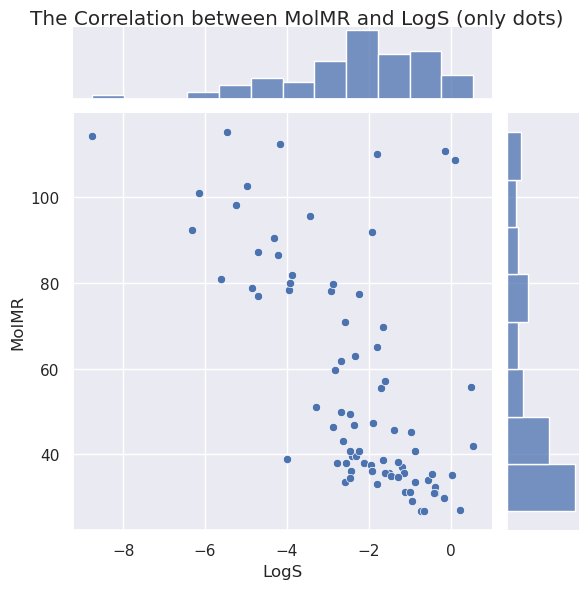

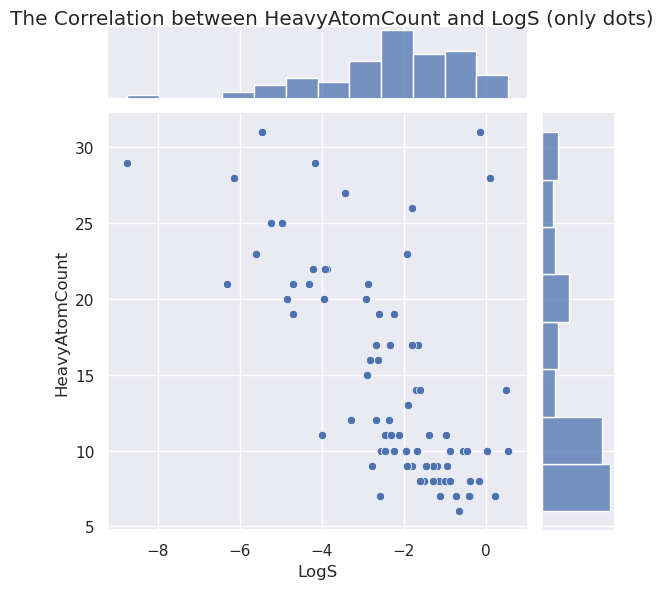

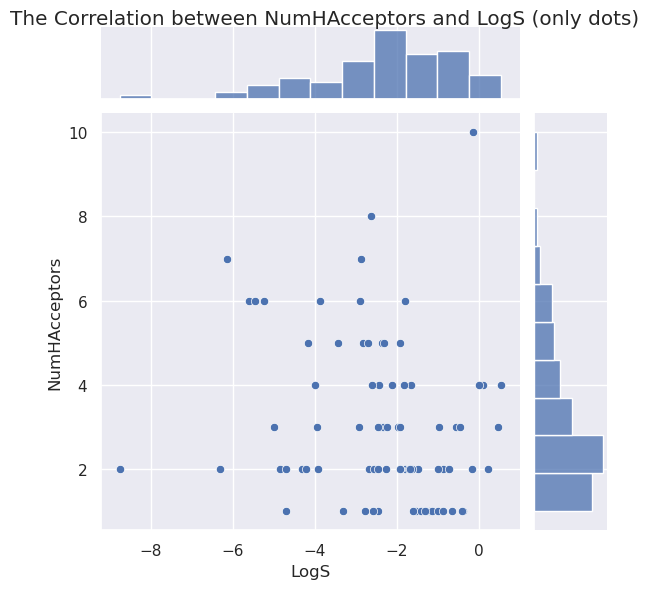

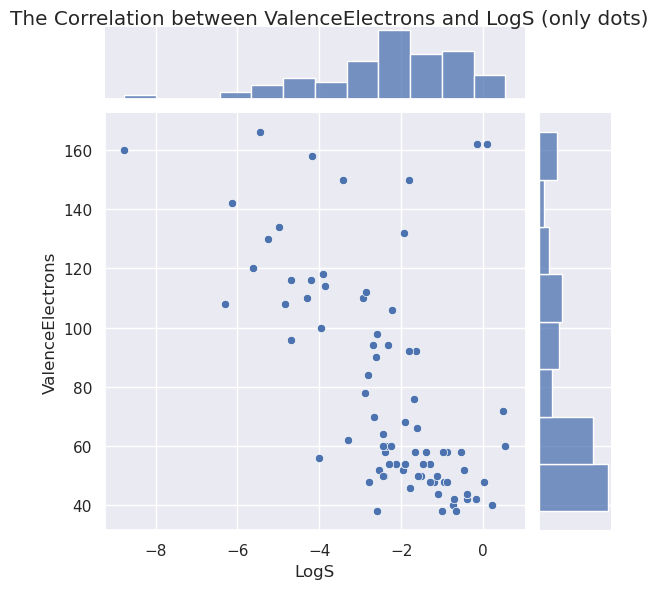

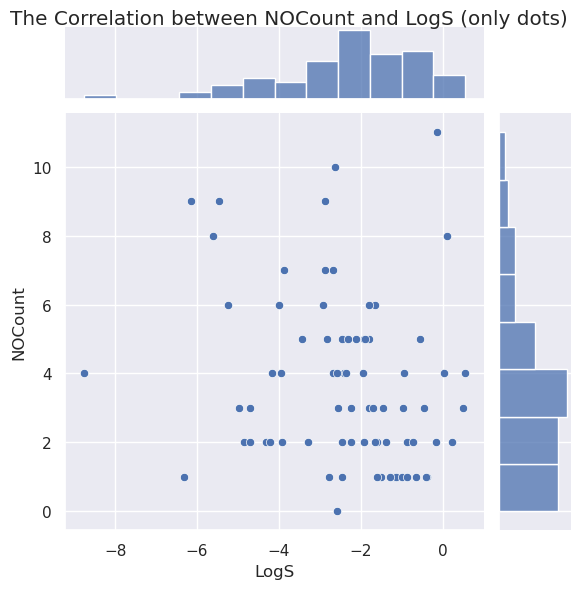

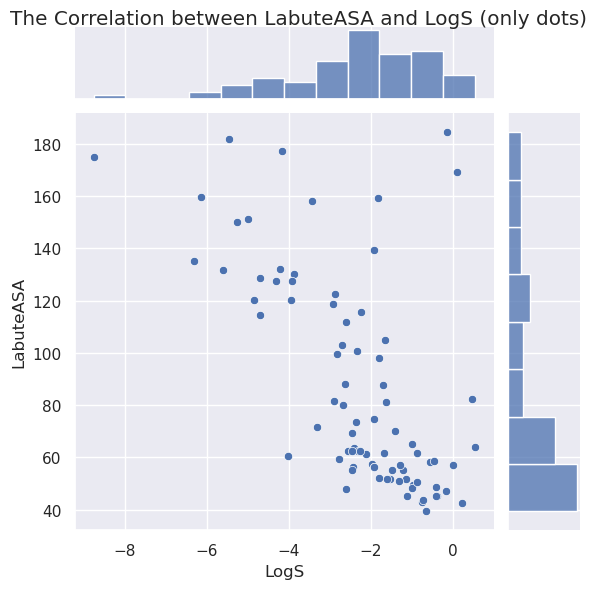

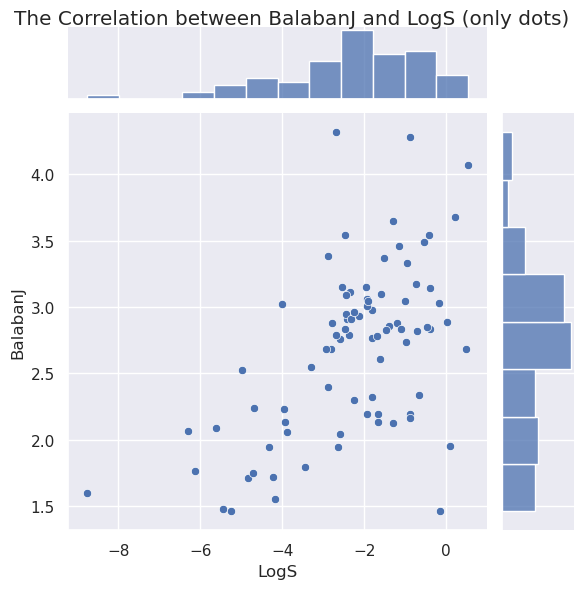

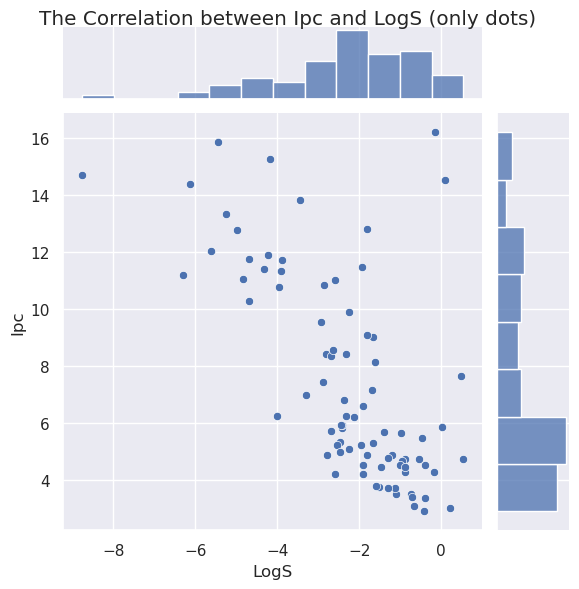

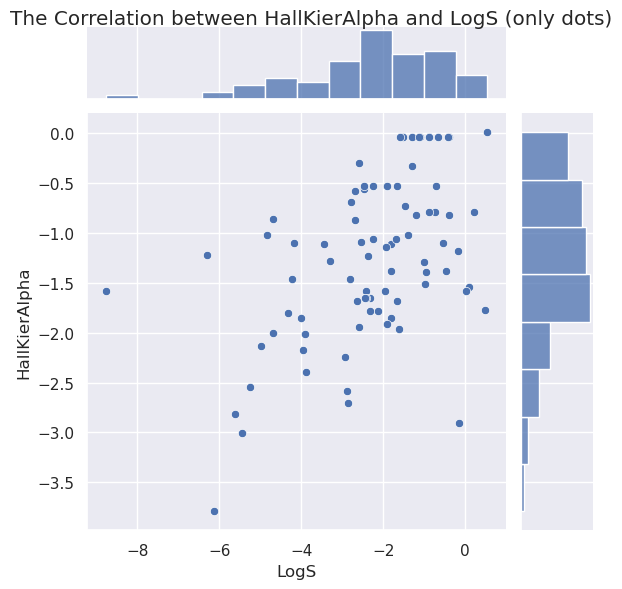

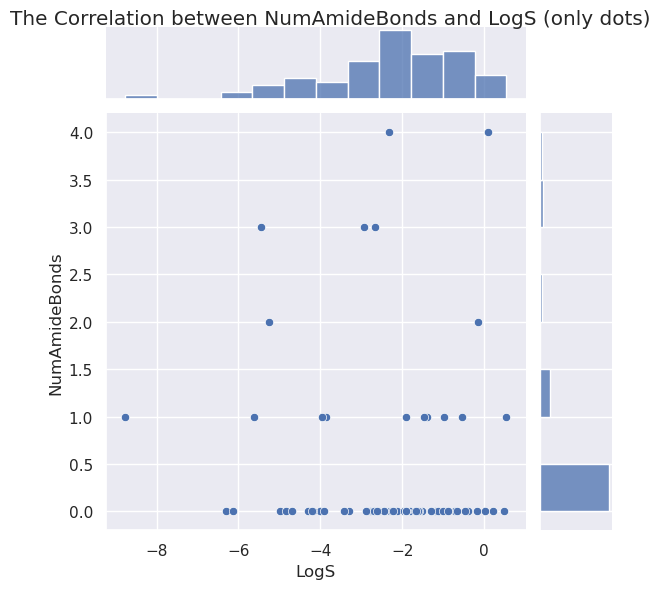

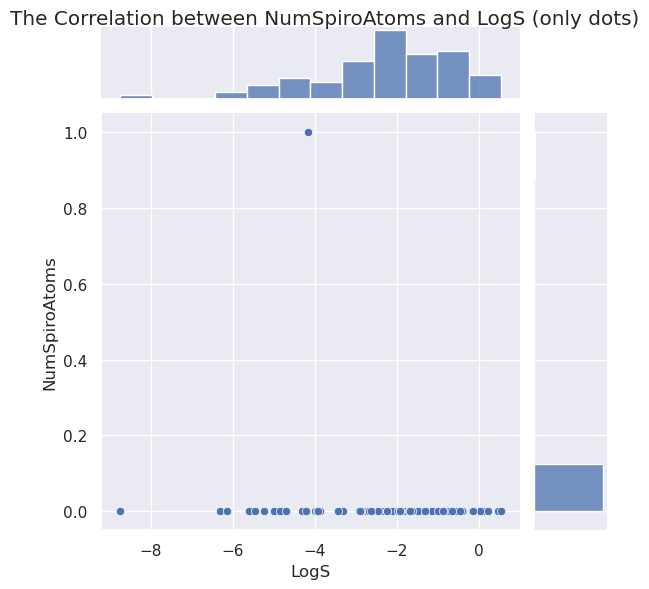

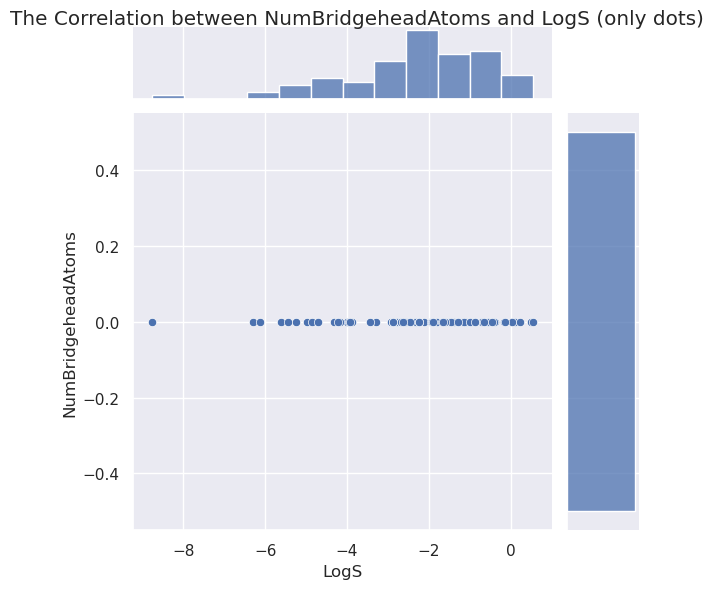

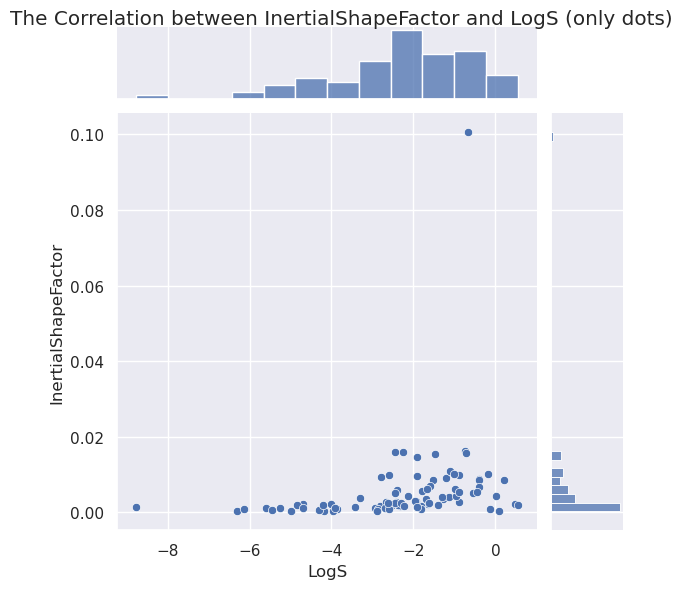

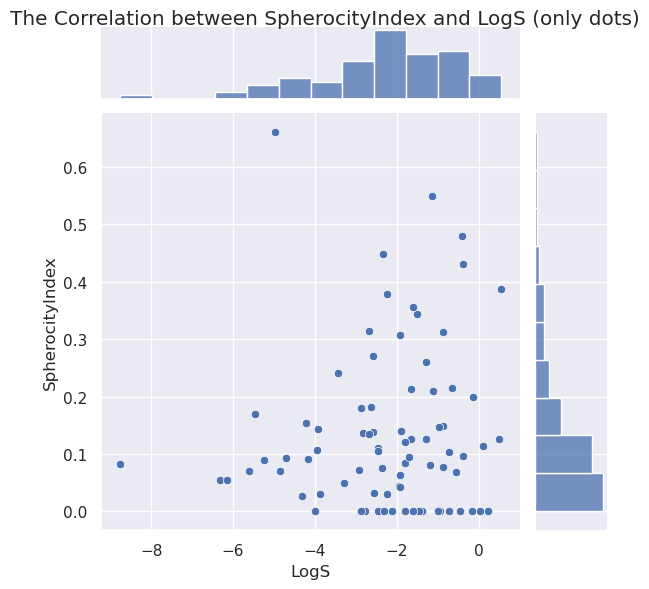

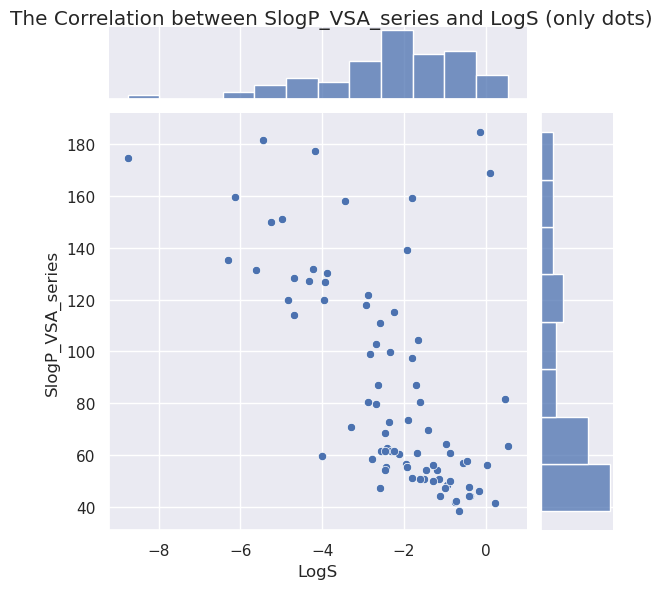

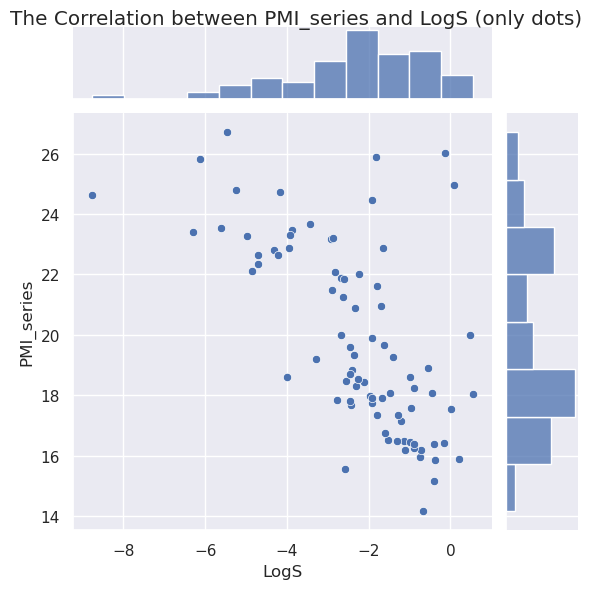

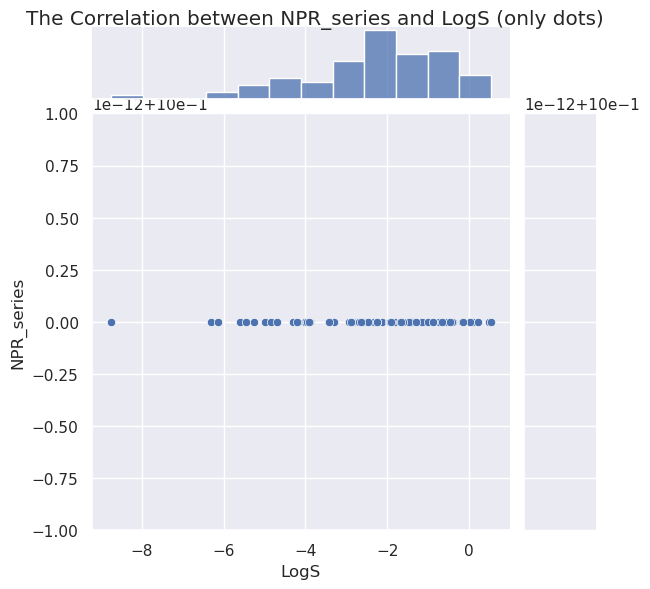

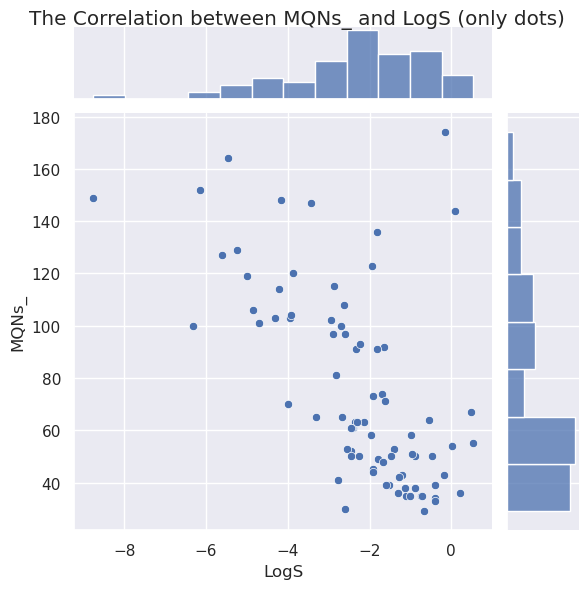

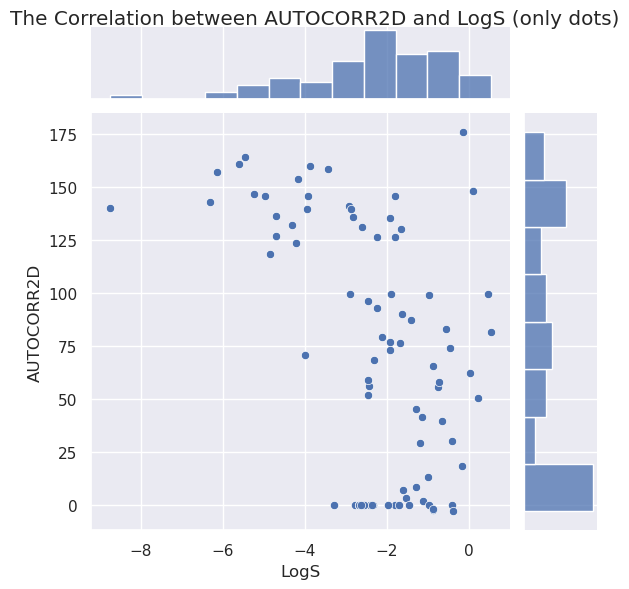

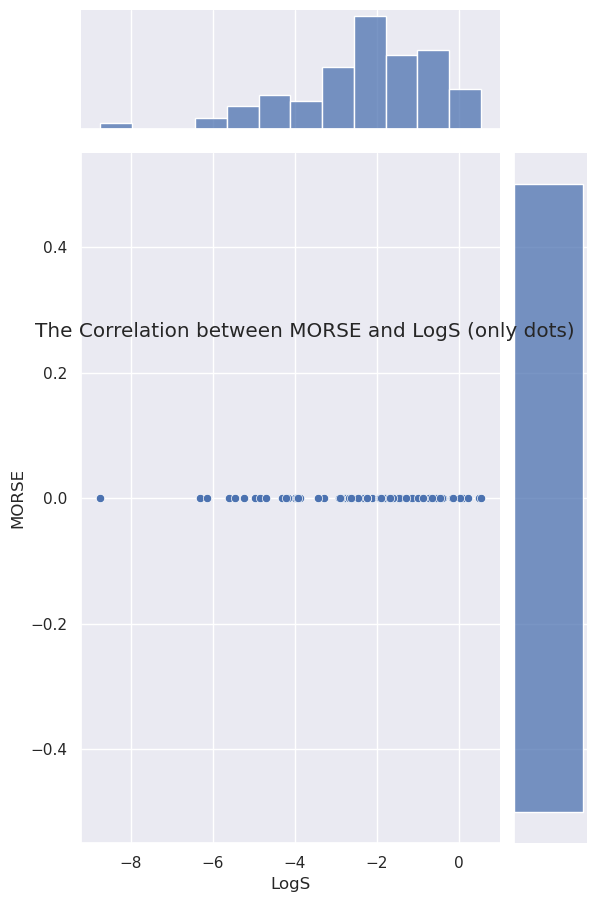

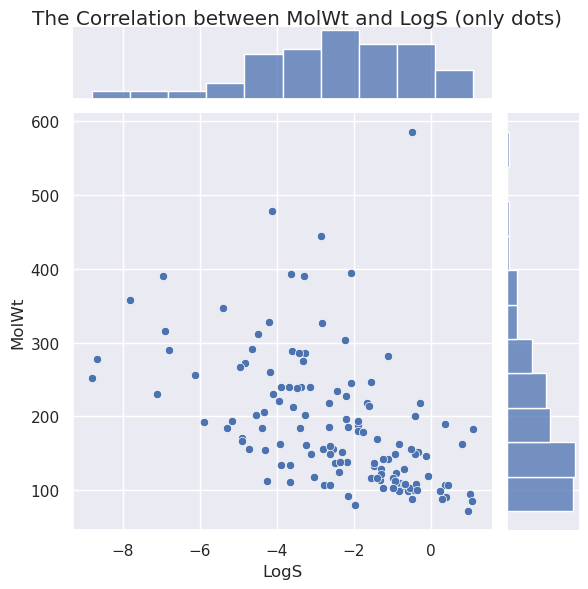

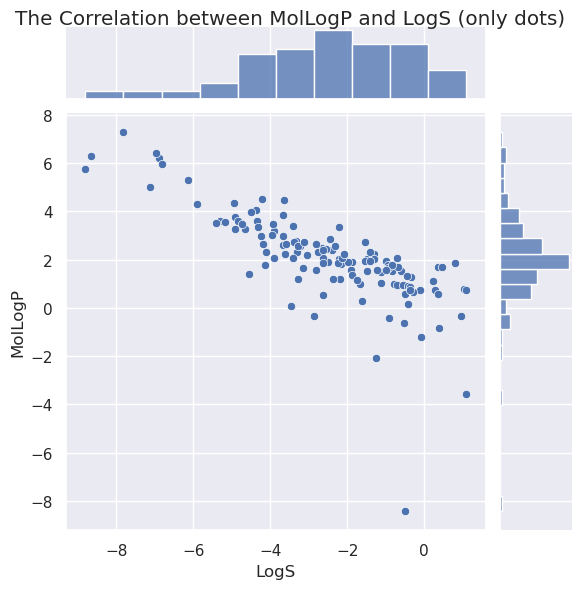

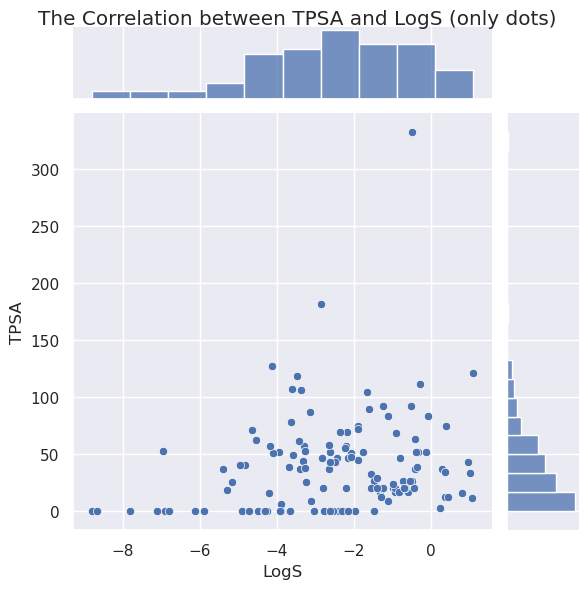

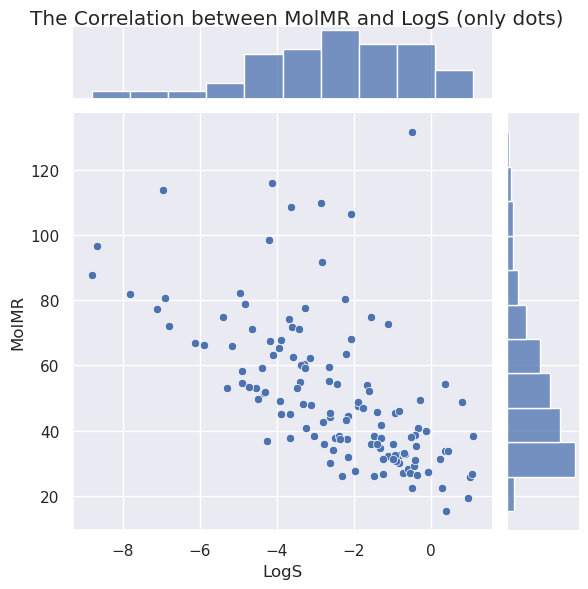

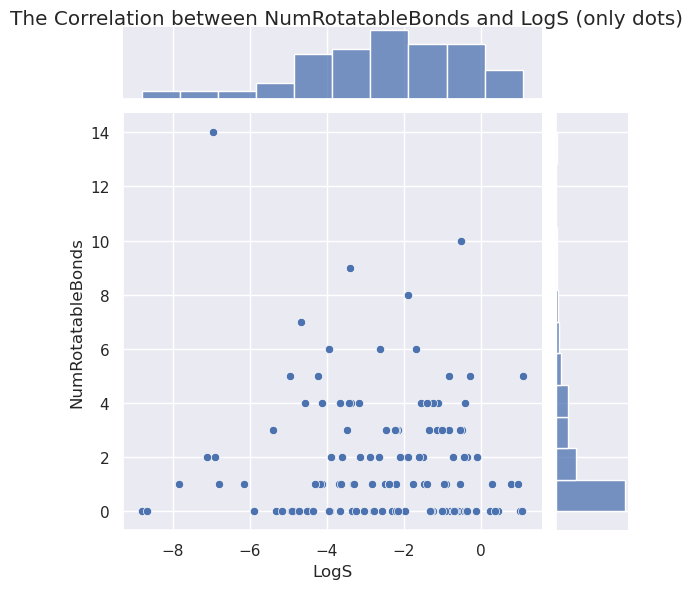

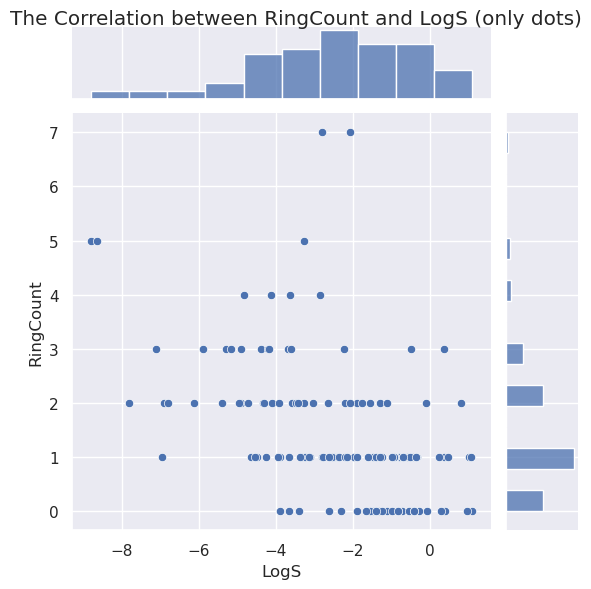

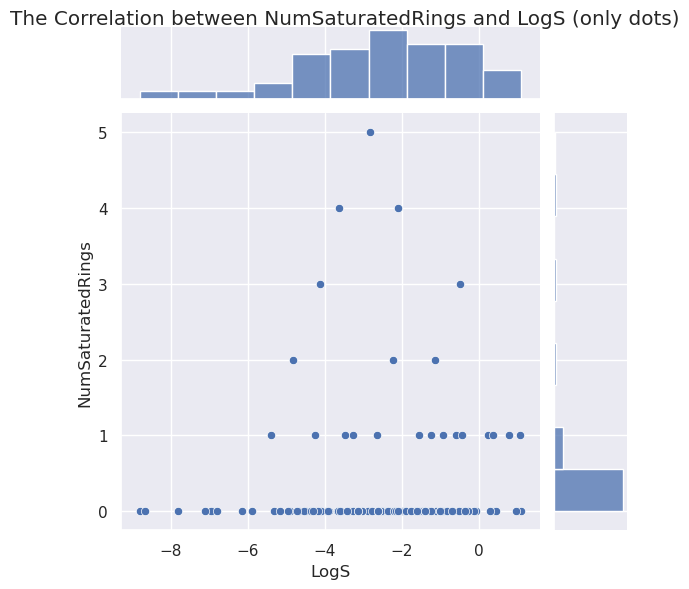

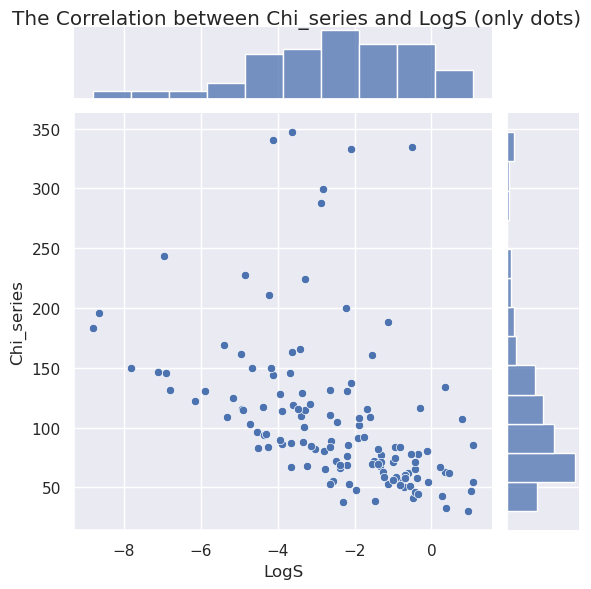

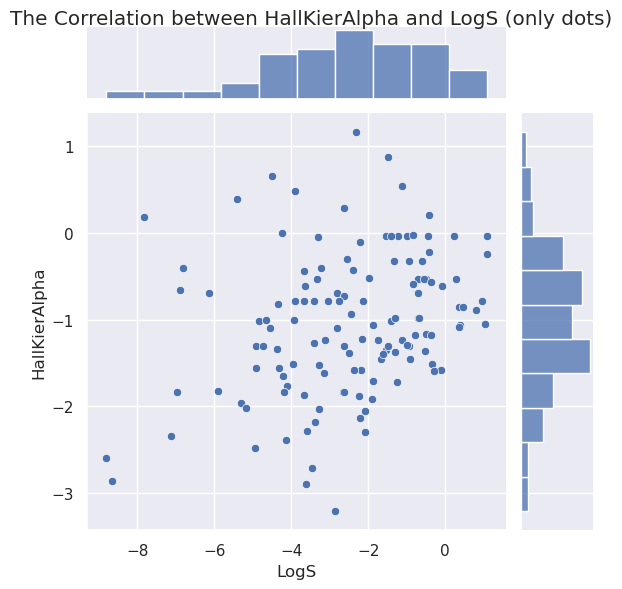

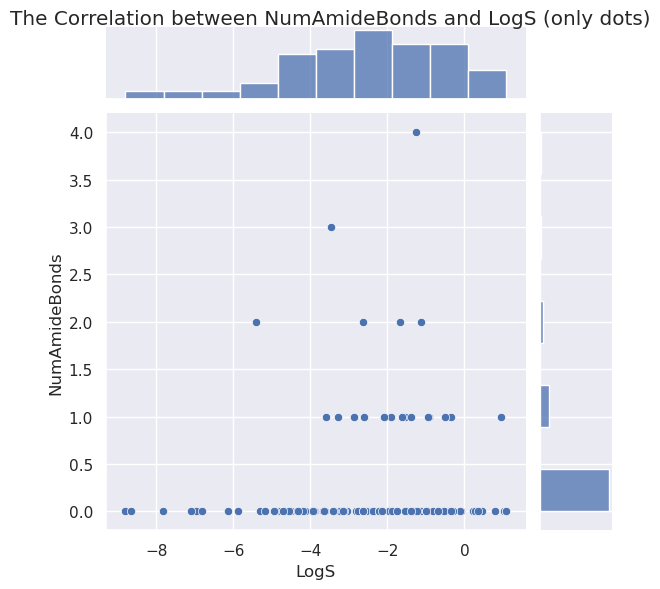

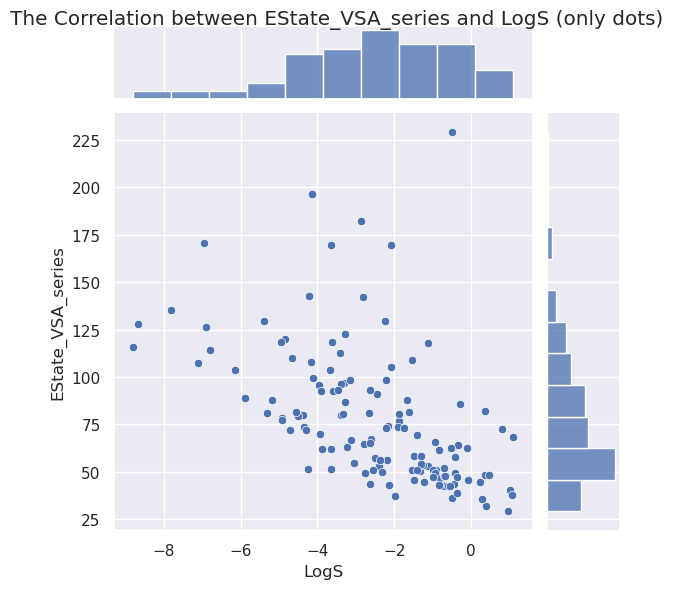

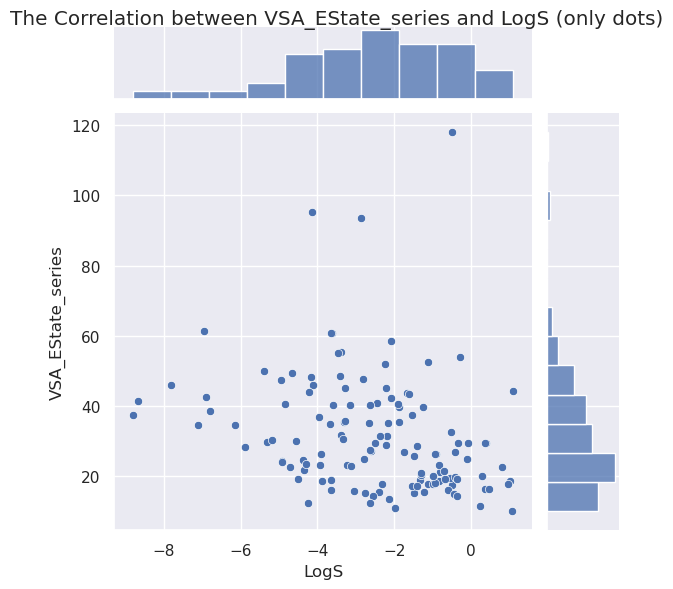

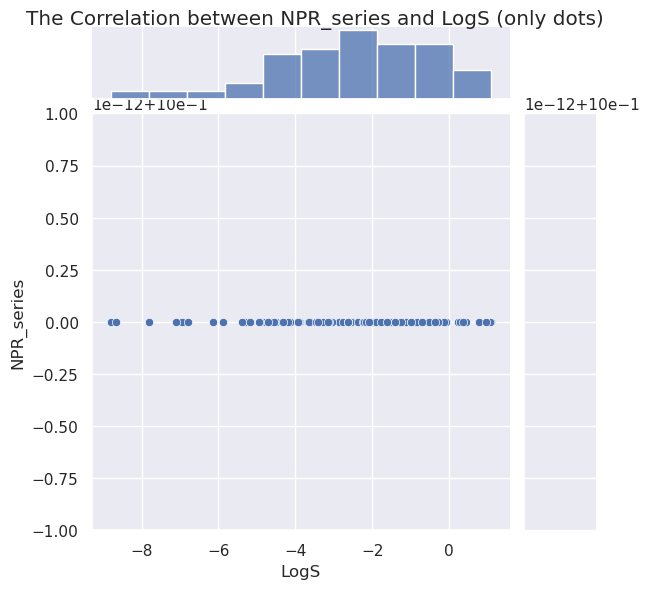

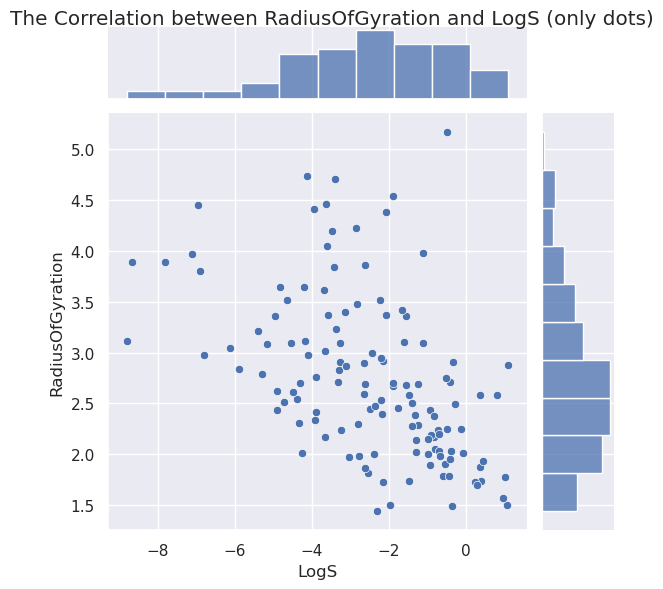

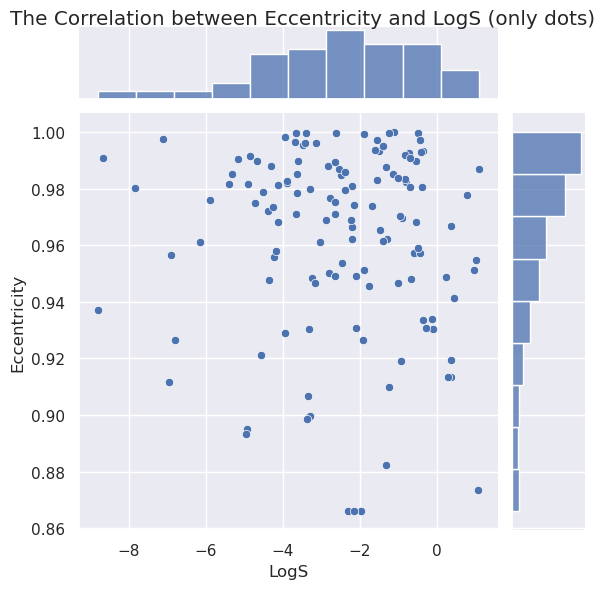

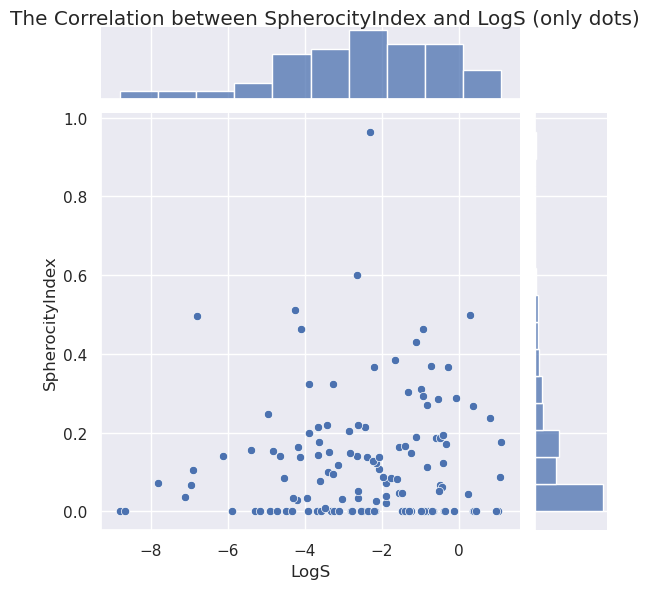

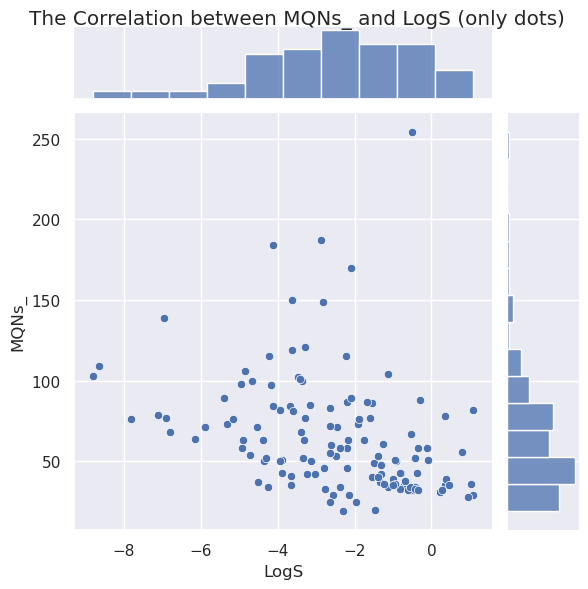

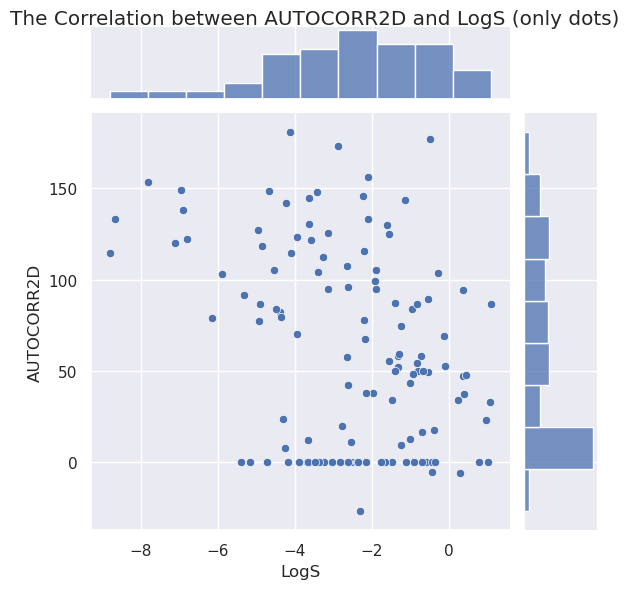

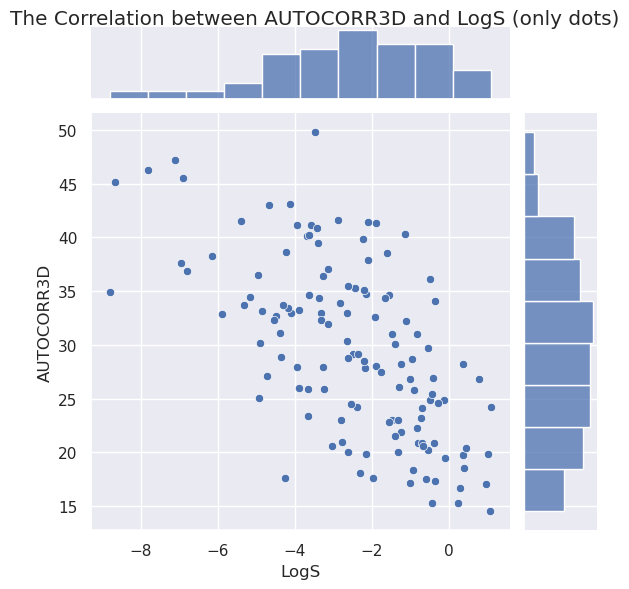

In [104]:
implement_corr(xte_fws2,'ws')
implement_corr(xte_fde2,'de')
implement_corr(xte_flo2,'lo')
implement_corr(xte_fhu2,'hu')

In [139]:
def evaluate_lipinski(row):
   """
   Evaluate whether a compound follows Lipinski's Rule of Five
   Returns: bool, list of violations
   """
   violations = []
   
   if row['MolWt'] > 500:
       violations.append('MW > 500')
   if row['MolLogP'] > 5:
       violations.append('LogP > 5')
   if row['NumHAcceptors'] > 10:
       violations.append('HBA > 10')
   if row['NumHDonors'] > 5:
       violations.append('HBD > 5')
   if row['NumRotatableBonds'] < 6:  # drug-like condition
       violations.append('RotBonds < 6')
   if row['TPSA'] > 140:
       violations.append('TPSA > 140')
       
   return len(violations) <= 1, violations  # Allow one violation as per Lipinski's rule

def bRo5_vis(table, name):  #Lipinski_bRo5_vis
   # Calculate normalized values
   data=pd.DataFrame() 
   data['MolWt']= [float(i/500.0) for i in table['MolWt'].values]
   data['MolLogP'] = [float(i/5.0)   for i in table['MolLogP'].values]
   data['NumHAcceptors']  = [float(i/10.0)  for i in table['NumHAcceptors'].values]
   # data['HBD']  = [float(i/5.0)   for i in table['NumHDonors'].values]
   data['NumHDonors']  = [float(i/5.0)   for i in table['NumHDonors'].values]
   data['NumRotatableBonds'] = [float(i/10.0)  for i in table['NumRotatableBonds'].values]
   data['TPSA'] = [float(i/140.0) for i in table['TPSA'].values]

   '''
   Conditions:
   1. Molecular weight ≤ 500
   2. CLogP ≤ 5 ( MlogP ≤ 4.5 )
   3. No. hydrogen bond acceptor ≤ 10 ( The sum of Os and Ns )
   4. No. hydrogen bond donors ≤ 5 ( The sum of OHs and NHs )
   5. No. Rotatable bonds >=6 (=drug-like)
   return 'Suitable' / 'Violated' following Lipinski's rule
   '''
   
   # Evaluate Lipinski's rules for each compound
   results = []
   for idx in range(len(table)):
       suitable, violations = evaluate_lipinski(table.iloc[idx])
       results.append({
           'Compound': idx + 1,
           'Suitable': suitable,
           'Violations': violations
       })
   
   # Create summary statistics
   total_compounds = len(results)
   suitable_compounds = sum(1 for r in results if r['Suitable'])
   
   # Print evaluation results
#    print(f"\n=== Lipinski's Rule of Five Evaluation for {name} ===")
#    print(f"Total compounds: {total_compounds}")
#    print(f"Suitable compounds: {suitable_compounds} ({suitable_compounds/total_compounds*100:.1f}%)")
#    print(f"Unsuitable compounds: {total_compounds-suitable_compounds} ({(total_compounds-suitable_compounds)/total_compounds*100:.1f}%)")
   
#    # Print detailed violations for unsuitable compounds
#    print("\nDetailed violations:")
#    for result in results:
#        if not result['Suitable']:
#            print(f"Compound {result['Compound']}: {', '.join(result['Violations'])}")

   categories=list(data.columns)  # This will set up the parameters for the angles of the radar plot. 
   N = len(categories)
   values=data[categories].values[0]
   values=np.append(values,values[:1])
   angles = [n / float(N) * 2 * np.pi for n in range(N)]
   angles += angles[:1]

   Ro5_up=[1,1,1,1,1,1,1] #The upper limit for bRo5
   Ro5_low=[0.5,0.1,0,0.25,0.1,0.5,0.5]  #The lower limit for bRo5

   # Create figure with adjusted size for legend
   fig = plt.figure(figsize=(13,10))
   ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
   
   plt.xticks(angles[:-1], categories, color='k', size=20)
   plt.tick_params(axis='y', width=4, labelsize=12, grid_alpha=0.05)
   ax.set_rlabel_position(0)

   # Plot limits
   ax.plot(angles, Ro5_up, linewidth=2, linestyle='-', color='red', label='Upper limit')
   ax.plot(angles, Ro5_low, linewidth=2, linestyle='-', color='red', label='Lower limit')
   ax.fill(angles, Ro5_low, 'orangered', alpha=0.2)

   # Plot compounds with different colors based on suitability
   for i in data.index[:250]: #I'll just show the profile for the first 250 molecules in the table for clarity of the plot
       values = data[categories].values[i]
       values = np.append(values, values[:1])
       color = 'green' if results[i]['Suitable'] else 'red'
       alpha = 0.5 if results[i]['Suitable'] else 0.3
       ax.plot(angles, values, linewidth=0.5, color=color, alpha=alpha)

   ax.grid(axis='y', linewidth=1.0, linestyle='dotted', alpha=0.8)
   ax.grid(axis='x', linewidth=1.5, linestyle='-', alpha=1)
   
   # Add legend for suitable/unsuitable with improved positioning
   ax.plot([], [], color='red', linestyle='-', linewidth=2, label='Upper limit')
   ax.plot([], [], color='red', linestyle='-', linewidth=2, label='Lower limit')
   ax.plot([], [], color='green', alpha=0.5, label='Suitable')
   ax.plot([], [], color='red', alpha=0.3, label='Unsuitable')
   
   # Adjusted legend
   ax.legend(fontsize=12, 
            loc='center left',
            bbox_to_anchor=(1.2, 0.5),
            frameon=True,
            facecolor='white',
            edgecolor='black',
            borderaxespad=0.)

   title = f"[{name}] Lipinski's Rule of Five\n"
   title += f"Suitable: {suitable_compounds}/{total_compounds} ({suitable_compounds/total_compounds*100:.1f}%)"
   ax.set_title(title, fontsize=20, pad=20)

   # Save and show plot
   os.makedirs('result', exist_ok=True)
   save_path = os.path.join('result', f'bRo5_vis_{name}.png')
   plt.savefig(save_path, dpi=300, bbox_inches='tight')
   plt.show()
   plt.close()

   return pd.DataFrame(results) 

In [125]:
lo5s=[
    1, #phase1  "MolWeight"
    1, #phase2  "Mol_MR"
    1, #phase3  "Mol_TPSA"
    1, #phase4  "Mol_logP"
    1, #phase5  "RotatedBonds"
    1, #phase6  "HeavyAtom"
    1, #phase7  "numHAcceptor"
    1, #phase8  "numHDoner"
    1, #phase9  "numHeteroatom"
    1, #phase10 "NumValenceElec"
    1, #phase11 "NHOHCount"
    1, #phase12 "NOCount"
    1, #phase13 "Ringcount"
    1, #phase14 "numAromaticR"
    1, #phase15 "numSaturateR"
    1, #phase16 "numAliphaticR"
    0, #phase17 "LabuteASA"
    0, #phase18 "BalabanJs"
    0, #phase19 "BertzCTs"
    0, #phase20 "ipc"
    0, #phase21 "kappa_Series[1-3]"
    0, #phase22 "Chi_Series[13]"
    0, #phase23 "phi"
    0, #phase24 "HallKierAlpha"
    0, #phase25 "NumAmideBonds"
    0, #phase26 "FractionCSP3"
    0, #phase27 "NumSpiroAtoms"
    0, #phase28 "NumBridgeheadAtoms"
    0, #phase29 "PEOE_VSA_Series[1-14]"
    0, #phase30 "SMR_VSA_Series[1-10]"
    0, #phase31 "SlogP_VSA_Series[1-12]"
    0, #phase32 "EState_VSA_Series[1-11]"
    0, #phase33 "VSA_EState_Series[1-10]"
    0, #phase34 "Asphericity"
    0, #phase35 "PBF"
    0, #phase36 "PMI_series[1-3]"
    0, #phase37 "NPR_series[1-2]"
    0, #phase38 "RadiusOfGyration"
    0, #phase39 "InertialShapeFactor"
    0, #phase40 "Eccentricity"
    0, #phase41 "SpherocityIndex"
    0, #phase42 "MQNs"
    0, #phase43 "AUTOCORR2D"
    0, #phase44 "BCUT2D"
    0, #phase45 "AUTOCORR3D"
    0, #phase46 "RDF"
    0, #phase47 "MORSE"
    0, #phase48 "WHIM"
    0, #phase49 "GETAWAY"
]

In [126]:
lop5_ws = search_data_origin(lo5s, group_nws2, mol_ws, 'ws', 'pd')
lop5_de = search_data_origin(lo5s, group_nde2, mol_de, 'de', 'pd')
lop5_lo = search_data_origin(lo5s, group_nlo2, mol_lo, 'lo', 'pd')
lop5_hu = search_data_origin(lo5s, group_nhu2, mol_hu, 'hu', 'pd')

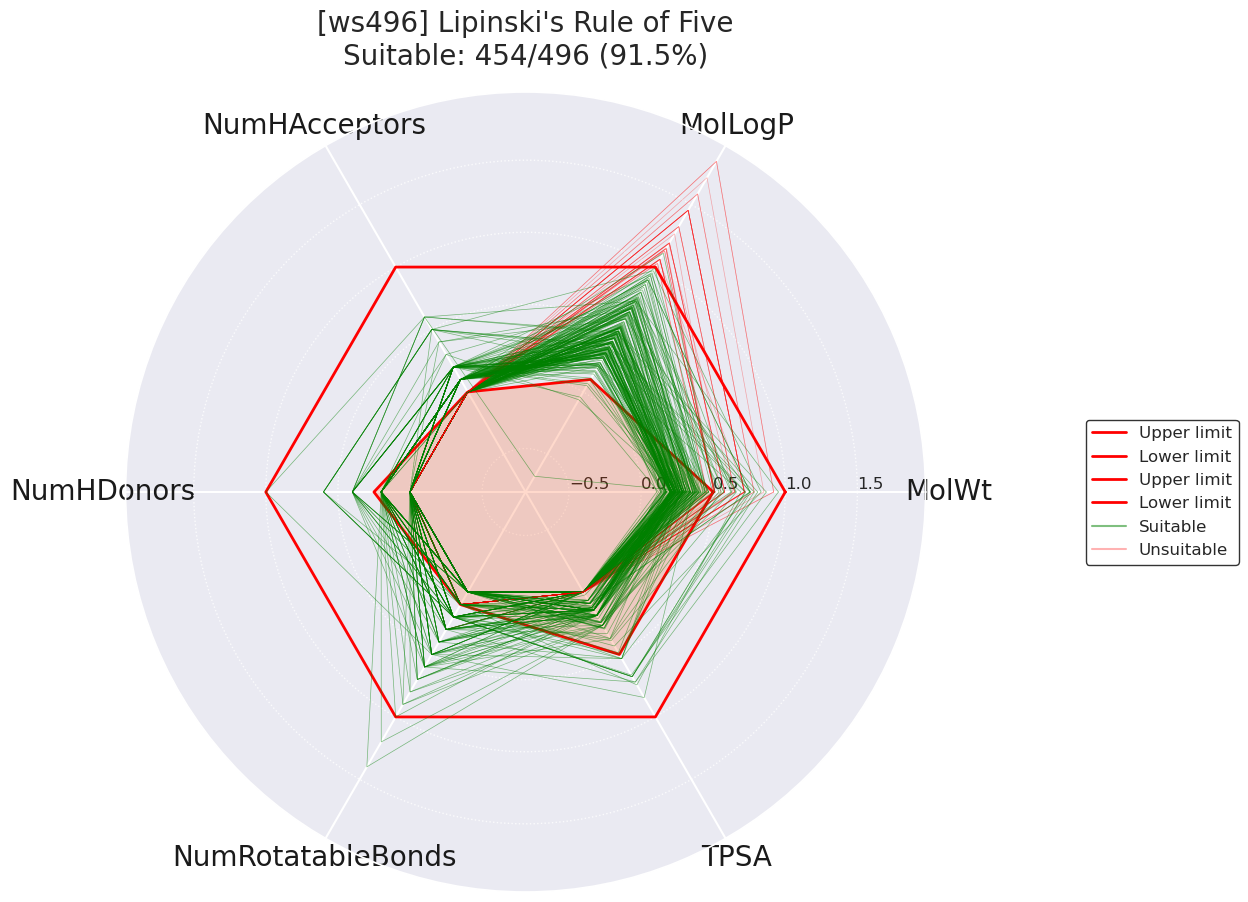

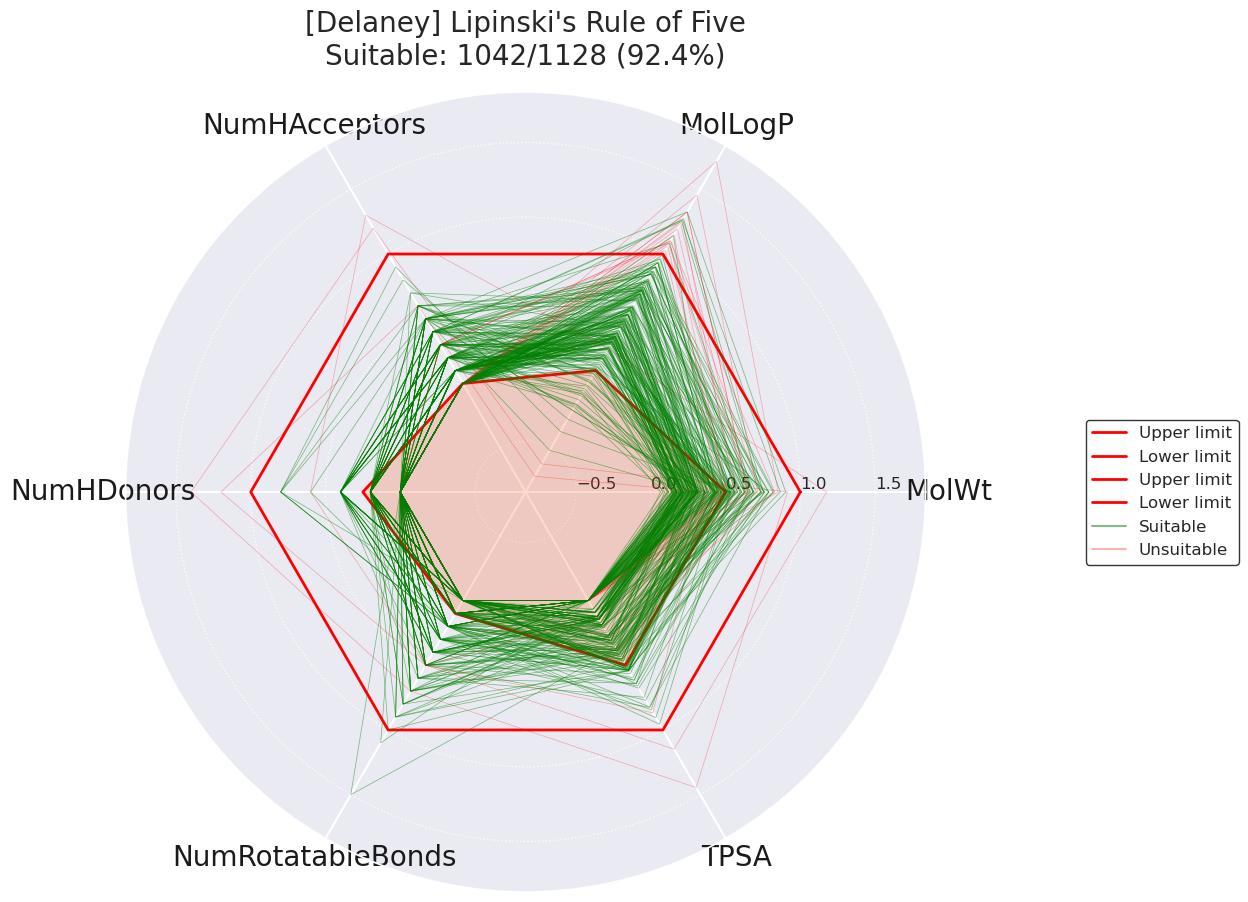

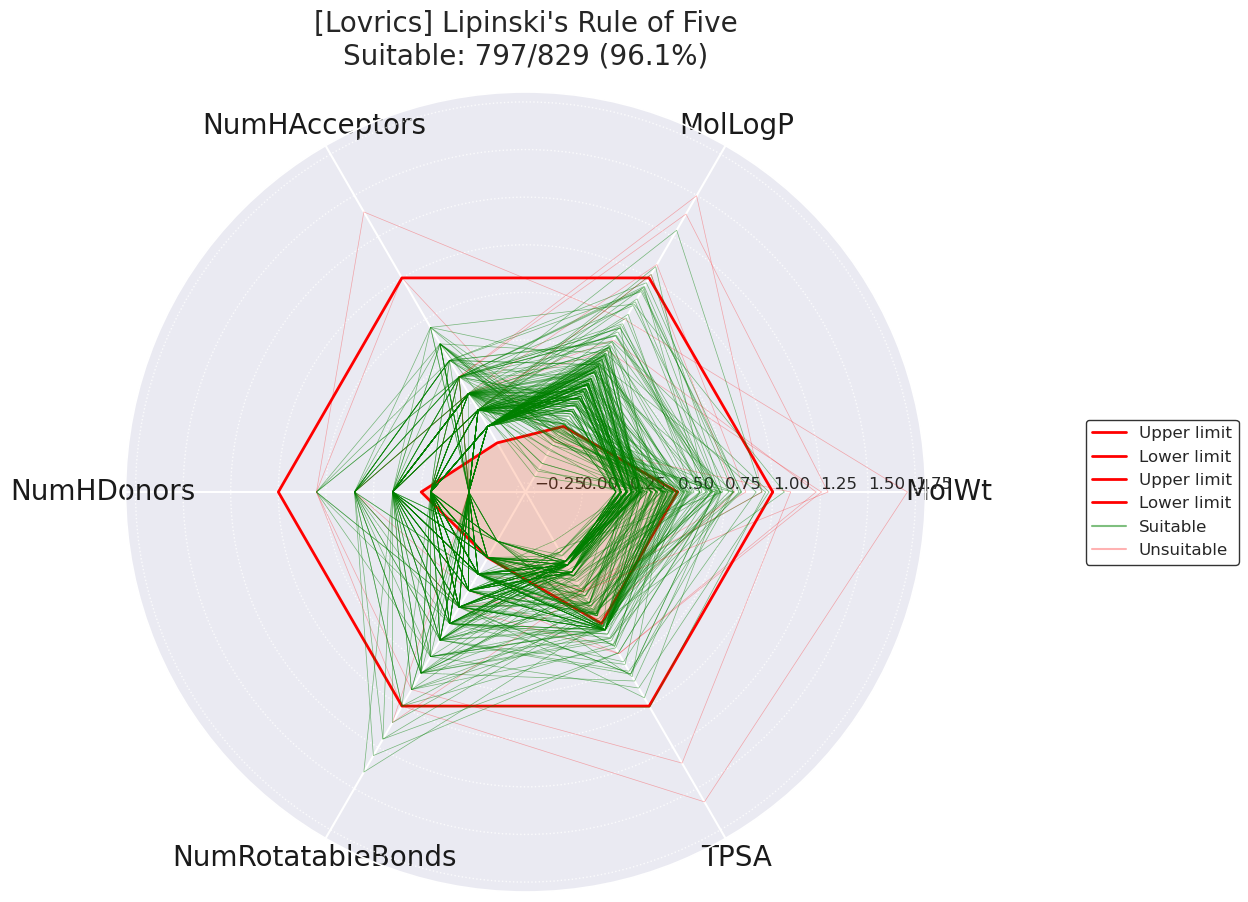

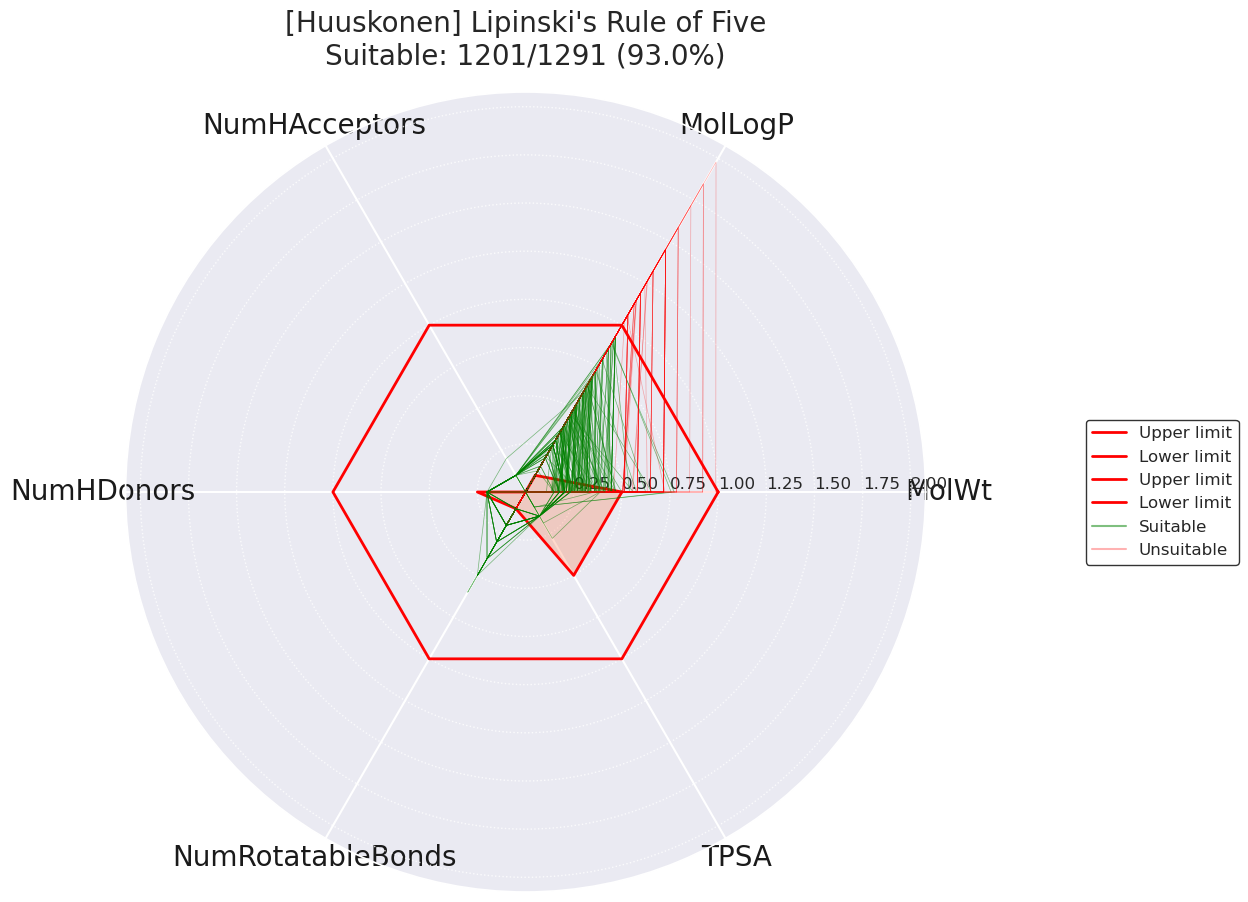

In [142]:
data_ws_lop5 = bRo5_vis(lop5_ws,'ws496')
data_de_lop5 = bRo5_vis(lop5_de,'Delaney')
data_lo_lop5 = bRo5_vis(lop5_lo,'Lovrics')
data_hu_lop5 = bRo5_vis(lop5_hu,'Huuskonen')
data_ws_lop5.to_csv("result/Lipinski5_All_data_ws.csv")
data_de_lop5.to_csv("result/Lipinski5_All_data_de.csv")
data_lo_lop5.to_csv("result/Lipinski5_All_data_lo.csv")
data_hu_lop5.to_csv("result/Lipinski5_All_data_hu.csv")

In [134]:
_, lop5_ws_te, _, _ = train_test_split(lop5_ws, y_ws, test_size=0.1,random_state=42)
_, lop5_de_te, _, _ = train_test_split(lop5_de, y_de, test_size=0.1,random_state=42)
_, lop5_lo_te, _, _ = train_test_split(lop5_lo, y_lo, test_size=0.1,random_state=42)
_, lop5_hu_te, _, _ = train_test_split(lop5_hu, y_hu, test_size=0.1,random_state=42)

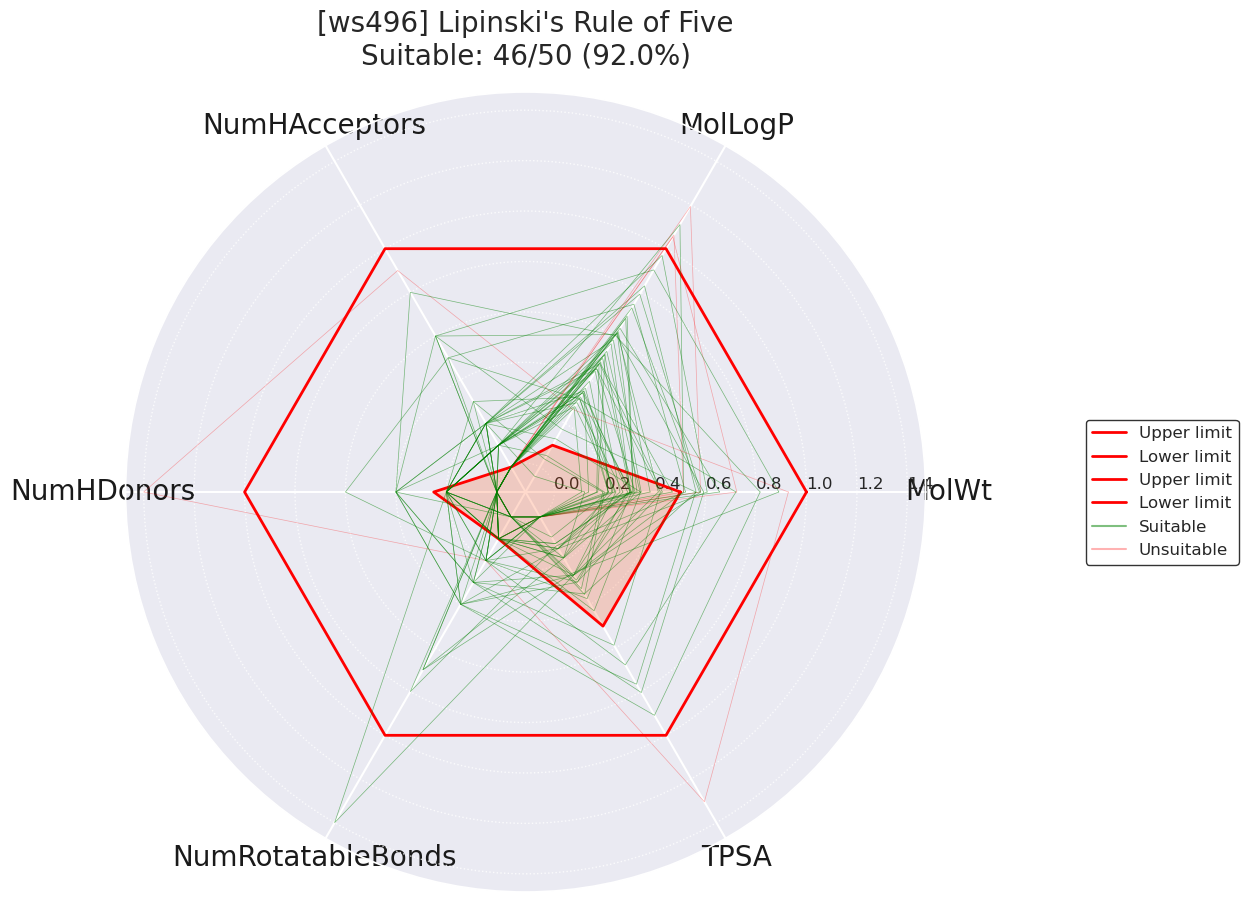

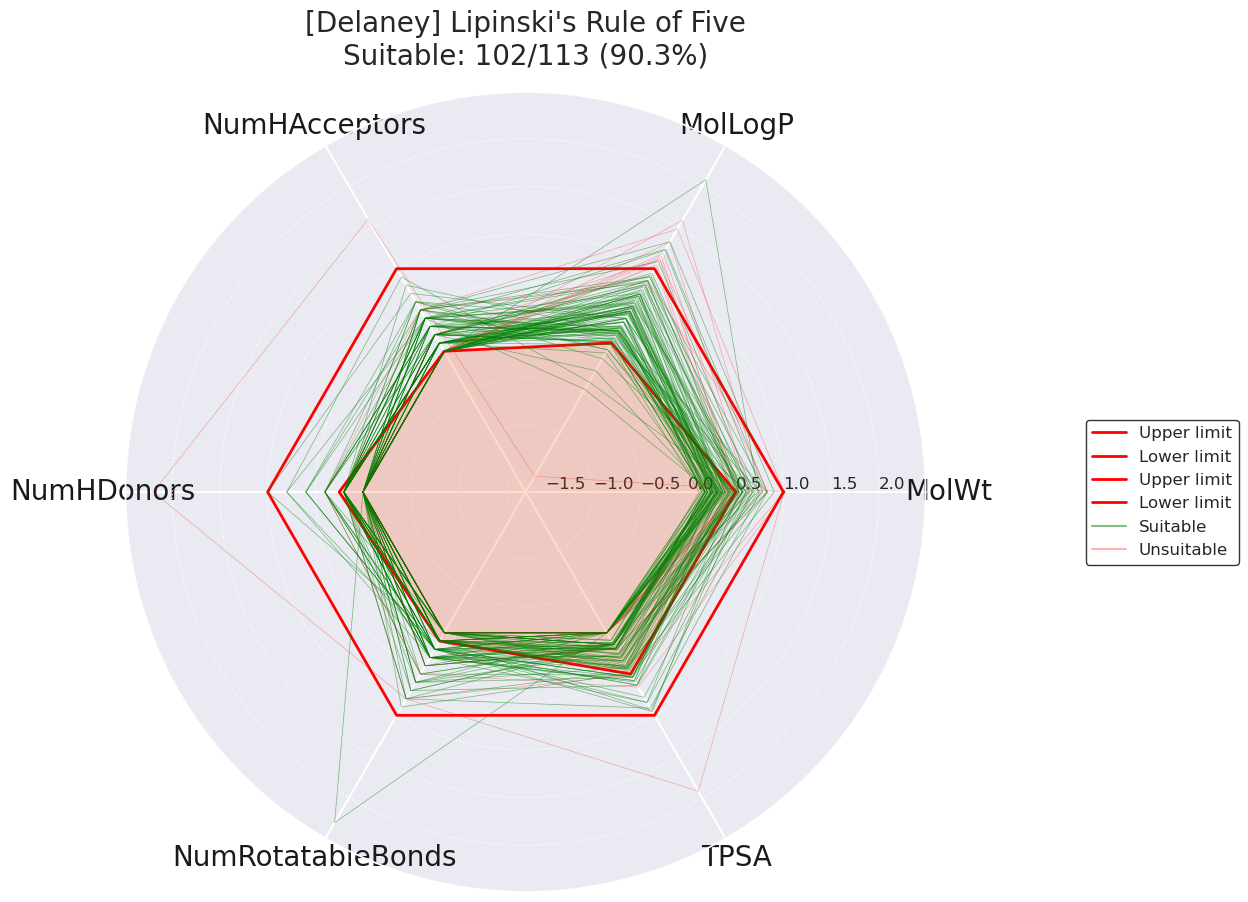

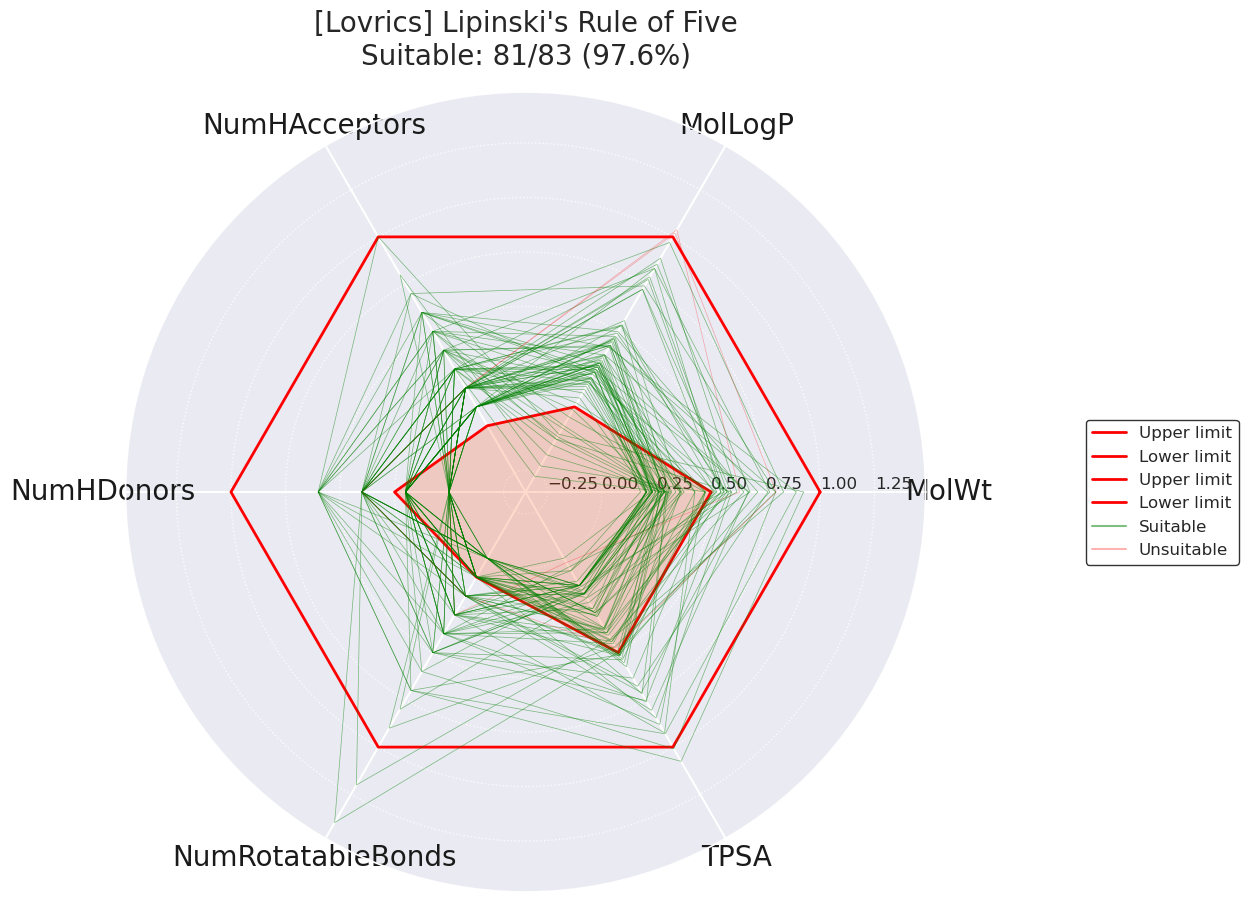

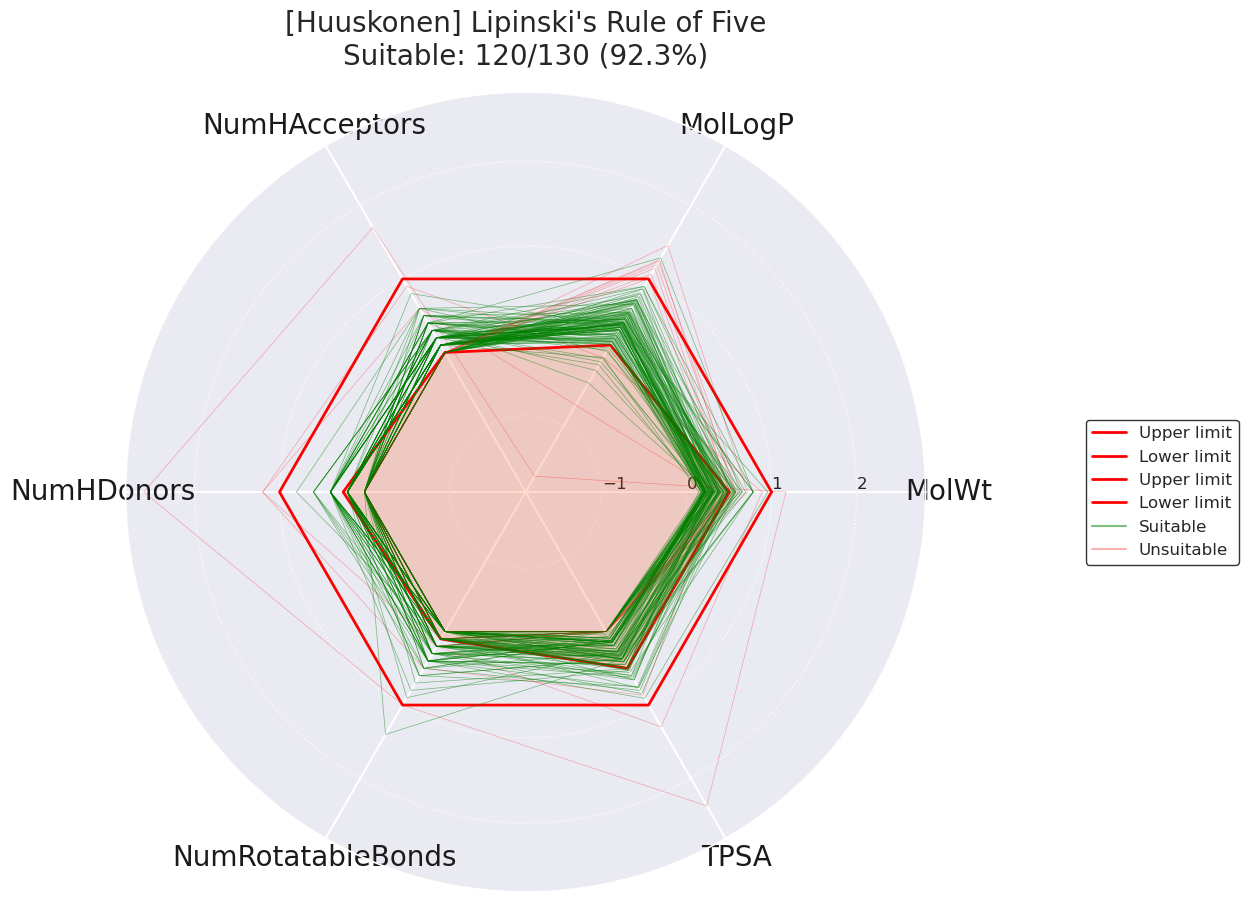

In [141]:
lop5_ws_te_res=bRo5_vis(lop5_ws_te,'ws496')
lop5_de_te_res=bRo5_vis(lop5_de_te,'Delaney')
lop5_lo_te_res=bRo5_vis(lop5_lo_te,'Lovrics')
lop5_hu_te_res=bRo5_vis(lop5_hu_te,'Huuskonen')
lop5_ws_te_res.to_csv("result/Lipinski5_test_data_ws.csv")
lop5_de_te_res.to_csv("result/Lipinski5_test_data_de.csv")
lop5_lo_te_res.to_csv("result/Lipinski5_test_data_lo.csv")
lop5_hu_te_res.to_csv("result/Lipinski5_test_data_hu.csv")

In [130]:
import plotly.graph_objects as go
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import os

def create_interactive_3d_structure(smiles, show_labels=True):
    """
    Create an interactive 3D structure visualization with toggleable labels
    
    Parameters:
    smiles : str
        SMILES string of the molecule
    show_labels : bool
        Whether to show atom labels by default
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Failed to create molecule from SMILES: {smiles}")
            return None
            
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol)
    except:
        print(f"Failed to generate 3D coordinates for: {smiles}")
        return None
    
    conf = mol.GetConformer()
    atom_coords = conf.GetPositions()
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    
    # Enhanced color scheme
    atom_colors = {
        'H': '#FFFFFF',  # White
        'C': '#909090',  # Grey
        'N': '#3050F8',  # Blue
        'O': '#FF0D0D',  # Red
        'F': '#90E050',  # Light green
        'Cl': '#1FF01F', # Green
        'Br': '#A62929', # Brown
        'I': '#940094',  # Purple
        'P': '#FF8000',  # Orange
        'S': '#FFFF30',  # Yellow
        'B': '#FFB5B5',  # Pink
    }
    
    # Create separate traces for atoms (with and without labels)
    traces = []
    unique_symbols = set(atom_symbols)
    
    for symbol in unique_symbols:
        mask = [s == symbol for s in atom_symbols]
        if any(mask):
            coords = atom_coords[mask]
            
            # Trace with labels
            traces.append(go.Scatter3d(
                x=coords[:, 0],
                y=coords[:, 1],
                z=coords[:, 2],
                mode='markers+text' if show_labels else 'markers',
                marker=dict(
                    size=16,
                    color=atom_colors.get(symbol, '#000000'),
                    opacity=0.9,
                    symbol='circle',
                    line=dict(color='black', width=1)
                ),
                text=[symbol] * len(coords) if show_labels else None,
                textposition='middle center',
                textfont=dict(size=12, color='black'),
                hoverinfo='text',
                hovertext=[f"{symbol} ({i})" for i, _ in enumerate(coords)],
                name=f"{symbol} atoms",
                showlegend=True
            ))
            
    # Enhanced bond visualization
    bond_traces = {
        'Single Bonds': [],
        'Double Bonds': [],
        'Triple Bonds': [],
        'Aromatic Bonds': []
    }
    
    for bond in mol.GetBonds():
        id1 = bond.GetBeginAtomIdx()
        id2 = bond.GetEndAtomIdx()
        pos1 = atom_coords[id1]
        pos2 = atom_coords[id2]
        
        # Calculate bond vector and perpendicular vector for offset
        bond_vector = pos2 - pos1
        bond_length = np.linalg.norm(bond_vector)
        
        if bond_length > 0:
            # Create perpendicular vector for double/triple bonds
            if abs(bond_vector[2]) < bond_length:
                perp_vector = np.cross(bond_vector, [0, 0, 1])
            else:
                perp_vector = np.cross(bond_vector, [0, 1, 0])
            perp_vector = perp_vector / np.linalg.norm(perp_vector) * 0.1  # Scale factor for offset
            
            bond_type = bond.GetBondType()
            if bond_type == Chem.BondType.SINGLE:
                bond_traces['Single Bonds'].append((pos1, pos2))
            elif bond_type == Chem.BondType.DOUBLE:
                bond_traces['Double Bonds'].extend([
                    (pos1 + perp_vector, pos2 + perp_vector),
                    (pos1 - perp_vector, pos2 - perp_vector)
                ])
            elif bond_type == Chem.BondType.TRIPLE:
                bond_traces['Triple Bonds'].extend([
                    (pos1, pos2),
                    (pos1 + perp_vector, pos2 + perp_vector),
                    (pos1 - perp_vector, pos2 - perp_vector)
                ])
            elif bond_type == Chem.BondType.AROMATIC:
                bond_traces['Aromatic Bonds'].append((pos1, pos2))
    
    # Create bond traces with different styles
    bond_styles = {
        'Single Bonds': (5, '#333333', 'solid'),
        'Double Bonds': (3, '#333333', 'solid'),
        'Triple Bonds': (3, '#333333', 'solid'),
        'Aromatic Bonds': (5, '#333333', 'dashdot')
    }
    
    for bond_type, positions in bond_traces.items():
        if positions:
            width, color, dash = bond_styles[bond_type]
            x_coords = []
            y_coords = []
            z_coords = []
            
            for pos1, pos2 in positions:
                x_coords.extend([pos1[0], pos2[0], None])
                y_coords.extend([pos1[1], pos2[1], None])
                z_coords.extend([pos1[2], pos2[2], None])
            
            traces.append(go.Scatter3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                mode='lines',
                line=dict(
                    color=color,
                    width=width,
                    dash=dash
                ),
                name=bond_type,
                showlegend=True,
                hoverinfo='name'
            ))
    
    # Create figure
    fig = go.Figure(data=traces)
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f"SMILES: {smiles}",
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        scene=dict(
            aspectmode='data',
            xaxis=dict(showticklabels=False, showgrid=False, zeroline=False, showbackground=False),
            yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, showbackground=False),
            zaxis=dict(showticklabels=False, showgrid=False, zeroline=False, showbackground=False),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5),
                up=dict(x=0, y=0, z=1)
            ),
            dragmode='orbit'
        ),
        margin=dict(l=0, r=0, t=50, b=0),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(0, 0, 0, 0.2)',
            borderwidth=1
        ),
        template="plotly_white"
    )
    
    return fig

def save_dataset_3d_structures_from_smiles(smiles_series, dataset_name):
    """
    Save interactive 3D structures for a dataset of SMILES strings
    Creates two versions: with and without labels
    """
    # Create directories
    base_dir = os.path.join('result/3d_structures', dataset_name)
    labeled_dir = os.path.join(base_dir, 'with_labels')
    unlabeled_dir = os.path.join(base_dir, 'without_labels')
    os.makedirs(labeled_dir, exist_ok=True)
    os.makedirs(unlabeled_dir, exist_ok=True)
    
    for idx, smiles in enumerate(smiles_series, 1):
        if isinstance(smiles, str):
            # Create labeled version
            fig_labeled = create_interactive_3d_structure(smiles, show_labels=True)
            if fig_labeled is not None:
                filename = f'molecule_{idx:04d}.html'
                fig_labeled.write_html(
                    os.path.join(labeled_dir, filename),
                    include_plotlyjs='cdn',
                    full_html=True,
                    config={'displayModeBar': True, 'editable': True, 'scrollZoom': True}
                )
            
            # Create unlabeled version
            fig_unlabeled = create_interactive_3d_structure(smiles, show_labels=False)
            if fig_unlabeled is not None:
                filename = f'molecule_{idx:04d}.html'
                fig_unlabeled.write_html(
                    os.path.join(unlabeled_dir, filename),
                    include_plotlyjs='cdn',
                    full_html=True,
                    config={'displayModeBar': True, 'editable': True, 'scrollZoom': True}
                )                
            # print(f'Saved molecule {idx}')
        else:
            print(f'Invalid SMILES at index {idx}')


In [131]:
save_dataset_3d_structures_from_smiles(fin_ws_report2['SMILES'], 'ws')
save_dataset_3d_structures_from_smiles(fin_de_report2['SMILES'], 'de')
save_dataset_3d_structures_from_smiles(fin_lo_report2['SMILES'], 'lo')
save_dataset_3d_structures_from_smiles(fin_hu_report2['SMILES'], 'hu')